## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


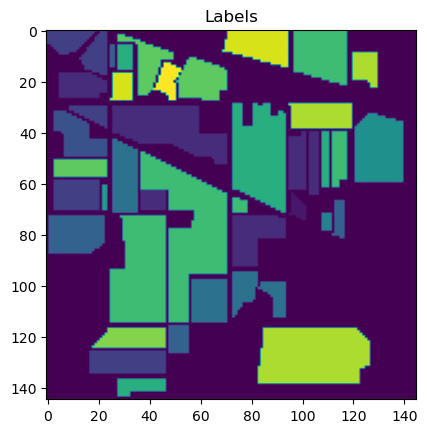

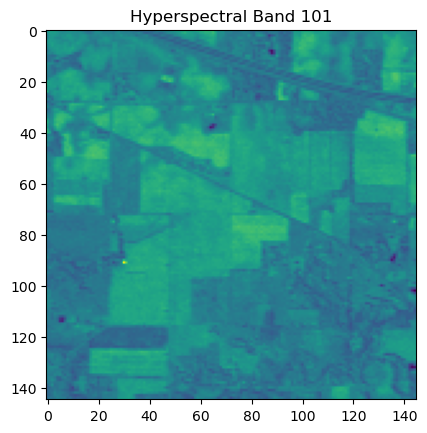

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(160, 5, 5, 200)
(80, 5, 5, 200)
(10009, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0818, PSNR: 10.6502


Epoch [1/50] Training Loss: 0.0656, PSNR: 11.4078
	[Val]   Batch [1/33] Loss: 0.0492, PSNR: 12.7442
	[Val]   Batch [10/33] Loss: 0.0485, PSNR: 12.4074
	[Val]   Batch [20/33] Loss: 0.0481, PSNR: 12.0056
	[Val]   Batch [30/33] Loss: 0.0466, PSNR: 12.3877
Epoch [1/50] Validation Loss: 0.0488, PSNR: 12.5722

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0524, PSNR: 12.4309


Epoch [2/50] Training Loss: 0.0401, PSNR: 13.5599
	[Val]   Batch [1/33] Loss: 0.0298, PSNR: 14.9155
	[Val]   Batch [10/33] Loss: 0.0293, PSNR: 14.5958
	[Val]   Batch [20/33] Loss: 0.0290, PSNR: 14.2002
	[Val]   Batch [30/33] Loss: 0.0282, PSNR: 14.5776
Epoch [2/50] Validation Loss: 0.0297, PSNR: 14.7344

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0324, PSNR: 14.6651


Epoch [3/50] Training Loss: 0.0237, PSNR: 15.8255
	[Val]   Batch [1/33] Loss: 0.0182, PSNR: 17.0601
	[Val]   Batch [10/33] Loss: 0.0177, PSNR: 16.7864
	[Val]   Batch [20/33] Loss: 0.0174, PSNR: 16.4135
	[Val]   Batch [30/33] Loss: 0.0169, PSNR: 16.7967
Epoch [3/50] Validation Loss: 0.0181, PSNR: 16.8827

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0168, PSNR: 17.4009


Epoch [4/50] Training Loss: 0.0145, PSNR: 17.9444
	[Val]   Batch [1/33] Loss: 0.0118, PSNR: 18.9632
	[Val]   Batch [10/33] Loss: 0.0113, PSNR: 18.7481
	[Val]   Batch [20/33] Loss: 0.0110, PSNR: 18.4154
	[Val]   Batch [30/33] Loss: 0.0107, PSNR: 18.7948
Epoch [4/50] Validation Loss: 0.0117, PSNR: 18.7880

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0113, PSNR: 19.2386


Epoch [5/50] Training Loss: 0.0097, PSNR: 19.6635
	[Val]   Batch [1/33] Loss: 0.0082, PSNR: 20.5381
	[Val]   Batch [10/33] Loss: 0.0077, PSNR: 20.3909
	[Val]   Batch [20/33] Loss: 0.0075, PSNR: 20.1039
	[Val]   Batch [30/33] Loss: 0.0072, PSNR: 20.4720
Epoch [5/50] Validation Loss: 0.0081, PSNR: 20.3627

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0081, PSNR: 20.5509


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0661
	[Val]   Batch [1/33] Loss: 0.0063, PSNR: 21.6934
	[Val]   Batch [10/33] Loss: 0.0058, PSNR: 21.6249
	[Val]   Batch [20/33] Loss: 0.0056, PSNR: 21.3803
	[Val]   Batch [30/33] Loss: 0.0054, PSNR: 21.7885
Epoch [6/50] Validation Loss: 0.0062, PSNR: 21.5404

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0065, PSNR: 21.5051


Epoch [7/50] Training Loss: 0.0055, PSNR: 22.1413
	[Val]   Batch [1/33] Loss: 0.0050, PSNR: 22.6773
	[Val]   Batch [10/33] Loss: 0.0045, PSNR: 22.7049
	[Val]   Batch [20/33] Loss: 0.0043, PSNR: 22.5021
	[Val]   Batch [30/33] Loss: 0.0042, PSNR: 22.8905
Epoch [7/50] Validation Loss: 0.0049, PSNR: 22.5499

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0049, PSNR: 22.5924


Epoch [8/50] Training Loss: 0.0045, PSNR: 23.0454
	[Val]   Batch [1/33] Loss: 0.0041, PSNR: 23.5201
	[Val]   Batch [10/33] Loss: 0.0037, PSNR: 23.6357
	[Val]   Batch [20/33] Loss: 0.0034, PSNR: 23.4699
	[Val]   Batch [30/33] Loss: 0.0033, PSNR: 23.9090
Epoch [8/50] Validation Loss: 0.0040, PSNR: 23.4308

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0038, PSNR: 23.4336


Epoch [9/50] Training Loss: 0.0038, PSNR: 23.7960
	[Val]   Batch [1/33] Loss: 0.0035, PSNR: 24.2198
	[Val]   Batch [10/33] Loss: 0.0030, PSNR: 24.4343
	[Val]   Batch [20/33] Loss: 0.0028, PSNR: 24.3055
	[Val]   Batch [30/33] Loss: 0.0027, PSNR: 24.7741
Epoch [9/50] Validation Loss: 0.0034, PSNR: 24.1774

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0037, PSNR: 24.2836


Epoch [10/50] Training Loss: 0.0033, PSNR: 24.4341
	[Val]   Batch [1/33] Loss: 0.0031, PSNR: 24.8139
	[Val]   Batch [10/33] Loss: 0.0026, PSNR: 25.1015
	[Val]   Batch [20/33] Loss: 0.0024, PSNR: 25.0093
	[Val]   Batch [30/33] Loss: 0.0023, PSNR: 25.4906
Epoch [10/50] Validation Loss: 0.0030, PSNR: 24.7973

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0028, PSNR: 25.2147


Epoch [11/50] Training Loss: 0.0029, PSNR: 24.9993
	[Val]   Batch [1/33] Loss: 0.0027, PSNR: 25.2814
	[Val]   Batch [10/33] Loss: 0.0023, PSNR: 25.6493
	[Val]   Batch [20/33] Loss: 0.0021, PSNR: 25.5893
	[Val]   Batch [30/33] Loss: 0.0020, PSNR: 26.1091
Epoch [11/50] Validation Loss: 0.0026, PSNR: 25.3096

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 24.8150


Epoch [12/50] Training Loss: 0.0026, PSNR: 25.4914
	[Val]   Batch [1/33] Loss: 0.0024, PSNR: 25.7787
	[Val]   Batch [10/33] Loss: 0.0020, PSNR: 26.2182
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.1900
	[Val]   Batch [30/33] Loss: 0.0017, PSNR: 26.7326
Epoch [12/50] Validation Loss: 0.0023, PSNR: 25.8425

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.3730


Epoch [13/50] Training Loss: 0.0023, PSNR: 25.9026
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.2535
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.7069
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.6951
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.2468
Epoch [13/50] Validation Loss: 0.0021, PSNR: 26.3179

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 26.1924


Epoch [14/50] Training Loss: 0.0021, PSNR: 26.2860
	[Val]   Batch [1/33] Loss: 0.0020, PSNR: 26.6219
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 27.0618
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.0635
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.6681
Epoch [14/50] Validation Loss: 0.0019, PSNR: 26.6821

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 26.6910


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.6058
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.0836
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.5245
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.5297
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.1280
Epoch [15/50] Validation Loss: 0.0017, PSNR: 27.1364

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.9059


Epoch [16/50] Training Loss: 0.0018, PSNR: 26.9322
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.5838
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 27.9837
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 27.9938
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.6119
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.6122

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.2837


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.2745
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.9006
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.2665
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.2869
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 28.9172
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.9222

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 26.8082


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.6204
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.2662
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.6055
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.6457
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.2977
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.2805

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.6634


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9557
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7989
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.0744
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.1070
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.7954
Epoch [19/50] Validation Loss: 0.0012, PSNR: 28.7750

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.2345


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2025
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.1496
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3908
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.4483
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.1505
Epoch [20/50] Validation Loss: 0.0011, PSNR: 29.1231

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.3898


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4740
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.4199
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.6262
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.7124
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.4315
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.3875

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.3018


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.7311
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6662
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.8481
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9556
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.6634
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.6355

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 28.6934


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.9182
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.7971
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9571
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 30.0475
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7421
Epoch [23/50] Validation Loss: 0.0010, PSNR: 29.7560

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.0752


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.0978
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1274
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.2881
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.4511
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2146
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.1189

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.2088


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2816
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.2984
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4260
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6081
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4089
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.2901

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.9776


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4630
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5822
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7088
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9396
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.6991
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.5901

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 30.0840


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5646
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.7218
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.8584
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.1238
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.9023
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.7488

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.5782


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.6554
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.8520
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.9827
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.2717
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0343
Epoch [28/50] Validation Loss: 0.0007, PSNR: 30.8881

LOG: Epoch [29/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.6308


Epoch [29/50] Training Loss: 0.0009, PSNR: 29.7845
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.8547
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.0038
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.2753
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0784
Epoch [29/50] Validation Loss: 0.0007, PSNR: 30.9053

LOG: Epoch [30/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 30.0935


Epoch [30/50] Training Loss: 0.0009, PSNR: 29.8393
	[Val]   Batch [1/33] Loss: 0.0007, PSNR: 31.0019
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.1182
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.4158
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.2327
Epoch [30/50] Validation Loss: 0.0007, PSNR: 31.0555
Early stopping triggered at epoch 30. No improvement for 3 epochs.


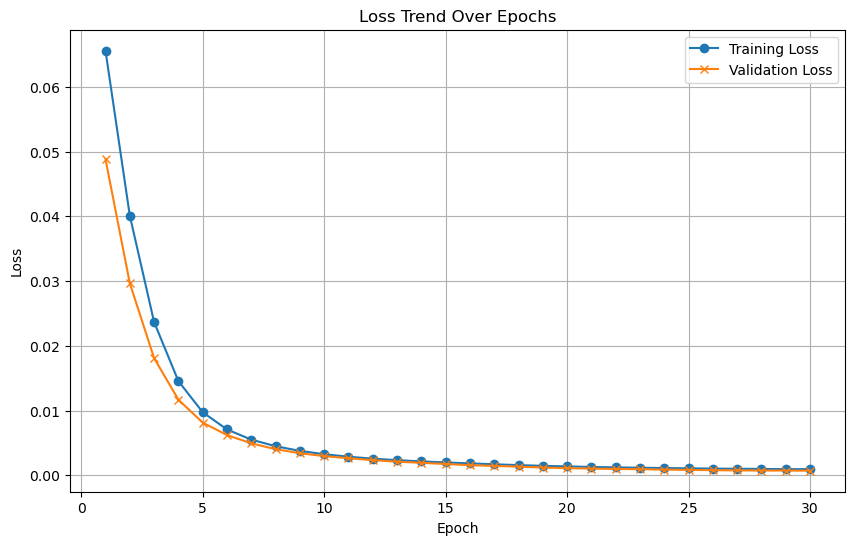

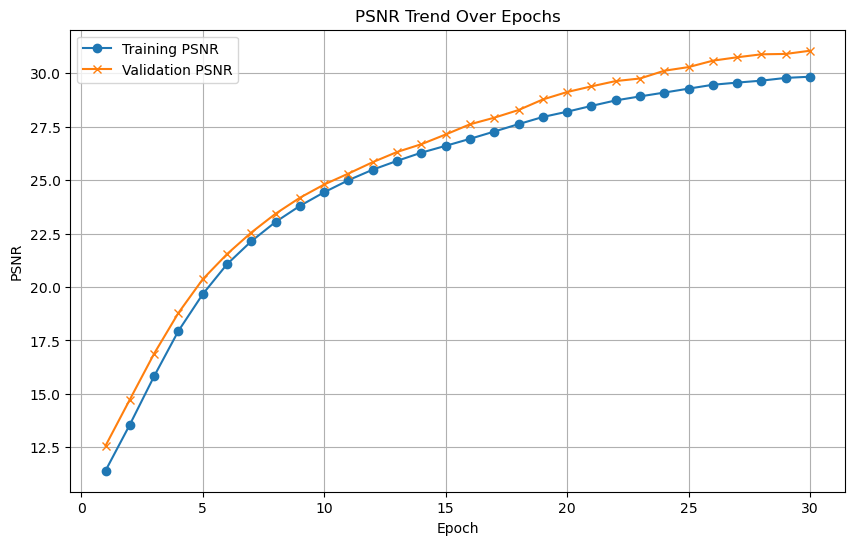

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7913
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7793. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7519
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7348
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7117
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [7/1000] completed, Average Training Loss: 2.6870
    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6814
    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6718
    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6607
    Validation Batch [1/1], Loss: 2.7796
Validation Loss: 2.7796, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6509
    Validation Batch

Epoch [18/1000] completed, Average Training Loss: 2.5949
    Validation Batch [1/1], Loss: 2.7805
Validation Loss: 2.7805, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5934
    Validation Batch [1/1], Loss: 2.7805
Validation Loss: 2.7805, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5708
    Validation Batch [1/1], Loss: 2.7806
Validation Loss: 2.7806, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5668
    Validation Batch [1/1], Loss: 2.7807
Validation Loss: 2.7807, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.5523
    Validat

Epoch [33/1000] completed, Average Training Loss: 2.4687
    Validation Batch [1/1], Loss: 2.7765
Validation Loss: 2.7765, Validation Accuracy: 6.25%
Validation loss improved from 2.7776 to 2.7765. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.4583
    Validation Batch [1/1], Loss: 2.7751
Validation Loss: 2.7751, Validation Accuracy: 6.25%
Validation loss improved from 2.7765 to 2.7751. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 2.4720
    Validation Batch [1/1], Loss: 2.7732
Validation Loss: 2.7732, Validation Accuracy: 6.25%
Validation loss improved from 2.7751 to 2.7732. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 2.4563
    Validation Batch [1/1], Loss: 2.7715
Validation Loss: 2.7715, Validation Accuracy: 6.25%
Validation loss improved from 2.7732 to 2.7715. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/10

Epoch [42/1000] completed, Average Training Loss: 2.3990
    Validation Batch [1/1], Loss: 2.7449
Validation Loss: 2.7449, Validation Accuracy: 6.25%
Validation loss improved from 2.7508 to 2.7449. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.3975
    Validation Batch [1/1], Loss: 2.7393
Validation Loss: 2.7393, Validation Accuracy: 6.25%
Validation loss improved from 2.7449 to 2.7393. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.3650
    Validation Batch [1/1], Loss: 2.7317
Validation Loss: 2.7317, Validation Accuracy: 6.25%
Validation loss improved from 2.7393 to 2.7317. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 2.3559
    Validation Batch [1/1], Loss: 2.7176
Validation Loss: 2.7176, Validation Accuracy: 6.25%
Validation loss improved from 2.7317 to 2.7176. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/10

    Validation Batch [1/1], Loss: 2.5615
Validation Loss: 2.5615, Validation Accuracy: 23.75%
Validation loss improved from 2.5783 to 2.5615. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 2.2567
    Validation Batch [1/1], Loss: 2.5459
Validation Loss: 2.5459, Validation Accuracy: 23.75%
Validation loss improved from 2.5615 to 2.5459. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 2.2026
    Validation Batch [1/1], Loss: 2.5330
Validation Loss: 2.5330, Validation Accuracy: 22.50%
Validation loss improved from 2.5459 to 2.5330. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.2733
    Validation Batch [1/1], Loss: 2.5247
Validation Loss: 2.5247, Validation Accuracy: 18.75%
Validation loss improved from 2.5330 to 2.5247. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.2001
    Vali

Epoch [67/1000] completed, Average Training Loss: 2.1625
    Validation Batch [1/1], Loss: 2.4581
Validation Loss: 2.4581, Validation Accuracy: 25.00%
Validation loss improved from 2.4618 to 2.4581. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 2.1357
    Validation Batch [1/1], Loss: 2.4539
Validation Loss: 2.4539, Validation Accuracy: 25.00%
Validation loss improved from 2.4581 to 2.4539. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 2.1921
    Validation Batch [1/1], Loss: 2.4360
Validation Loss: 2.4360, Validation Accuracy: 25.00%
Validation loss improved from 2.4539 to 2.4360. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 2.1338
    Validation Batch [1/1], Loss: 2.4150
Validation Loss: 2.4150, Validation Accuracy: 26.25%
Validation loss improved from 2.4360 to 2.4150. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [7

Epoch [84/1000] completed, Average Training Loss: 2.0576
    Validation Batch [1/1], Loss: 2.2541
Validation Loss: 2.2541, Validation Accuracy: 40.00%
Validation loss improved from 2.2588 to 2.2541. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 2.0410
    Validation Batch [1/1], Loss: 2.2477
Validation Loss: 2.2477, Validation Accuracy: 40.00%
Validation loss improved from 2.2541 to 2.2477. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 2.0027
    Validation Batch [1/1], Loss: 2.2346
Validation Loss: 2.2346, Validation Accuracy: 42.50%
Validation loss improved from 2.2477 to 2.2346. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.9853
    Validation Batch [1/1], Loss: 2.2304
Validation Loss: 2.2304, Validation Accuracy: 40.00%
Validation loss improved from 2.2346 to 2.2304. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [8

Epoch [93/1000] completed, Average Training Loss: 1.9447
    Validation Batch [1/1], Loss: 2.2140
Validation Loss: 2.2140, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.9551
    Validation Batch [1/1], Loss: 2.1873
Validation Loss: 2.1873, Validation Accuracy: 43.75%
Validation loss improved from 2.2030 to 2.1873. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.9573
    Validation Batch [1/1], Loss: 2.1625
Validation Loss: 2.1625, Validation Accuracy: 41.25%
Validation loss improved from 2.1873 to 2.1625. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.9178
    Validation Batch [1/1], Loss: 2.1545
Validation Loss: 2.1545, Validation Accuracy: 38.75%
Validation loss improved from 2.1625 to 2.1545. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] complet

Epoch [110/1000] completed, Average Training Loss: 1.8004
    Validation Batch [1/1], Loss: 2.1202
Validation Loss: 2.1202, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.8101
    Validation Batch [1/1], Loss: 2.1378
Validation Loss: 2.1378, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7862
    Validation Batch [1/1], Loss: 2.1134
Validation Loss: 2.1134, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.8058
    Validation Batch [1/1], Loss: 2.0818
Validation Loss: 2.0818, Validation Accuracy: 42.50%
Validation loss improved from 2.0992 to 2.0818. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training 

Epoch [121/1000] completed, Average Training Loss: 1.6561
    Validation Batch [1/1], Loss: 2.0405
Validation Loss: 2.0405, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.6781
    Validation Batch [1/1], Loss: 2.0124
Validation Loss: 2.0124, Validation Accuracy: 50.00%
Validation loss improved from 2.0249 to 2.0124. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6703
    Validation Batch [1/1], Loss: 1.9970
Validation Loss: 1.9970, Validation Accuracy: 42.50%
Validation loss improved from 2.0124 to 1.9970. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6755
    Validation Batch [1/1], Loss: 1.9967
Validation Loss: 1.9967, Validation Accuracy: 41.25%
Validation loss improved from 1.9970 to 1.9967. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000

Epoch [138/1000] completed, Average Training Loss: 1.5430
    Validation Batch [1/1], Loss: 1.9468
Validation Loss: 1.9468, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.5283
    Validation Batch [1/1], Loss: 1.9319
Validation Loss: 1.9319, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.5357
    Validation Batch [1/1], Loss: 1.9044
Validation Loss: 1.9044, Validation Accuracy: 48.75%
Validation loss improved from 1.9231 to 1.9044. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.5136
    Validation Batch [1/1], Loss: 1.8809
Validation Loss: 1.8809, Validation Accuracy: 47.50%
Validation loss improved from 1.9044 to 1.8809. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Av

    Validation Batch [1/1], Loss: 1.8990
Validation Loss: 1.8990, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.4348
    Validation Batch [1/1], Loss: 1.8999
Validation Loss: 1.8999, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.4257
    Validation Batch [1/1], Loss: 1.8821
Validation Loss: 1.8821, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.4125
    Validation Batch [1/1], Loss: 1.8414
Validation Loss: 1.8414, Validation Accuracy: 61.25%
Validation loss improved from 1.8645 to 1.8414. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.4331
    Validation Batch [1/1], Loss: 1.8244
Vali

    Validation Batch [1/1], Loss: 1.7635
Validation Loss: 1.7635, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.2866
    Validation Batch [1/1], Loss: 1.7591
Validation Loss: 1.7591, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.2443
    Validation Batch [1/1], Loss: 1.7783
Validation Loss: 1.7783, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.2375
    Validation Batch [1/1], Loss: 1.7318
Validation Loss: 1.7318, Validation Accuracy: 65.00%
Validation loss improved from 1.7465 to 1.7318. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.2476
    Validation Batch [1/1], Loss: 1.7365
Vali

    Validation Batch [1/1], Loss: 1.7435
Validation Loss: 1.7435, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.1903
    Validation Batch [1/1], Loss: 1.7599
Validation Loss: 1.7599, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.1984
    Validation Batch [1/1], Loss: 1.7355
Validation Loss: 1.7355, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 1.2039
    Validation Batch [1/1], Loss: 1.6938
Validation Loss: 1.6938, Validation Accuracy: 65.00%
Validation loss improved from 1.7135 to 1.6938. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.1258
    Validation Batch [1/1], Loss: 1.6803
Vali

Epoch [190/1000] completed, Average Training Loss: 1.0600
    Validation Batch [1/1], Loss: 1.5887
Validation Loss: 1.5887, Validation Accuracy: 57.50%
Validation loss improved from 1.5955 to 1.5887. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 1.0489
    Validation Batch [1/1], Loss: 1.6414
Validation Loss: 1.6414, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 1.0024
    Validation Batch [1/1], Loss: 1.6346
Validation Loss: 1.6346, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 1.0945
    Validation Batch [1/1], Loss: 1.5985
Validation Loss: 1.5985, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training 

Epoch [202/1000] completed, Average Training Loss: 0.9391
    Validation Batch [1/1], Loss: 1.5641
Validation Loss: 1.5641, Validation Accuracy: 65.00%
Validation loss improved from 1.5712 to 1.5641. Saving model...

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.9461
    Validation Batch [1/1], Loss: 1.5906
Validation Loss: 1.5906, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.9163
    Validation Batch [1/1], Loss: 1.5803
Validation Loss: 1.5803, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.9373
    Validation Batch [1/1], Loss: 1.5307
Validation Loss: 1.5307, Validation Accuracy: 63.75%
Validation loss improved from 1.5641 to 1.5307. Saving model...

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Av

Epoch [218/1000] completed, Average Training Loss: 0.8453
    Validation Batch [1/1], Loss: 1.5000
Validation Loss: 1.5000, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.8367
    Validation Batch [1/1], Loss: 1.4925
Validation Loss: 1.4925, Validation Accuracy: 66.25%
Validation loss improved from 1.4939 to 1.4925. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.8425
    Validation Batch [1/1], Loss: 1.4472
Validation Loss: 1.4472, Validation Accuracy: 61.25%
Validation loss improved from 1.4925 to 1.4472. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.8015
    Validation Batch [1/1], Loss: 1.4403
Validation Loss: 1.4403, Validation Accuracy: 62.50%
Validation loss improved from 1.4472 to 1.4403. Saving model...

LOG: Epoch [222/1000] - Training
Epoch [222/1000

Epoch [229/1000] completed, Average Training Loss: 0.7589
    Validation Batch [1/1], Loss: 1.4222
Validation Loss: 1.4222, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.7722
    Validation Batch [1/1], Loss: 1.4475
Validation Loss: 1.4475, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.7485
    Validation Batch [1/1], Loss: 1.4423
Validation Loss: 1.4423, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.7155
    Validation Batch [1/1], Loss: 1.4392
Validation Loss: 1.4392, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.6915
  

    Validation Batch [1/1], Loss: 1.3698
Validation Loss: 1.3698, Validation Accuracy: 66.25%
Validation loss improved from 1.3784 to 1.3698. Saving model...

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.6883
    Validation Batch [1/1], Loss: 1.4188
Validation Loss: 1.4188, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.6362
    Validation Batch [1/1], Loss: 1.3733
Validation Loss: 1.3733, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.6210
    Validation Batch [1/1], Loss: 1.3869
Validation Loss: 1.3869, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.6368
    Validation Batch [1/1], Loss: 1.3687
Vali

Epoch [257/1000] completed, Average Training Loss: 0.5680
    Validation Batch [1/1], Loss: 1.3777
Validation Loss: 1.3777, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5594
    Validation Batch [1/1], Loss: 1.3286
Validation Loss: 1.3286, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.5495
    Validation Batch [1/1], Loss: 1.3371
Validation Loss: 1.3371, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.5858
    Validation Batch [1/1], Loss: 1.3040
Validation Loss: 1.3040, Validation Accuracy: 63.75%
Validation loss improved from 1.3055 to 1.3040. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training 

Epoch [270/1000] completed, Average Training Loss: 0.5160
    Validation Batch [1/1], Loss: 1.3093
Validation Loss: 1.3093, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.5074
    Validation Batch [1/1], Loss: 1.2904
Validation Loss: 1.2904, Validation Accuracy: 65.00%
Validation loss improved from 1.2914 to 1.2904. Saving model...

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.5121
    Validation Batch [1/1], Loss: 1.3093
Validation Loss: 1.3093, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.4722
    Validation Batch [1/1], Loss: 1.3486
Validation Loss: 1.3486, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.3094
Validation Loss: 1.3094, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.4841
    Validation Batch [1/1], Loss: 1.2983
Validation Loss: 1.2983, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.4509
    Validation Batch [1/1], Loss: 1.3017
Validation Loss: 1.3017, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.4259
    Validation Batch [1/1], Loss: 1.3209
Validation Loss: 1.3209, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.4618
    Validation Batch [1/1], Loss: 1.4691
Validation Loss: 1.

Epoch [295/1000] completed, Average Training Loss: 0.4044
    Validation Batch [1/1], Loss: 1.2088
Validation Loss: 1.2088, Validation Accuracy: 65.00%
Validation loss improved from 1.2463 to 1.2088. Saving model...

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.4236
    Validation Batch [1/1], Loss: 1.2457
Validation Loss: 1.2457, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.3891
    Validation Batch [1/1], Loss: 1.2455
Validation Loss: 1.2455, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.3986
    Validation Batch [1/1], Loss: 1.2150
Validation Loss: 1.2150, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training 

Epoch [309/1000] completed, Average Training Loss: 0.3563
    Validation Batch [1/1], Loss: 1.2283
Validation Loss: 1.2283, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.3461
    Validation Batch [1/1], Loss: 1.2515
Validation Loss: 1.2515, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.3829
    Validation Batch [1/1], Loss: 1.2378
Validation Loss: 1.2378, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.3597
    Validation Batch [1/1], Loss: 1.2066
Validation Loss: 1.2066, Validation Accuracy: 62.50%
Validation loss improved from 1.2088 to 1.2066. Saving model...

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Traini

Epoch [322/1000] completed, Average Training Loss: 0.2990
    Validation Batch [1/1], Loss: 1.2536
Validation Loss: 1.2536, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.3288
    Validation Batch [1/1], Loss: 1.2644
Validation Loss: 1.2644, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.3030
    Validation Batch [1/1], Loss: 1.2076
Validation Loss: 1.2076, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.3123
    Validation Batch [1/1], Loss: 1.2014
Validation Loss: 1.2014, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.3433
  

Epoch [334/1000] completed, Average Training Loss: 0.2768
    Validation Batch [1/1], Loss: 1.2270
Validation Loss: 1.2270, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.2741
    Validation Batch [1/1], Loss: 1.2790
Validation Loss: 1.2790, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.2750
    Validation Batch [1/1], Loss: 1.2098
Validation Loss: 1.2098, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.2880
    Validation Batch [1/1], Loss: 1.2160
Validation Loss: 1.2160, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2747
  

Epoch [353/1000] completed, Average Training Loss: 0.2806
    Validation Batch [1/1], Loss: 1.3165
Validation Loss: 1.3165, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2542
    Validation Batch [1/1], Loss: 1.3896
Validation Loss: 1.3896, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2420
    Validation Batch [1/1], Loss: 1.3710
Validation Loss: 1.3710, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2376
    Validation Batch [1/1], Loss: 1.1910
Validation Loss: 1.1910, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.229

Epoch [362/1000] completed, Average Training Loss: 0.2189
    Validation Batch [1/1], Loss: 1.2272
Validation Loss: 1.2272, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.2242
    Validation Batch [1/1], Loss: 1.2121
Validation Loss: 1.2121, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2131
    Validation Batch [1/1], Loss: 1.1918
Validation Loss: 1.1918, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2022
    Validation Batch [1/1], Loss: 1.1513
Validation Loss: 1.1513, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2389
  

    Validation Batch [1/1], Loss: 1.3196
Validation Loss: 1.3196, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.1953
    Validation Batch [1/1], Loss: 1.1897
Validation Loss: 1.1897, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.2262
    Validation Batch [1/1], Loss: 1.1503
Validation Loss: 1.1503, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.1886
    Validation Batch [1/1], Loss: 1.1546
Validation Loss: 1.1546, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.1954
    Validation Batch [1/1], Loss: 1.1681
Validation Loss

Epoch [388/1000] completed, Average Training Loss: 0.1743
    Validation Batch [1/1], Loss: 1.1948
Validation Loss: 1.1948, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1851
    Validation Batch [1/1], Loss: 1.2337
Validation Loss: 1.2337, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1878
    Validation Batch [1/1], Loss: 1.2166
Validation Loss: 1.2166, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.1821
    Validation Batch [1/1], Loss: 1.1722
Validation Loss: 1.1722, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.175

Epoch [405/1000] completed, Average Training Loss: 0.1711
    Validation Batch [1/1], Loss: 1.1037
Validation Loss: 1.1037, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.1610
    Validation Batch [1/1], Loss: 1.0886
Validation Loss: 1.0886, Validation Accuracy: 71.25%
Validation loss improved from 1.1026 to 1.0886. Saving model...

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.1480
    Validation Batch [1/1], Loss: 1.0981
Validation Loss: 1.0981, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.1531
    Validation Batch [1/1], Loss: 1.1098
Validation Loss: 1.1098, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training 

Epoch [418/1000] completed, Average Training Loss: 0.1445
    Validation Batch [1/1], Loss: 1.1639
Validation Loss: 1.1639, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1354
    Validation Batch [1/1], Loss: 1.1735
Validation Loss: 1.1735, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1534
    Validation Batch [1/1], Loss: 1.2232
Validation Loss: 1.2232, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.1373
    Validation Batch [1/1], Loss: 1.1967
Validation Loss: 1.1967, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.150

Epoch [433/1000] completed, Average Training Loss: 0.1305
    Validation Batch [1/1], Loss: 1.1209
Validation Loss: 1.1209, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.1305
    Validation Batch [1/1], Loss: 1.1610
Validation Loss: 1.1610, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1365
    Validation Batch [1/1], Loss: 1.2219
Validation Loss: 1.2219, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1524
    Validation Batch [1/1], Loss: 1.2620
Validation Loss: 1.2620, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.109

Epoch [445/1000] completed, Average Training Loss: 0.1143
    Validation Batch [1/1], Loss: 1.1176
Validation Loss: 1.1176, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1265
    Validation Batch [1/1], Loss: 1.0942
Validation Loss: 1.0942, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1356
    Validation Batch [1/1], Loss: 1.1334
Validation Loss: 1.1334, Validation Accuracy: 66.25%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1338
    Validation Batch [1/1], Loss: 1.1687
Validation Loss: 1.1687, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.114

    Validation Batch [1/1], Loss: 1.1580
Validation Loss: 1.1580, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1123
    Validation Batch [1/1], Loss: 1.1836
Validation Loss: 1.1836, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1074
    Validation Batch [1/1], Loss: 1.1300
Validation Loss: 1.1300, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1257
    Validation Batch [1/1], Loss: 1.1303
Validation Loss: 1.1303, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.1029
    Validation Batch [1/1], Loss: 1.1213
Validation Loss

    Validation Batch [1/1], Loss: 1.1767
Validation Loss: 1.1767, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1289
    Validation Batch [1/1], Loss: 1.1975
Validation Loss: 1.1975, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1090
    Validation Batch [1/1], Loss: 1.2293
Validation Loss: 1.2293, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.1116
    Validation Batch [1/1], Loss: 1.2650
Validation Loss: 1.2650, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.1194
    Validation Batch [1/1], Loss: 1.2262
Validation Loss

    Validation Batch [1/1], Loss: 1.3797
Validation Loss: 1.3797, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.0984
    Validation Batch [1/1], Loss: 1.2199
Validation Loss: 1.2199, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training Loss: 0.1006
    Validation Batch [1/1], Loss: 1.1335
Validation Loss: 1.1335, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.1053
    Validation Batch [1/1], Loss: 1.1104
Validation Loss: 1.1104, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.1013
    Validation Batch [1/1], Loss: 1.1195
Validation Loss

Epoch [499/1000] completed, Average Training Loss: 0.1085
    Validation Batch [1/1], Loss: 1.1470
Validation Loss: 1.1470, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0782
    Validation Batch [1/1], Loss: 1.1925
Validation Loss: 1.1925, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0970
    Validation Batch [1/1], Loss: 1.2789
Validation Loss: 1.2789, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1111
    Validation Batch [1/1], Loss: 1.3953
Validation Loss: 1.3953, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.088

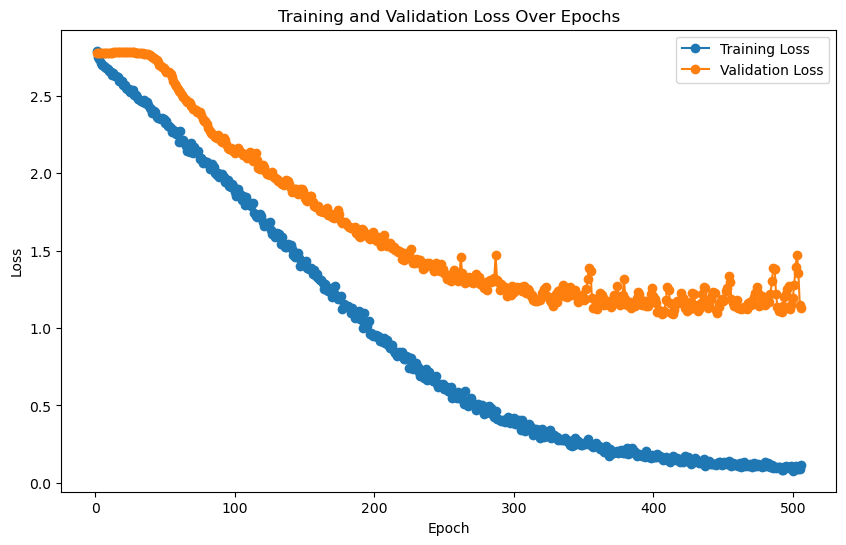

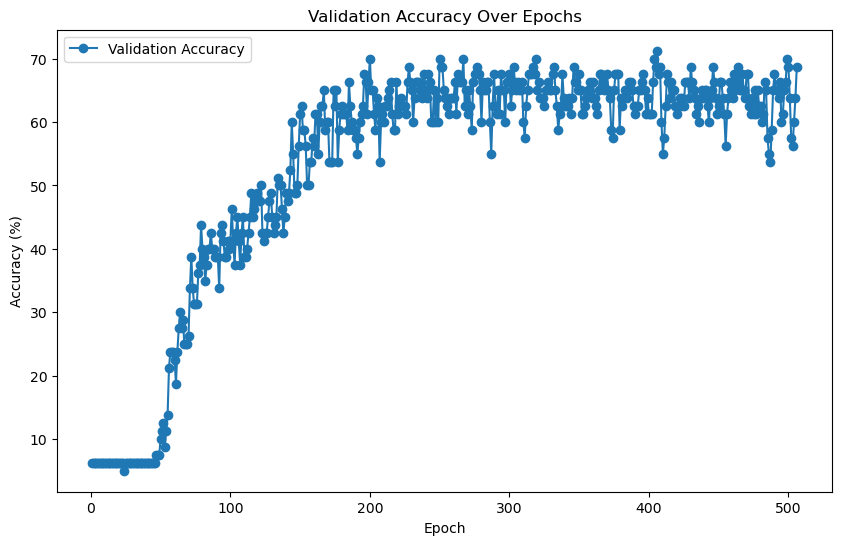


Evaluating on the test set...
    Test Batch [1/40], Loss: 2.7825

Final Test Loss: 1.4380, Test Accuracy: 61.04%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10009, 64), Test labels shape: (10009,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 46.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.27      0.60      0.38         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.50      0.20      0.29         5
           5       0.50      0.40      0.44         5
           6       0.40      0.40      0.40         5
           7       0.33      0.80      0.47         5
           8       0.83      1.

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10009, 64)
Test labels shape: (10009,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9027  |  Val Loss: 2.7942
Validation loss improved from inf to 2.7942.
[Epoch 2/1000] Train Loss: 2.7918  |  Val Loss: 2.7344
Validation loss improved from 2.7942 to 2.7344.
[Epoch 3/1000] Train Loss: 2.7216  |  Val Loss: 2.6945
Validation loss improved from 2.7344 to 2.6945.
[Epoch 4/1000] Train Loss: 2.6636  |  Val Loss: 2.6572
Validation loss improved from 2.6945 to 2.6572.
[Epoch 5/1000] Train Loss: 2.6116  |  Val Loss: 2.6220
Validation loss improved from 2.6572 to 2.6220.
[Epoch 6/1000] Train Loss: 2.5652  |  Val Loss: 2.5908
Validation loss improved from 2.6220 to 2.5908.
[Epoch 7/1000] Train Loss: 2.5181  |  Val Loss: 2.5529
Validation loss improved from 2.5908 to 2.5529.
[Epoch 8/1000] Train Loss: 2.4669  |  Val Loss: 2.5102
Validation loss improved from 2.5529 to 2.5102.
[Epoch 9/1000] Train Loss: 2.4132  |  Val Loss: 2.4710
Validation loss improved from 2.5102 to 2.4710.
[Epoch 10/1000] Train Loss: 2.3613  |  Val Loss: 2.4351
Validation loss impr

[Epoch 15/1000] Train Loss: 2.1074  |  Val Loss: 2.2308
Validation loss improved from 2.2714 to 2.2308.
[Epoch 16/1000] Train Loss: 2.0531  |  Val Loss: 2.1827
Validation loss improved from 2.2308 to 2.1827.
[Epoch 17/1000] Train Loss: 2.0019  |  Val Loss: 2.1374
Validation loss improved from 2.1827 to 2.1374.
[Epoch 18/1000] Train Loss: 1.9487  |  Val Loss: 2.0985
Validation loss improved from 2.1374 to 2.0985.
[Epoch 19/1000] Train Loss: 1.8987  |  Val Loss: 2.0679
Validation loss improved from 2.0985 to 2.0679.
[Epoch 20/1000] Train Loss: 1.8503  |  Val Loss: 2.0316
Validation loss improved from 2.0679 to 2.0316.
[Epoch 21/1000] Train Loss: 1.8065  |  Val Loss: 1.9965
Validation loss improved from 2.0316 to 1.9965.
[Epoch 22/1000] Train Loss: 1.7540  |  Val Loss: 1.9615
Validation loss improved from 1.9965 to 1.9615.


[Epoch 23/1000] Train Loss: 1.7082  |  Val Loss: 1.9310
Validation loss improved from 1.9615 to 1.9310.
[Epoch 24/1000] Train Loss: 1.6627  |  Val Loss: 1.9031
Validation loss improved from 1.9310 to 1.9031.
[Epoch 25/1000] Train Loss: 1.6180  |  Val Loss: 1.8744
Validation loss improved from 1.9031 to 1.8744.
[Epoch 26/1000] Train Loss: 1.5717  |  Val Loss: 1.8469
Validation loss improved from 1.8744 to 1.8469.
[Epoch 27/1000] Train Loss: 1.5263  |  Val Loss: 1.8224
Validation loss improved from 1.8469 to 1.8224.
[Epoch 28/1000] Train Loss: 1.4880  |  Val Loss: 1.7938
Validation loss improved from 1.8224 to 1.7938.
[Epoch 29/1000] Train Loss: 1.4451  |  Val Loss: 1.7691
Validation loss improved from 1.7938 to 1.7691.


[Epoch 30/1000] Train Loss: 1.4102  |  Val Loss: 1.7525
Validation loss improved from 1.7691 to 1.7525.
[Epoch 31/1000] Train Loss: 1.3695  |  Val Loss: 1.7390
Validation loss improved from 1.7525 to 1.7390.
[Epoch 32/1000] Train Loss: 1.3448  |  Val Loss: 1.7288
Validation loss improved from 1.7390 to 1.7288.
[Epoch 33/1000] Train Loss: 1.3104  |  Val Loss: 1.7072
Validation loss improved from 1.7288 to 1.7072.
[Epoch 34/1000] Train Loss: 1.2870  |  Val Loss: 1.6989
Validation loss improved from 1.7072 to 1.6989.
[Epoch 35/1000] Train Loss: 1.2575  |  Val Loss: 1.6810
Validation loss improved from 1.6989 to 1.6810.
[Epoch 36/1000] Train Loss: 1.2332  |  Val Loss: 1.6901
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 1.2172  |  Val Loss: 1.6545
Validation loss improved from 1.6810 to 1.6545.
[Epoch 38/1000] Train Loss: 1.1734  |  Val Loss: 1.6514
Validation loss improved from 1.6545 to 1.6514.
[Epoch 39/1000] Train Loss: 1.1529  |  Val Loss: 1.6605
!!

[Epoch 44/1000] Train Loss: 1.0470  |  Val Loss: 1.6280
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 45/1000] Train Loss: 1.0336  |  Val Loss: 1.6260
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 46/1000] Train Loss: 1.0149  |  Val Loss: 1.6233
Validation loss improved from 1.6254 to 1.6233.
[Epoch 47/1000] Train Loss: 1.0022  |  Val Loss: 1.6246
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 0.9830  |  Val Loss: 1.6204
Validation loss improved from 1.6233 to 1.6204.
[Epoch 49/1000] Train Loss: 0.9692  |  Val Loss: 1.6370
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 0.9620  |  Val Loss: 1.6334
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 51/1000] Train Loss: 0.9456  |  Val Loss: 1.6093
Validation loss improved from 1.6204 to 1.6093.


[Epoch 52/1000] Train Loss: 0.9315  |  Val Loss: 1.6094
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 0.9145  |  Val Loss: 1.6087
Validation loss improved from 1.6093 to 1.6087.
[Epoch 54/1000] Train Loss: 0.9025  |  Val Loss: 1.6105
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.9000  |  Val Loss: 1.5936
Validation loss improved from 1.6087 to 1.5936.
[Epoch 56/1000] Train Loss: 0.8696  |  Val Loss: 1.5965
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.8721  |  Val Loss: 1.6025
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 58/1000] Train Loss: 0.8527  |  Val Loss: 1.6043
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 59/1000] Train Loss: 0.8390  |  Val Loss: 1.6108
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 60/1000] Train Loss: 0.8327  |  Val Loss: 1.6137
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 61/1000] Train Loss: 0.8253  |  Val Loss: 1.6017
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 62/1000] Train Loss: 0.8192  |  Val Loss: 1.6134
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 63/1000] Train Loss: 0.8057  |  Val Loss: 1.6407
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 64/1000] Train Loss: 0.8061  |  Val Loss: 1.6551
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 65/1000] Train Loss: 0.7853  |  Val Loss: 1.5969
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 66/1000] Train Loss: 0.7834  |  Val Loss: 1.6013
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 6

[Epoch 73/1000] Train Loss: 0.7250  |  Val Loss: 1.6265
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 74/1000] Train Loss: 0.7177  |  Val Loss: 1.6480
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 75/1000] Train Loss: 0.7021  |  Val Loss: 1.6304
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 76/1000] Train Loss: 0.6803  |  Val Loss: 1.6197
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 77/1000] Train Loss: 0.6799  |  Val Loss: 1.6088
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 78/1000] Train Loss: 0.6700  |  Val Loss: 1.6263
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 79/1000] Train Loss: 0.6564  |  Val Loss: 1.6529
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 80/1000] Train Loss: 0.6572  |  Val Loss: 1.6462
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 81/1000] Train Loss: 0.6518  |  Val Loss: 1.6416
!! Validation loss did NOT improve !! Patience: 26/100
[

[Epoch 83/1000] Train Loss: 0.6315  |  Val Loss: 1.6582
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 84/1000] Train Loss: 0.6248  |  Val Loss: 1.6322
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 85/1000] Train Loss: 0.6139  |  Val Loss: 1.6184
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 86/1000] Train Loss: 0.6066  |  Val Loss: 1.6455
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 87/1000] Train Loss: 0.6063  |  Val Loss: 1.6800
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 88/1000] Train Loss: 0.5988  |  Val Loss: 1.6590
!! Validation loss did NOT improve !! Patience: 33/100


[Epoch 89/1000] Train Loss: 0.5918  |  Val Loss: 1.6411
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 90/1000] Train Loss: 0.5792  |  Val Loss: 1.6695
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 91/1000] Train Loss: 0.5917  |  Val Loss: 1.6763
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 92/1000] Train Loss: 0.5691  |  Val Loss: 1.6746
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 93/1000] Train Loss: 0.5611  |  Val Loss: 1.6714
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 94/1000] Train Loss: 0.5503  |  Val Loss: 1.6766
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 95/1000] Train Loss: 0.5504  |  Val Loss: 1.6918
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 96/1000] Train Loss: 0.5473  |  Val Loss: 1.6956
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 97/1000] Train Loss: 0.5449  |  Val Loss: 1.7154
!! Validation loss did NOT improve !! Patience: 42/100
[

[Epoch 103/1000] Train Loss: 0.5030  |  Val Loss: 1.7570
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 104/1000] Train Loss: 0.5127  |  Val Loss: 1.7458
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 105/1000] Train Loss: 0.4931  |  Val Loss: 1.7057
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 106/1000] Train Loss: 0.4883  |  Val Loss: 1.7118
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 107/1000] Train Loss: 0.4825  |  Val Loss: 1.7488
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 108/1000] Train Loss: 0.4772  |  Val Loss: 1.7373
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 109/1000] Train Loss: 0.4678  |  Val Loss: 1.7411
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 110/1000] Train Loss: 0.4707  |  Val Loss: 1.7669
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 111/1000] Train Loss: 0.4602  |  Val Loss: 1.7589
!! Validation loss did NOT improve !! Patience:

[Epoch 115/1000] Train Loss: 0.4437  |  Val Loss: 1.7807
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 116/1000] Train Loss: 0.4423  |  Val Loss: 1.7837
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 117/1000] Train Loss: 0.4405  |  Val Loss: 1.7882
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 118/1000] Train Loss: 0.4269  |  Val Loss: 1.7913
!! Validation loss did NOT improve !! Patience: 63/100


[Epoch 119/1000] Train Loss: 0.4258  |  Val Loss: 1.8163
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 120/1000] Train Loss: 0.4305  |  Val Loss: 1.8290
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 121/1000] Train Loss: 0.4186  |  Val Loss: 1.8381
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 122/1000] Train Loss: 0.4104  |  Val Loss: 1.8319
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 123/1000] Train Loss: 0.4042  |  Val Loss: 1.8136
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 124/1000] Train Loss: 0.4036  |  Val Loss: 1.8322
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 125/1000] Train Loss: 0.3969  |  Val Loss: 1.8493
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 126/1000] Train Loss: 0.3933  |  Val Loss: 1.8643
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 127/1000] Train Loss: 0.3947  |  Val Loss: 1.8750
!! Validation loss did NOT improve !! Patience:

[Epoch 130/1000] Train Loss: 0.3813  |  Val Loss: 1.8642
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 131/1000] Train Loss: 0.3760  |  Val Loss: 1.8909
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 132/1000] Train Loss: 0.3743  |  Val Loss: 1.9083
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 133/1000] Train Loss: 0.3705  |  Val Loss: 1.8799
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 134/1000] Train Loss: 0.3706  |  Val Loss: 1.8667
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 135/1000] Train Loss: 0.3713  |  Val Loss: 1.9083
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 136/1000] Train Loss: 0.3582  |  Val Loss: 1.9014
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 137/1000] Train Loss: 0.3644  |  Val Loss: 1.9110
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 138/1000] Train Loss: 0.3542  |  Val Loss: 1.9475
!! Validation loss did NOT improve !! Patience:

[Epoch 144/1000] Train Loss: 0.3407  |  Val Loss: 1.9412
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 145/1000] Train Loss: 0.3351  |  Val Loss: 1.9622
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 146/1000] Train Loss: 0.3309  |  Val Loss: 1.9701
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 147/1000] Train Loss: 0.3285  |  Val Loss: 1.9743
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 148/1000] Train Loss: 0.3194  |  Val Loss: 1.9824
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 149/1000] Train Loss: 0.3155  |  Val Loss: 1.9883
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 150/1000] Train Loss: 0.3147  |  Val Loss: 1.9817
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 151/1000] Train Loss: 0.3119  |  Val Loss: 1.9884
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 152/1000] Train Loss: 0.3085  |  Val Loss: 2.0091
!! Validation loss did NOT improve !! Patience:

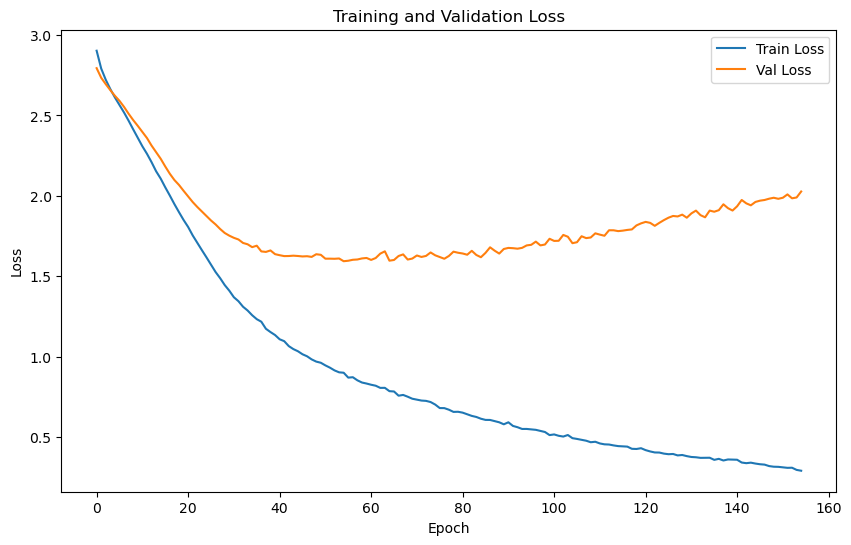

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.2731 | Test Accuracy: 47.89%


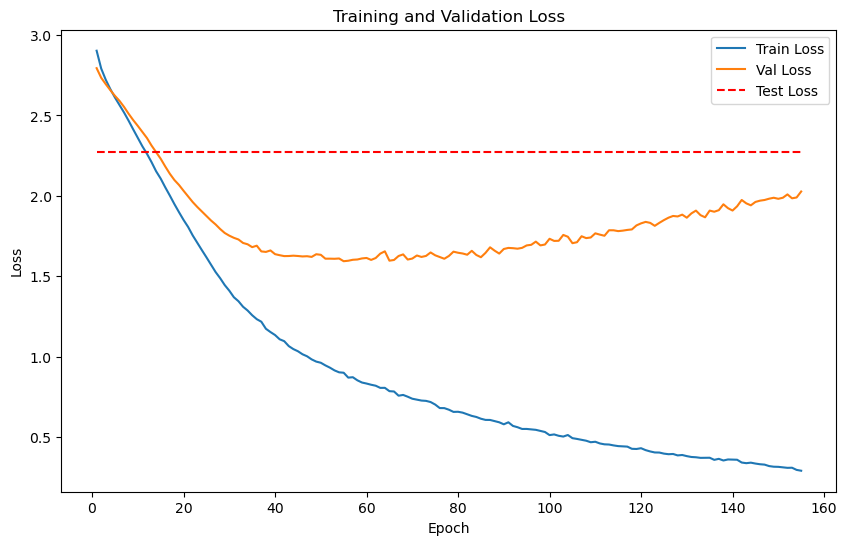

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.4157
Epoch [1/2000], Avg Train Loss: 9.4157
Epoch [1/2000], Avg Val Loss: 5.1102
Validation loss improved from inf to 5.1102. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.0314
Epoch [2/2000], Avg Train Loss: 9.0314
Epoch [2/2000], Avg Val Loss: 5.0596
Validation loss improved from 5.1102 to 5.0596. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.8719
Epoch [3/2000], Avg Train Loss: 8.8719
Epoch [3/2000], Avg Val Loss: 5.0105
Validation loss improved from 5.0596 to 5.0105. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.1692
Epoch [4/2000], Avg Train Loss: 9.1692
Epoch [4/2000], Avg Val Loss: 4.9622
Validation loss improved from 5.0105 to 4.9622. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.8260
Epoch [5/2000], Avg Train Loss: 8.8260
Epoch [5/2000], Avg Val Loss: 4.9151
Validation loss improved from 4.9622 to 4.9151. Saving mode

    Batch [1/1], Train Loss: 8.0298
Epoch [17/2000], Avg Train Loss: 8.0298
Epoch [17/2000], Avg Val Loss: 4.4361
Validation loss improved from 4.4700 to 4.4361. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.8561
Epoch [18/2000], Avg Train Loss: 7.8561
Epoch [18/2000], Avg Val Loss: 4.4030
Validation loss improved from 4.4361 to 4.4030. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.8437
Epoch [19/2000], Avg Train Loss: 7.8437
Epoch [19/2000], Avg Val Loss: 4.3709
Validation loss improved from 4.4030 to 4.3709. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.8714
Epoch [20/2000], Avg Train Loss: 7.8714
Epoch [20/2000], Avg Val Loss: 4.3398
Validation loss improved from 4.3709 to 4.3398. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.6961
Epoch [21/2000], Avg Train Loss: 7.6961
Epoch [21/2000], Avg Val Loss: 4.3096
Validation loss improved from 4.3398 to 4.

    Batch [1/1], Train Loss: 7.1639
Epoch [30/2000], Avg Train Loss: 7.1639
Epoch [30/2000], Avg Val Loss: 4.0779
Validation loss improved from 4.1003 to 4.0779. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 7.0545
Epoch [31/2000], Avg Train Loss: 7.0545
Epoch [31/2000], Avg Val Loss: 4.0564
Validation loss improved from 4.0779 to 4.0564. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 7.0864
Epoch [32/2000], Avg Train Loss: 7.0864
Epoch [32/2000], Avg Val Loss: 4.0356
Validation loss improved from 4.0564 to 4.0356. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 7.0611
Epoch [33/2000], Avg Train Loss: 7.0611
Epoch [33/2000], Avg Val Loss: 4.0157
Validation loss improved from 4.0356 to 4.0157. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.9796
Epoch [34/2000], Avg Train Loss: 6.9796
Epoch [34/2000], Avg Val Loss: 3.9965
Validation loss improved from 4.0157 to 3.

    Batch [1/1], Train Loss: 6.3006
Epoch [45/2000], Avg Train Loss: 6.3006
Epoch [45/2000], Avg Val Loss: 3.8302
Validation loss improved from 3.8422 to 3.8302. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.2276
Epoch [46/2000], Avg Train Loss: 6.2276
Epoch [46/2000], Avg Val Loss: 3.8187
Validation loss improved from 3.8302 to 3.8187. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.2552
Epoch [47/2000], Avg Train Loss: 6.2552
Epoch [47/2000], Avg Val Loss: 3.8078
Validation loss improved from 3.8187 to 3.8078. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.1490
Epoch [48/2000], Avg Train Loss: 6.1490
Epoch [48/2000], Avg Val Loss: 3.7974
Validation loss improved from 3.8078 to 3.7974. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.1781
Epoch [49/2000], Avg Train Loss: 6.1781
Epoch [49/2000], Avg Val Loss: 3.7875
Validation loss improved from 3.7974 to 3.

    Batch [1/1], Train Loss: 5.7288
Epoch [60/2000], Avg Train Loss: 5.7288
Epoch [60/2000], Avg Val Loss: 3.7052
Validation loss improved from 3.7109 to 3.7052. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.8095
Epoch [61/2000], Avg Train Loss: 5.8095
Epoch [61/2000], Avg Val Loss: 3.6998
Validation loss improved from 3.7052 to 3.6998. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.7093
Epoch [62/2000], Avg Train Loss: 5.7093
Epoch [62/2000], Avg Val Loss: 3.6946
Validation loss improved from 3.6998 to 3.6946. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.6942
Epoch [63/2000], Avg Train Loss: 5.6942
Epoch [63/2000], Avg Val Loss: 3.6896
Validation loss improved from 3.6946 to 3.6896. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.6179
Epoch [64/2000], Avg Train Loss: 5.6179
Epoch [64/2000], Avg Val Loss: 3.6849
Validation loss improved from 3.6896 to 3.

    Batch [1/1], Train Loss: 5.3859
Epoch [73/2000], Avg Train Loss: 5.3859
Epoch [73/2000], Avg Val Loss: 3.6524
Validation loss improved from 3.6553 to 3.6524. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.5216
Epoch [74/2000], Avg Train Loss: 5.5216
Epoch [74/2000], Avg Val Loss: 3.6498
Validation loss improved from 3.6524 to 3.6498. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.3296
Epoch [75/2000], Avg Train Loss: 5.3296
Epoch [75/2000], Avg Val Loss: 3.6472
Validation loss improved from 3.6498 to 3.6472. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.2523
Epoch [76/2000], Avg Train Loss: 5.2523
Epoch [76/2000], Avg Val Loss: 3.6449
Validation loss improved from 3.6472 to 3.6449. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.2960
Epoch [77/2000], Avg Train Loss: 5.2960
Epoch [77/2000], Avg Val Loss: 3.6426
Validation loss improved from 3.6449 to 3.

Epoch [87/2000], Avg Val Loss: 3.6248
Validation loss improved from 3.6262 to 3.6248. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.1704
Epoch [88/2000], Avg Train Loss: 5.1704
Epoch [88/2000], Avg Val Loss: 3.6234
Validation loss improved from 3.6248 to 3.6234. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.0909
Epoch [89/2000], Avg Train Loss: 5.0909
Epoch [89/2000], Avg Val Loss: 3.6221
Validation loss improved from 3.6234 to 3.6221. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.1615
Epoch [90/2000], Avg Train Loss: 5.1615
Epoch [90/2000], Avg Val Loss: 3.6210
Validation loss improved from 3.6221 to 3.6210. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.0567
Epoch [91/2000], Avg Train Loss: 5.0567
Epoch [91/2000], Avg Val Loss: 3.6198
Validation loss improved from 3.6210 to 3.6198. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.9501
Epoch [107/2000], Avg Train Loss: 4.9501
Epoch [107/2000], Avg Val Loss: 3.6061
Validation loss improved from 3.6068 to 3.6061. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.9788
Epoch [108/2000], Avg Train Loss: 4.9788
Epoch [108/2000], Avg Val Loss: 3.6054
Validation loss improved from 3.6061 to 3.6054. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.9248
Epoch [109/2000], Avg Train Loss: 4.9248
Epoch [109/2000], Avg Val Loss: 3.6047
Validation loss improved from 3.6054 to 3.6047. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.9003
Epoch [110/2000], Avg Train Loss: 4.9003
Epoch [110/2000], Avg Val Loss: 3.6040
Validation loss improved from 3.6047 to 3.6040. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.9116
Epoch [111/2000], Avg Train Loss: 4.9116
Epoch [111/2000], Avg Val Loss: 3.6033
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7736
Epoch [118/2000], Avg Train Loss: 4.7736
Epoch [118/2000], Avg Val Loss: 3.5987
Validation loss improved from 3.5993 to 3.5987. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.9434
Epoch [119/2000], Avg Train Loss: 4.9434
Epoch [119/2000], Avg Val Loss: 3.5981
Validation loss improved from 3.5987 to 3.5981. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.8853
Epoch [120/2000], Avg Train Loss: 4.8853
Epoch [120/2000], Avg Val Loss: 3.5975
Validation loss improved from 3.5981 to 3.5975. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.8492
Epoch [121/2000], Avg Train Loss: 4.8492
Epoch [121/2000], Avg Val Loss: 3.5969
Validation loss improved from 3.5975 to 3.5969. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.7974
Epoch [122/2000], Avg Train Loss: 4.7974
Epoch [122/2000], Avg Val Loss: 3.5962
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7758
Epoch [130/2000], Avg Train Loss: 4.7758
Epoch [130/2000], Avg Val Loss: 3.5910
Validation loss improved from 3.5917 to 3.5910. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.6986
Epoch [131/2000], Avg Train Loss: 4.6986
Epoch [131/2000], Avg Val Loss: 3.5903
Validation loss improved from 3.5910 to 3.5903. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.7759
Epoch [132/2000], Avg Train Loss: 4.7759
Epoch [132/2000], Avg Val Loss: 3.5896
Validation loss improved from 3.5903 to 3.5896. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.7941
Epoch [133/2000], Avg Train Loss: 4.7941
Epoch [133/2000], Avg Val Loss: 3.5890
Validation loss improved from 3.5896 to 3.5890. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.7419
Epoch [134/2000], Avg Train Loss: 4.7419
Epoch [134/2000], Avg Val Loss: 3.5883
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7192
Epoch [147/2000], Avg Train Loss: 4.7192
Epoch [147/2000], Avg Val Loss: 3.5801
Validation loss improved from 3.5808 to 3.5801. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.6241
Epoch [148/2000], Avg Train Loss: 4.6241
Epoch [148/2000], Avg Val Loss: 3.5795
Validation loss improved from 3.5801 to 3.5795. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.6578
Epoch [149/2000], Avg Train Loss: 4.6578
Epoch [149/2000], Avg Val Loss: 3.5788
Validation loss improved from 3.5795 to 3.5788. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.6871
Epoch [150/2000], Avg Train Loss: 4.6871
Epoch [150/2000], Avg Val Loss: 3.5782
Validation loss improved from 3.5788 to 3.5782. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.6281
Epoch [151/2000], Avg Train Loss: 4.6281
Epoch [151/2000], Avg Val Loss: 3.5775
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6447
Epoch [158/2000], Avg Train Loss: 4.6447
Epoch [158/2000], Avg Val Loss: 3.5727
Validation loss improved from 3.5734 to 3.5727. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.7112
Epoch [159/2000], Avg Train Loss: 4.7112
Epoch [159/2000], Avg Val Loss: 3.5721
Validation loss improved from 3.5727 to 3.5721. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.6282
Epoch [160/2000], Avg Train Loss: 4.6282
Epoch [160/2000], Avg Val Loss: 3.5715
Validation loss improved from 3.5721 to 3.5715. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.6488
Epoch [161/2000], Avg Train Loss: 4.6488
Epoch [161/2000], Avg Val Loss: 3.5708
Validation loss improved from 3.5715 to 3.5708. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.6139
Epoch [162/2000], Avg Train Loss: 4.6139
Epoch [162/2000], Avg Val Loss: 3.5700
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5917
Epoch [174/2000], Avg Train Loss: 4.5917
Epoch [174/2000], Avg Val Loss: 3.5612
Validation loss improved from 3.5620 to 3.5612. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.5946
Epoch [175/2000], Avg Train Loss: 4.5946
Epoch [175/2000], Avg Val Loss: 3.5605
Validation loss improved from 3.5612 to 3.5605. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.6086
Epoch [176/2000], Avg Train Loss: 4.6086
Epoch [176/2000], Avg Val Loss: 3.5597
Validation loss improved from 3.5605 to 3.5597. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.5865
Epoch [177/2000], Avg Train Loss: 4.5865
Epoch [177/2000], Avg Val Loss: 3.5590
Validation loss improved from 3.5597 to 3.5590. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.6167
Epoch [178/2000], Avg Train Loss: 4.6167
Epoch [178/2000], Avg Val Loss: 3.5583
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5457
Epoch [192/2000], Avg Train Loss: 4.5457
Epoch [192/2000], Avg Val Loss: 3.5475
Validation loss improved from 3.5483 to 3.5475. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.6061
Epoch [193/2000], Avg Train Loss: 4.6061
Epoch [193/2000], Avg Val Loss: 3.5468
Validation loss improved from 3.5475 to 3.5468. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.5379
Epoch [194/2000], Avg Train Loss: 4.5379
Epoch [194/2000], Avg Val Loss: 3.5460
Validation loss improved from 3.5468 to 3.5460. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.5580
Epoch [195/2000], Avg Train Loss: 4.5580
Epoch [195/2000], Avg Val Loss: 3.5453
Validation loss improved from 3.5460 to 3.5453. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.5328
Epoch [196/2000], Avg Train Loss: 4.5328
Epoch [196/2000], Avg Val Loss: 3.5446
Validation loss improved fro

Epoch [197/2000], Avg Val Loss: 3.5440
Validation loss improved from 3.5446 to 3.5440. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 4.5355
Epoch [198/2000], Avg Train Loss: 4.5355
Epoch [198/2000], Avg Val Loss: 3.5433
Validation loss improved from 3.5440 to 3.5433. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 4.5141
Epoch [199/2000], Avg Train Loss: 4.5141
Epoch [199/2000], Avg Val Loss: 3.5426
Validation loss improved from 3.5433 to 3.5426. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.5654
Epoch [200/2000], Avg Train Loss: 4.5654
Epoch [200/2000], Avg Val Loss: 3.5419
Validation loss improved from 3.5426 to 3.5419. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.5447
Epoch [201/2000], Avg Train Loss: 4.5447
Epoch [201/2000], Avg Val Loss: 3.5412
Validation loss improved from 3.5419 to 3.5412. Saving model...

LOG: Epoch [202/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4687
Epoch [213/2000], Avg Train Loss: 4.4687
Epoch [213/2000], Avg Val Loss: 3.5324
Validation loss improved from 3.5331 to 3.5324. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 4.4840
Epoch [214/2000], Avg Train Loss: 4.4840
Epoch [214/2000], Avg Val Loss: 3.5317
Validation loss improved from 3.5324 to 3.5317. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 4.5126
Epoch [215/2000], Avg Train Loss: 4.5126
Epoch [215/2000], Avg Val Loss: 3.5309
Validation loss improved from 3.5317 to 3.5309. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 4.5008
Epoch [216/2000], Avg Train Loss: 4.5008
Epoch [216/2000], Avg Val Loss: 3.5302
Validation loss improved from 3.5309 to 3.5302. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 4.4240
Epoch [217/2000], Avg Train Loss: 4.4240
Epoch [217/2000], Avg Val Loss: 3.5295
Validation loss improved fro

Epoch [232/2000], Avg Val Loss: 3.5181
Validation loss improved from 3.5189 to 3.5181. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 4.4118
Epoch [233/2000], Avg Train Loss: 4.4118
Epoch [233/2000], Avg Val Loss: 3.5174
Validation loss improved from 3.5181 to 3.5174. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.4612
Epoch [234/2000], Avg Train Loss: 4.4612
Epoch [234/2000], Avg Val Loss: 3.5166
Validation loss improved from 3.5174 to 3.5166. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.4776
Epoch [235/2000], Avg Train Loss: 4.4776
Epoch [235/2000], Avg Val Loss: 3.5158
Validation loss improved from 3.5166 to 3.5158. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.4817
Epoch [236/2000], Avg Train Loss: 4.4817
Epoch [236/2000], Avg Val Loss: 3.5151
Validation loss improved from 3.5158 to 3.5151. Saving model...

LOG: Epoch [237/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4158
Epoch [242/2000], Avg Train Loss: 4.4158
Epoch [242/2000], Avg Val Loss: 3.5102
Validation loss improved from 3.5111 to 3.5102. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 4.4303
Epoch [243/2000], Avg Train Loss: 4.4303
Epoch [243/2000], Avg Val Loss: 3.5094
Validation loss improved from 3.5102 to 3.5094. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 4.3959
Epoch [244/2000], Avg Train Loss: 4.3959
Epoch [244/2000], Avg Val Loss: 3.5086
Validation loss improved from 3.5094 to 3.5086. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 4.4418
Epoch [245/2000], Avg Train Loss: 4.4418
Epoch [245/2000], Avg Val Loss: 3.5078
Validation loss improved from 3.5086 to 3.5078. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 4.3952
Epoch [246/2000], Avg Train Loss: 4.3952
Epoch [246/2000], Avg Val Loss: 3.5070
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4101
Epoch [258/2000], Avg Train Loss: 4.4101
Epoch [258/2000], Avg Val Loss: 3.4970
Validation loss improved from 3.4978 to 3.4970. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.3531
Epoch [259/2000], Avg Train Loss: 4.3531
Epoch [259/2000], Avg Val Loss: 3.4961
Validation loss improved from 3.4970 to 3.4961. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.4290
Epoch [260/2000], Avg Train Loss: 4.4290
Epoch [260/2000], Avg Val Loss: 3.4953
Validation loss improved from 3.4961 to 3.4953. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.3359
Epoch [261/2000], Avg Train Loss: 4.3359
Epoch [261/2000], Avg Val Loss: 3.4945
Validation loss improved from 3.4953 to 3.4945. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.3427
Epoch [262/2000], Avg Train Loss: 4.3427
Epoch [262/2000], Avg Val Loss: 3.4936
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3491
Epoch [276/2000], Avg Train Loss: 4.3491
Epoch [276/2000], Avg Val Loss: 3.4817
Validation loss improved from 3.4825 to 3.4817. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.4027
Epoch [277/2000], Avg Train Loss: 4.4027
Epoch [277/2000], Avg Val Loss: 3.4809
Validation loss improved from 3.4817 to 3.4809. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 4.3742
Epoch [278/2000], Avg Train Loss: 4.3742
Epoch [278/2000], Avg Val Loss: 3.4801
Validation loss improved from 3.4809 to 3.4801. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 4.3492
Epoch [279/2000], Avg Train Loss: 4.3492
Epoch [279/2000], Avg Val Loss: 3.4793
Validation loss improved from 3.4801 to 3.4793. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 4.3643
Epoch [280/2000], Avg Train Loss: 4.3643
Epoch [280/2000], Avg Val Loss: 3.4785
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2844
Epoch [289/2000], Avg Train Loss: 4.2844
Epoch [289/2000], Avg Val Loss: 3.4719
Validation loss improved from 3.4726 to 3.4719. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.3266
Epoch [290/2000], Avg Train Loss: 4.3266
Epoch [290/2000], Avg Val Loss: 3.4712
Validation loss improved from 3.4719 to 3.4712. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.3145
Epoch [291/2000], Avg Train Loss: 4.3145
Epoch [291/2000], Avg Val Loss: 3.4705
Validation loss improved from 3.4712 to 3.4705. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.3878
Epoch [292/2000], Avg Train Loss: 4.3878
Epoch [292/2000], Avg Val Loss: 3.4697
Validation loss improved from 3.4705 to 3.4697. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.2895
Epoch [293/2000], Avg Train Loss: 4.2895
Epoch [293/2000], Avg Val Loss: 3.4690
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3038
Epoch [300/2000], Avg Train Loss: 4.3038
Epoch [300/2000], Avg Val Loss: 3.4637
Validation loss improved from 3.4645 to 3.4637. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.2966
Epoch [301/2000], Avg Train Loss: 4.2966
Epoch [301/2000], Avg Val Loss: 3.4629
Validation loss improved from 3.4637 to 3.4629. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.3129
Epoch [302/2000], Avg Train Loss: 4.3129
Epoch [302/2000], Avg Val Loss: 3.4621
Validation loss improved from 3.4629 to 3.4621. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 4.3110
Epoch [303/2000], Avg Train Loss: 4.3110
Epoch [303/2000], Avg Val Loss: 3.4613
Validation loss improved from 3.4621 to 3.4613. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.2932
Epoch [304/2000], Avg Train Loss: 4.2932
Epoch [304/2000], Avg Val Loss: 3.4605
Validation loss improved fro

Epoch [318/2000], Avg Val Loss: 3.4505
Validation loss improved from 3.4512 to 3.4505. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 4.3226
Epoch [319/2000], Avg Train Loss: 4.3226
Epoch [319/2000], Avg Val Loss: 3.4498
Validation loss improved from 3.4505 to 3.4498. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.2494
Epoch [320/2000], Avg Train Loss: 4.2494
Epoch [320/2000], Avg Val Loss: 3.4491
Validation loss improved from 3.4498 to 3.4491. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.2354
Epoch [321/2000], Avg Train Loss: 4.2354
Epoch [321/2000], Avg Val Loss: 3.4483
Validation loss improved from 3.4491 to 3.4483. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.2823
Epoch [322/2000], Avg Train Loss: 4.2823
Epoch [322/2000], Avg Val Loss: 3.4476
Validation loss improved from 3.4483 to 3.4476. Saving model...

LOG: Epoch [323/2000] - Training
    Bat

Epoch [330/2000], Avg Val Loss: 3.4420
Validation loss improved from 3.4427 to 3.4420. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.2740
Epoch [331/2000], Avg Train Loss: 4.2740
Epoch [331/2000], Avg Val Loss: 3.4413
Validation loss improved from 3.4420 to 3.4413. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 4.2622
Epoch [332/2000], Avg Train Loss: 4.2622
Epoch [332/2000], Avg Val Loss: 3.4407
Validation loss improved from 3.4413 to 3.4407. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 4.3023
Epoch [333/2000], Avg Train Loss: 4.3023
Epoch [333/2000], Avg Val Loss: 3.4400
Validation loss improved from 3.4407 to 3.4400. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 4.2697
Epoch [334/2000], Avg Train Loss: 4.2697
Epoch [334/2000], Avg Val Loss: 3.4393
Validation loss improved from 3.4400 to 3.4393. Saving model...

LOG: Epoch [335/2000] - Training
    Bat

Epoch [341/2000], Avg Val Loss: 3.4343
Validation loss improved from 3.4351 to 3.4343. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.1988
Epoch [342/2000], Avg Train Loss: 4.1988
Epoch [342/2000], Avg Val Loss: 3.4336
Validation loss improved from 3.4343 to 3.4336. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 4.2737
Epoch [343/2000], Avg Train Loss: 4.2737
Epoch [343/2000], Avg Val Loss: 3.4330
Validation loss improved from 3.4336 to 3.4330. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.2756
Epoch [344/2000], Avg Train Loss: 4.2756
Epoch [344/2000], Avg Val Loss: 3.4323
Validation loss improved from 3.4330 to 3.4323. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 4.2747
Epoch [345/2000], Avg Train Loss: 4.2747
Epoch [345/2000], Avg Val Loss: 3.4317
Validation loss improved from 3.4323 to 3.4317. Saving model...

LOG: Epoch [346/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2047
Epoch [359/2000], Avg Train Loss: 4.2047
Epoch [359/2000], Avg Val Loss: 3.4236
Validation loss improved from 3.4241 to 3.4236. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 4.2401
Epoch [360/2000], Avg Train Loss: 4.2401
Epoch [360/2000], Avg Val Loss: 3.4231
Validation loss improved from 3.4236 to 3.4231. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.1372
Epoch [361/2000], Avg Train Loss: 4.1372
Epoch [361/2000], Avg Val Loss: 3.4226
Validation loss improved from 3.4231 to 3.4226. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 4.1904
Epoch [362/2000], Avg Train Loss: 4.1904
Epoch [362/2000], Avg Val Loss: 3.4220
Validation loss improved from 3.4226 to 3.4220. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 4.1963
Epoch [363/2000], Avg Train Loss: 4.1963
Epoch [363/2000], Avg Val Loss: 3.4215
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2297
Epoch [375/2000], Avg Train Loss: 4.2297
Epoch [375/2000], Avg Val Loss: 3.4145
Validation loss improved from 3.4150 to 3.4145. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.1957
Epoch [376/2000], Avg Train Loss: 4.1957
Epoch [376/2000], Avg Val Loss: 3.4140
Validation loss improved from 3.4145 to 3.4140. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.2007
Epoch [377/2000], Avg Train Loss: 4.2007
Epoch [377/2000], Avg Val Loss: 3.4135
Validation loss improved from 3.4140 to 3.4135. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.1889
Epoch [378/2000], Avg Train Loss: 4.1889
Epoch [378/2000], Avg Val Loss: 3.4129
Validation loss improved from 3.4135 to 3.4129. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.1447
Epoch [379/2000], Avg Train Loss: 4.1447
Epoch [379/2000], Avg Val Loss: 3.4124
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1641
Epoch [385/2000], Avg Train Loss: 4.1641
Epoch [385/2000], Avg Val Loss: 3.4089
Validation loss improved from 3.4095 to 3.4089. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.1485
Epoch [386/2000], Avg Train Loss: 4.1485
Epoch [386/2000], Avg Val Loss: 3.4083
Validation loss improved from 3.4089 to 3.4083. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.1870
Epoch [387/2000], Avg Train Loss: 4.1870
Epoch [387/2000], Avg Val Loss: 3.4077
Validation loss improved from 3.4083 to 3.4077. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.2071
Epoch [388/2000], Avg Train Loss: 4.2071
Epoch [388/2000], Avg Val Loss: 3.4070
Validation loss improved from 3.4077 to 3.4070. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 4.1872
Epoch [389/2000], Avg Train Loss: 4.1872
Epoch [389/2000], Avg Val Loss: 3.4064
Validation loss improved fro

Epoch [395/2000], Avg Val Loss: 3.4035
Validation loss improved from 3.4039 to 3.4035. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 4.1318
Epoch [396/2000], Avg Train Loss: 4.1318
Epoch [396/2000], Avg Val Loss: 3.4031
Validation loss improved from 3.4035 to 3.4031. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 4.1976
Epoch [397/2000], Avg Train Loss: 4.1976
Epoch [397/2000], Avg Val Loss: 3.4027
Validation loss improved from 3.4031 to 3.4027. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.1896
Epoch [398/2000], Avg Train Loss: 4.1896
Epoch [398/2000], Avg Val Loss: 3.4022
Validation loss improved from 3.4027 to 3.4022. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 4.1514
Epoch [399/2000], Avg Train Loss: 4.1514
Epoch [399/2000], Avg Val Loss: 3.4018
Validation loss improved from 3.4022 to 3.4018. Saving model...

LOG: Epoch [400/2000] - Training
    Bat

Epoch [414/2000], Avg Val Loss: 3.3950
Validation loss improved from 3.3954 to 3.3950. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.1036
Epoch [415/2000], Avg Train Loss: 4.1036
Epoch [415/2000], Avg Val Loss: 3.3945
Validation loss improved from 3.3950 to 3.3945. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 4.1543
Epoch [416/2000], Avg Train Loss: 4.1543
Epoch [416/2000], Avg Val Loss: 3.3941
Validation loss improved from 3.3945 to 3.3941. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 4.1149
Epoch [417/2000], Avg Train Loss: 4.1149
Epoch [417/2000], Avg Val Loss: 3.3936
Validation loss improved from 3.3941 to 3.3936. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 4.1547
Epoch [418/2000], Avg Train Loss: 4.1547
Epoch [418/2000], Avg Val Loss: 3.3931
Validation loss improved from 3.3936 to 3.3931. Saving model...

LOG: Epoch [419/2000] - Training
    Bat

Epoch [426/2000], Avg Val Loss: 3.3889
Validation loss improved from 3.3894 to 3.3889. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.1420
Epoch [427/2000], Avg Train Loss: 4.1420
Epoch [427/2000], Avg Val Loss: 3.3884
Validation loss improved from 3.3889 to 3.3884. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.1454
Epoch [428/2000], Avg Train Loss: 4.1454
Epoch [428/2000], Avg Val Loss: 3.3879
Validation loss improved from 3.3884 to 3.3879. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.0976
Epoch [429/2000], Avg Train Loss: 4.0976
Epoch [429/2000], Avg Val Loss: 3.3873
Validation loss improved from 3.3879 to 3.3873. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.2177
Epoch [430/2000], Avg Train Loss: 4.2177
Epoch [430/2000], Avg Val Loss: 3.3869
Validation loss improved from 3.3873 to 3.3869. Saving model...

LOG: Epoch [431/2000] - Training
    Bat

Epoch [439/2000], Avg Val Loss: 3.3824
Validation loss improved from 3.3829 to 3.3824. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 4.1091
Epoch [440/2000], Avg Train Loss: 4.1091
Epoch [440/2000], Avg Val Loss: 3.3820
Validation loss improved from 3.3824 to 3.3820. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.1054
Epoch [441/2000], Avg Train Loss: 4.1054
Epoch [441/2000], Avg Val Loss: 3.3816
Validation loss improved from 3.3820 to 3.3816. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.0721
Epoch [442/2000], Avg Train Loss: 4.0721
Epoch [442/2000], Avg Val Loss: 3.3812
Validation loss improved from 3.3816 to 3.3812. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.0985
Epoch [443/2000], Avg Train Loss: 4.0985
Epoch [443/2000], Avg Val Loss: 3.3807
Validation loss improved from 3.3812 to 3.3807. Saving model...

LOG: Epoch [444/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0944
Epoch [458/2000], Avg Train Loss: 4.0944
Epoch [458/2000], Avg Val Loss: 3.3752
Validation loss improved from 3.3755 to 3.3752. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 4.1155
Epoch [459/2000], Avg Train Loss: 4.1155
Epoch [459/2000], Avg Val Loss: 3.3748
Validation loss improved from 3.3752 to 3.3748. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.0675
Epoch [460/2000], Avg Train Loss: 4.0675
Epoch [460/2000], Avg Val Loss: 3.3744
Validation loss improved from 3.3748 to 3.3744. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.0970
Epoch [461/2000], Avg Train Loss: 4.0970
Epoch [461/2000], Avg Val Loss: 3.3741
Validation loss improved from 3.3744 to 3.3741. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.1263
Epoch [462/2000], Avg Train Loss: 4.1263
Epoch [462/2000], Avg Val Loss: 3.3738
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0802
Epoch [471/2000], Avg Train Loss: 4.0802
Epoch [471/2000], Avg Val Loss: 3.3706
Validation loss improved from 3.3710 to 3.3706. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.0495
Epoch [472/2000], Avg Train Loss: 4.0495
Epoch [472/2000], Avg Val Loss: 3.3703
Validation loss improved from 3.3706 to 3.3703. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 4.0734
Epoch [473/2000], Avg Train Loss: 4.0734
Epoch [473/2000], Avg Val Loss: 3.3700
Validation loss improved from 3.3703 to 3.3700. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.0817
Epoch [474/2000], Avg Train Loss: 4.0817
Epoch [474/2000], Avg Val Loss: 3.3696
Validation loss improved from 3.3700 to 3.3696. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 4.0659
Epoch [475/2000], Avg Train Loss: 4.0659
Epoch [475/2000], Avg Val Loss: 3.3693
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0748
Epoch [484/2000], Avg Train Loss: 4.0748
Epoch [484/2000], Avg Val Loss: 3.3661
Validation loss improved from 3.3664 to 3.3661. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 4.0811
Epoch [485/2000], Avg Train Loss: 4.0811
Epoch [485/2000], Avg Val Loss: 3.3659
Validation loss improved from 3.3661 to 3.3659. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.0879
Epoch [486/2000], Avg Train Loss: 4.0879
Epoch [486/2000], Avg Val Loss: 3.3655
Validation loss improved from 3.3659 to 3.3655. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.0633
Epoch [487/2000], Avg Train Loss: 4.0633
Epoch [487/2000], Avg Val Loss: 3.3652
Validation loss improved from 3.3655 to 3.3652. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.0576
Epoch [488/2000], Avg Train Loss: 4.0576
Epoch [488/2000], Avg Val Loss: 3.3649
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0689
Epoch [503/2000], Avg Train Loss: 4.0689
Epoch [503/2000], Avg Val Loss: 3.3612
Validation loss improved from 3.3615 to 3.3612. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 3.9990
Epoch [504/2000], Avg Train Loss: 3.9990
Epoch [504/2000], Avg Val Loss: 3.3609
Validation loss improved from 3.3612 to 3.3609. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 4.0568
Epoch [505/2000], Avg Train Loss: 4.0568
Epoch [505/2000], Avg Val Loss: 3.3606
Validation loss improved from 3.3609 to 3.3606. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.0505
Epoch [506/2000], Avg Train Loss: 4.0505
Epoch [506/2000], Avg Val Loss: 3.3603
Validation loss improved from 3.3606 to 3.3603. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.0341
Epoch [507/2000], Avg Train Loss: 4.0341
Epoch [507/2000], Avg Val Loss: 3.3600
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0376
Epoch [515/2000], Avg Train Loss: 4.0376
Epoch [515/2000], Avg Val Loss: 3.3575
Validation loss improved from 3.3578 to 3.3575. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.0366
Epoch [516/2000], Avg Train Loss: 4.0366
Epoch [516/2000], Avg Val Loss: 3.3573
Validation loss improved from 3.3575 to 3.3573. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.0124
Epoch [517/2000], Avg Train Loss: 4.0124
Epoch [517/2000], Avg Val Loss: 3.3571
Validation loss improved from 3.3573 to 3.3571. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.9970
Epoch [518/2000], Avg Train Loss: 3.9970
Epoch [518/2000], Avg Val Loss: 3.3567
Validation loss improved from 3.3571 to 3.3567. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 4.0158
Epoch [519/2000], Avg Train Loss: 4.0158
Epoch [519/2000], Avg Val Loss: 3.3564
Validation loss improved fro

Epoch [527/2000], Avg Val Loss: 3.3535
Validation loss improved from 3.3539 to 3.3535. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.9885
Epoch [528/2000], Avg Train Loss: 3.9885
Epoch [528/2000], Avg Val Loss: 3.3532
Validation loss improved from 3.3535 to 3.3532. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.9912
Epoch [529/2000], Avg Train Loss: 3.9912
Epoch [529/2000], Avg Val Loss: 3.3529
Validation loss improved from 3.3532 to 3.3529. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.0123
Epoch [530/2000], Avg Train Loss: 4.0123
Epoch [530/2000], Avg Val Loss: 3.3525
Validation loss improved from 3.3529 to 3.3525. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 4.0897
Epoch [531/2000], Avg Train Loss: 4.0897
Epoch [531/2000], Avg Val Loss: 3.3521
Validation loss improved from 3.3525 to 3.3521. Saving model...

LOG: Epoch [532/2000] - Training
    Bat

Epoch [545/2000], Avg Val Loss: 3.3489
Validation loss improved from 3.3491 to 3.3489. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 3.9958
Epoch [546/2000], Avg Train Loss: 3.9958
Epoch [546/2000], Avg Val Loss: 3.3488
Validation loss improved from 3.3489 to 3.3488. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 3.9881
Epoch [547/2000], Avg Train Loss: 3.9881
Epoch [547/2000], Avg Val Loss: 3.3487
Validation loss improved from 3.3488 to 3.3487. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.0375
Epoch [548/2000], Avg Train Loss: 4.0375
Epoch [548/2000], Avg Val Loss: 3.3485
Validation loss improved from 3.3487 to 3.3485. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 3.9886
Epoch [549/2000], Avg Train Loss: 3.9886
Epoch [549/2000], Avg Val Loss: 3.3484
Validation loss improved from 3.3485 to 3.3484. Saving model...

LOG: Epoch [550/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0001
Epoch [558/2000], Avg Train Loss: 4.0001
Epoch [558/2000], Avg Val Loss: 3.3468
Validation loss improved from 3.3470 to 3.3468. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 4.0277
Epoch [559/2000], Avg Train Loss: 4.0277
Epoch [559/2000], Avg Val Loss: 3.3468
Validation loss improved from 3.3468 to 3.3468. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 4.0012
Epoch [560/2000], Avg Train Loss: 4.0012
Epoch [560/2000], Avg Val Loss: 3.3467
Validation loss improved from 3.3468 to 3.3467. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.0062
Epoch [561/2000], Avg Train Loss: 4.0062
Epoch [561/2000], Avg Val Loss: 3.3466
Validation loss improved from 3.3467 to 3.3466. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 4.0266
Epoch [562/2000], Avg Train Loss: 4.0266
Epoch [562/2000], Avg Val Loss: 3.3465
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9722
Epoch [570/2000], Avg Train Loss: 3.9722
Epoch [570/2000], Avg Val Loss: 3.3454
Validation loss improved from 3.3455 to 3.3454. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 4.0123
Epoch [571/2000], Avg Train Loss: 4.0123
Epoch [571/2000], Avg Val Loss: 3.3454
Validation loss improved from 3.3454 to 3.3454. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.9569
Epoch [572/2000], Avg Train Loss: 3.9569
Epoch [572/2000], Avg Val Loss: 3.3454
Validation loss did not improve. Patience: 1/100

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.9968
Epoch [573/2000], Avg Train Loss: 3.9968
Epoch [573/2000], Avg Val Loss: 3.3453
Validation loss improved from 3.3454 to 3.3453. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 3.9879
Epoch [574/2000], Avg Train Loss: 3.9879
Epoch [574/2000], Avg Val Loss: 3.3452
Validation loss improved from 3.3453 to 3.3

Epoch [589/2000], Avg Val Loss: 3.3431
Validation loss improved from 3.3433 to 3.3431. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.9407
Epoch [590/2000], Avg Train Loss: 3.9407
Epoch [590/2000], Avg Val Loss: 3.3431
Validation loss improved from 3.3431 to 3.3431. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 3.9531
Epoch [591/2000], Avg Train Loss: 3.9531
Epoch [591/2000], Avg Val Loss: 3.3430
Validation loss improved from 3.3431 to 3.3430. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 3.9613
Epoch [592/2000], Avg Train Loss: 3.9613
Epoch [592/2000], Avg Val Loss: 3.3429
Validation loss improved from 3.3430 to 3.3429. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.9930
Epoch [593/2000], Avg Train Loss: 3.9930
Epoch [593/2000], Avg Val Loss: 3.3429
Validation loss improved from 3.3429 to 3.3429. Saving model...

LOG: Epoch [594/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9810
Epoch [604/2000], Avg Train Loss: 3.9810
Epoch [604/2000], Avg Val Loss: 3.3427
Validation loss did not improve. Patience: 4/100

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 4.0117
Epoch [605/2000], Avg Train Loss: 4.0117
Epoch [605/2000], Avg Val Loss: 3.3428
Validation loss did not improve. Patience: 5/100

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 4.0133
Epoch [606/2000], Avg Train Loss: 4.0133
Epoch [606/2000], Avg Val Loss: 3.3429
Validation loss did not improve. Patience: 6/100

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 3.9352
Epoch [607/2000], Avg Train Loss: 3.9352
Epoch [607/2000], Avg Val Loss: 3.3429
Validation loss did not improve. Patience: 7/100

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 4.0214
Epoch [608/2000], Avg Train Loss: 4.0214
Epoch [608/2000], Avg Val Loss: 3.3429
Validation loss did not improve. Patience: 8/100

LOG: Epoch [609/2000] - Training
    B

    Batch [1/1], Train Loss: 3.9781
Epoch [615/2000], Avg Train Loss: 3.9781
Epoch [615/2000], Avg Val Loss: 3.3429
Validation loss did not improve. Patience: 15/100

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.9568
Epoch [616/2000], Avg Train Loss: 3.9568
Epoch [616/2000], Avg Val Loss: 3.3429
Validation loss did not improve. Patience: 16/100

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.9248
Epoch [617/2000], Avg Train Loss: 3.9248
Epoch [617/2000], Avg Val Loss: 3.3429
Validation loss did not improve. Patience: 17/100

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 3.9424
Epoch [618/2000], Avg Train Loss: 3.9424
Epoch [618/2000], Avg Val Loss: 3.3429
Validation loss did not improve. Patience: 18/100

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 3.9565
Epoch [619/2000], Avg Train Loss: 3.9565
Epoch [619/2000], Avg Val Loss: 3.3429
Validation loss did not improve. Patience: 19/100

LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 3.9524
Epoch [630/2000], Avg Train Loss: 3.9524
Epoch [630/2000], Avg Val Loss: 3.3424
Validation loss improved from 3.3425 to 3.3424. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 3.9122
Epoch [631/2000], Avg Train Loss: 3.9122
Epoch [631/2000], Avg Val Loss: 3.3424
Validation loss improved from 3.3424 to 3.3424. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.0059
Epoch [632/2000], Avg Train Loss: 4.0059
Epoch [632/2000], Avg Val Loss: 3.3424
Validation loss improved from 3.3424 to 3.3424. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 3.9754
Epoch [633/2000], Avg Train Loss: 3.9754
Epoch [633/2000], Avg Val Loss: 3.3423
Validation loss improved from 3.3424 to 3.3423. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.9169
Epoch [634/2000], Avg Train Loss: 3.9169
Epoch [634/2000], Avg Val Loss: 3.3423
Validation loss improved fro

Epoch [645/2000], Avg Val Loss: 3.3414
Validation loss improved from 3.3415 to 3.3414. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 3.9235
Epoch [646/2000], Avg Train Loss: 3.9235
Epoch [646/2000], Avg Val Loss: 3.3412
Validation loss improved from 3.3414 to 3.3412. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 3.9189
Epoch [647/2000], Avg Train Loss: 3.9189
Epoch [647/2000], Avg Val Loss: 3.3411
Validation loss improved from 3.3412 to 3.3411. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 3.9426
Epoch [648/2000], Avg Train Loss: 3.9426
Epoch [648/2000], Avg Val Loss: 3.3410
Validation loss improved from 3.3411 to 3.3410. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 3.8672
Epoch [649/2000], Avg Train Loss: 3.8672
Epoch [649/2000], Avg Val Loss: 3.3408
Validation loss improved from 3.3410 to 3.3408. Saving model...

LOG: Epoch [650/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9090
Epoch [661/2000], Avg Train Loss: 3.9090
Epoch [661/2000], Avg Val Loss: 3.3384
Validation loss improved from 3.3385 to 3.3384. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.9066
Epoch [662/2000], Avg Train Loss: 3.9066
Epoch [662/2000], Avg Val Loss: 3.3383
Validation loss improved from 3.3384 to 3.3383. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 3.9450
Epoch [663/2000], Avg Train Loss: 3.9450
Epoch [663/2000], Avg Val Loss: 3.3382
Validation loss improved from 3.3383 to 3.3382. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.8846
Epoch [664/2000], Avg Train Loss: 3.8846
Epoch [664/2000], Avg Val Loss: 3.3380
Validation loss improved from 3.3382 to 3.3380. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.9083
Epoch [665/2000], Avg Train Loss: 3.9083
Epoch [665/2000], Avg Val Loss: 3.3379
Validation loss improved fro

Epoch [674/2000], Avg Val Loss: 3.3374
Validation loss did not improve. Patience: 1/100

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.9211
Epoch [675/2000], Avg Train Loss: 3.9211
Epoch [675/2000], Avg Val Loss: 3.3373
Validation loss did not improve. Patience: 2/100

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.8657
Epoch [676/2000], Avg Train Loss: 3.8657
Epoch [676/2000], Avg Val Loss: 3.3373
Validation loss improved from 3.3373 to 3.3373. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 3.9263
Epoch [677/2000], Avg Train Loss: 3.9263
Epoch [677/2000], Avg Val Loss: 3.3373
Validation loss improved from 3.3373 to 3.3373. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.8987
Epoch [678/2000], Avg Train Loss: 3.8987
Epoch [678/2000], Avg Val Loss: 3.3371
Validation loss improved from 3.3373 to 3.3371. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 3.8552
E

    Batch [1/1], Train Loss: 3.8963
Epoch [689/2000], Avg Train Loss: 3.8963
Epoch [689/2000], Avg Val Loss: 3.3357
Validation loss improved from 3.3358 to 3.3357. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 3.9013
Epoch [690/2000], Avg Train Loss: 3.9013
Epoch [690/2000], Avg Val Loss: 3.3357
Validation loss did not improve. Patience: 1/100

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 3.8551
Epoch [691/2000], Avg Train Loss: 3.8551
Epoch [691/2000], Avg Val Loss: 3.3357
Validation loss did not improve. Patience: 2/100

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 3.8909
Epoch [692/2000], Avg Train Loss: 3.8909
Epoch [692/2000], Avg Val Loss: 3.3357
Validation loss did not improve. Patience: 3/100

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 3.8805
Epoch [693/2000], Avg Train Loss: 3.8805
Epoch [693/2000], Avg Val Loss: 3.3357
Validation loss improved from 3.3357 to 3.3357. Saving model...

LOG: Epo

    Batch [1/1], Train Loss: 3.8447
Epoch [700/2000], Avg Train Loss: 3.8447
Epoch [700/2000], Avg Val Loss: 3.3354
Validation loss improved from 3.3354 to 3.3354. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.8532
Epoch [701/2000], Avg Train Loss: 3.8532
Epoch [701/2000], Avg Val Loss: 3.3353
Validation loss improved from 3.3354 to 3.3353. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.9413
Epoch [702/2000], Avg Train Loss: 3.9413
Epoch [702/2000], Avg Val Loss: 3.3352
Validation loss improved from 3.3353 to 3.3352. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 3.8901
Epoch [703/2000], Avg Train Loss: 3.8901
Epoch [703/2000], Avg Val Loss: 3.3351
Validation loss improved from 3.3352 to 3.3351. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 3.8770
Epoch [704/2000], Avg Train Loss: 3.8770
Epoch [704/2000], Avg Val Loss: 3.3349
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8516
Epoch [712/2000], Avg Train Loss: 3.8516
Epoch [712/2000], Avg Val Loss: 3.3338
Validation loss improved from 3.3339 to 3.3338. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.8860
Epoch [713/2000], Avg Train Loss: 3.8860
Epoch [713/2000], Avg Val Loss: 3.3336
Validation loss improved from 3.3338 to 3.3336. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.8868
Epoch [714/2000], Avg Train Loss: 3.8868
Epoch [714/2000], Avg Val Loss: 3.3335
Validation loss improved from 3.3336 to 3.3335. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.8837
Epoch [715/2000], Avg Train Loss: 3.8837
Epoch [715/2000], Avg Val Loss: 3.3334
Validation loss improved from 3.3335 to 3.3334. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 3.8195
Epoch [716/2000], Avg Train Loss: 3.8195
Epoch [716/2000], Avg Val Loss: 3.3332
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8714
Epoch [731/2000], Avg Train Loss: 3.8714
Epoch [731/2000], Avg Val Loss: 3.3325
Validation loss improved from 3.3325 to 3.3325. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 3.8532
Epoch [732/2000], Avg Train Loss: 3.8532
Epoch [732/2000], Avg Val Loss: 3.3324
Validation loss improved from 3.3325 to 3.3324. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 3.9388
Epoch [733/2000], Avg Train Loss: 3.9388
Epoch [733/2000], Avg Val Loss: 3.3325
Validation loss did not improve. Patience: 1/100

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 3.8799
Epoch [734/2000], Avg Train Loss: 3.8799
Epoch [734/2000], Avg Val Loss: 3.3326
Validation loss did not improve. Patience: 2/100

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 3.8516
Epoch [735/2000], Avg Train Loss: 3.8516
Epoch [735/2000], Avg Val Loss: 3.3327
Validation loss did not improve. Patience: 3/100

LOG: Epo

    Batch [1/1], Train Loss: 3.8235
Epoch [742/2000], Avg Train Loss: 3.8235
Epoch [742/2000], Avg Val Loss: 3.3327
Validation loss did not improve. Patience: 10/100

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.8640
Epoch [743/2000], Avg Train Loss: 3.8640
Epoch [743/2000], Avg Val Loss: 3.3327
Validation loss did not improve. Patience: 11/100

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.9284
Epoch [744/2000], Avg Train Loss: 3.9284
Epoch [744/2000], Avg Val Loss: 3.3327
Validation loss did not improve. Patience: 12/100

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.8177
Epoch [745/2000], Avg Train Loss: 3.8177
Epoch [745/2000], Avg Val Loss: 3.3328
Validation loss did not improve. Patience: 13/100

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.8682
Epoch [746/2000], Avg Train Loss: 3.8682
Epoch [746/2000], Avg Val Loss: 3.3328
Validation loss did not improve. Patience: 14/100

LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 3.8100
Epoch [752/2000], Avg Train Loss: 3.8100
Epoch [752/2000], Avg Val Loss: 3.3326
Validation loss did not improve. Patience: 20/100

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 3.8435
Epoch [753/2000], Avg Train Loss: 3.8435
Epoch [753/2000], Avg Val Loss: 3.3325
Validation loss did not improve. Patience: 21/100

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 3.8816
Epoch [754/2000], Avg Train Loss: 3.8816
Epoch [754/2000], Avg Val Loss: 3.3324
Validation loss improved from 3.3324 to 3.3324. Saving model...

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 3.7960
Epoch [755/2000], Avg Train Loss: 3.7960
Epoch [755/2000], Avg Val Loss: 3.3324
Validation loss improved from 3.3324 to 3.3324. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 3.8286
Epoch [756/2000], Avg Train Loss: 3.8286
Epoch [756/2000], Avg Val Loss: 3.3323
Validation loss improved from 3.3324 to 3.3323. Saving m

    Batch [1/1], Train Loss: 3.8527
Epoch [770/2000], Avg Train Loss: 3.8527
Epoch [770/2000], Avg Val Loss: 3.3291
Validation loss improved from 3.3294 to 3.3291. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 3.8404
Epoch [771/2000], Avg Train Loss: 3.8404
Epoch [771/2000], Avg Val Loss: 3.3289
Validation loss improved from 3.3291 to 3.3289. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 3.8792
Epoch [772/2000], Avg Train Loss: 3.8792
Epoch [772/2000], Avg Val Loss: 3.3287
Validation loss improved from 3.3289 to 3.3287. Saving model...

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 3.8040
Epoch [773/2000], Avg Train Loss: 3.8040
Epoch [773/2000], Avg Val Loss: 3.3286
Validation loss improved from 3.3287 to 3.3286. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 3.8613
Epoch [774/2000], Avg Train Loss: 3.8613
Epoch [774/2000], Avg Val Loss: 3.3285
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8330
Epoch [780/2000], Avg Train Loss: 3.8330
Epoch [780/2000], Avg Val Loss: 3.3273
Validation loss improved from 3.3274 to 3.3273. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 3.8428
Epoch [781/2000], Avg Train Loss: 3.8428
Epoch [781/2000], Avg Val Loss: 3.3271
Validation loss improved from 3.3273 to 3.3271. Saving model...

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 3.8299
Epoch [782/2000], Avg Train Loss: 3.8299
Epoch [782/2000], Avg Val Loss: 3.3269
Validation loss improved from 3.3271 to 3.3269. Saving model...

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 3.8463
Epoch [783/2000], Avg Train Loss: 3.8463
Epoch [783/2000], Avg Val Loss: 3.3268
Validation loss improved from 3.3269 to 3.3268. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 3.8542
Epoch [784/2000], Avg Train Loss: 3.8542
Epoch [784/2000], Avg Val Loss: 3.3266
Validation loss improved fro

Epoch [794/2000], Avg Val Loss: 3.3248
Validation loss improved from 3.3249 to 3.3248. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 3.8487
Epoch [795/2000], Avg Train Loss: 3.8487
Epoch [795/2000], Avg Val Loss: 3.3247
Validation loss improved from 3.3248 to 3.3247. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 3.7903
Epoch [796/2000], Avg Train Loss: 3.7903
Epoch [796/2000], Avg Val Loss: 3.3247
Validation loss improved from 3.3247 to 3.3247. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 3.8289
Epoch [797/2000], Avg Train Loss: 3.8289
Epoch [797/2000], Avg Val Loss: 3.3247
Validation loss did not improve. Patience: 1/100

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.8085
Epoch [798/2000], Avg Train Loss: 3.8085
Epoch [798/2000], Avg Val Loss: 3.3247
Validation loss did not improve. Patience: 2/100

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 3.7860
E

    Batch [1/1], Train Loss: 3.8304
Epoch [813/2000], Avg Train Loss: 3.8304
Epoch [813/2000], Avg Val Loss: 3.3261
Validation loss did not improve. Patience: 11/100

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.8229
Epoch [814/2000], Avg Train Loss: 3.8229
Epoch [814/2000], Avg Val Loss: 3.3263
Validation loss did not improve. Patience: 12/100

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.7863
Epoch [815/2000], Avg Train Loss: 3.7863
Epoch [815/2000], Avg Val Loss: 3.3264
Validation loss did not improve. Patience: 13/100

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.8427
Epoch [816/2000], Avg Train Loss: 3.8427
Epoch [816/2000], Avg Val Loss: 3.3264
Validation loss did not improve. Patience: 14/100

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.7702
Epoch [817/2000], Avg Train Loss: 3.7702
Epoch [817/2000], Avg Val Loss: 3.3264
Validation loss did not improve. Patience: 15/100

LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 3.8159
Epoch [822/2000], Avg Train Loss: 3.8159
Epoch [822/2000], Avg Val Loss: 3.3260
Validation loss did not improve. Patience: 20/100

LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 3.7477
Epoch [823/2000], Avg Train Loss: 3.7477
Epoch [823/2000], Avg Val Loss: 3.3260
Validation loss did not improve. Patience: 21/100

LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 3.7956
Epoch [824/2000], Avg Train Loss: 3.7956
Epoch [824/2000], Avg Val Loss: 3.3260
Validation loss did not improve. Patience: 22/100

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 3.8041
Epoch [825/2000], Avg Train Loss: 3.8041
Epoch [825/2000], Avg Val Loss: 3.3260
Validation loss did not improve. Patience: 23/100

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 3.7804
Epoch [826/2000], Avg Train Loss: 3.7804
Epoch [826/2000], Avg Val Loss: 3.3261
Validation loss did not improve. Patience: 24/100

LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 3.8139
Epoch [837/2000], Avg Train Loss: 3.8139
Epoch [837/2000], Avg Val Loss: 3.3273
Validation loss did not improve. Patience: 35/100

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 3.7730
Epoch [838/2000], Avg Train Loss: 3.7730
Epoch [838/2000], Avg Val Loss: 3.3274
Validation loss did not improve. Patience: 36/100

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.8278
Epoch [839/2000], Avg Train Loss: 3.8278
Epoch [839/2000], Avg Val Loss: 3.3275
Validation loss did not improve. Patience: 37/100

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.7737
Epoch [840/2000], Avg Train Loss: 3.7737
Epoch [840/2000], Avg Val Loss: 3.3276
Validation loss did not improve. Patience: 38/100

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 3.7479
Epoch [841/2000], Avg Train Loss: 3.7479
Epoch [841/2000], Avg Val Loss: 3.3277
Validation loss did not improve. Patience: 39/100

LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 3.7314
Epoch [861/2000], Avg Train Loss: 3.7314
Epoch [861/2000], Avg Val Loss: 3.3266
Validation loss did not improve. Patience: 59/100

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 3.7653
Epoch [862/2000], Avg Train Loss: 3.7653
Epoch [862/2000], Avg Val Loss: 3.3265
Validation loss did not improve. Patience: 60/100

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 3.7782
Epoch [863/2000], Avg Train Loss: 3.7782
Epoch [863/2000], Avg Val Loss: 3.3264
Validation loss did not improve. Patience: 61/100

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 3.7826
Epoch [864/2000], Avg Train Loss: 3.7826
Epoch [864/2000], Avg Val Loss: 3.3263
Validation loss did not improve. Patience: 62/100

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 3.7839
Epoch [865/2000], Avg Train Loss: 3.7839
Epoch [865/2000], Avg Val Loss: 3.3260
Validation loss did not improve. Patience: 63/100

LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 3.7477
Epoch [869/2000], Avg Train Loss: 3.7477
Epoch [869/2000], Avg Val Loss: 3.3251
Validation loss did not improve. Patience: 67/100

LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 3.8119
Epoch [870/2000], Avg Train Loss: 3.8119
Epoch [870/2000], Avg Val Loss: 3.3248
Validation loss did not improve. Patience: 68/100

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 3.7901
Epoch [871/2000], Avg Train Loss: 3.7901
Epoch [871/2000], Avg Val Loss: 3.3247
Validation loss did not improve. Patience: 69/100

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 3.7734
Epoch [872/2000], Avg Train Loss: 3.7734
Epoch [872/2000], Avg Val Loss: 3.3246
Validation loss improved from 3.3247 to 3.3246. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 3.7760
Epoch [873/2000], Avg Train Loss: 3.7760
Epoch [873/2000], Avg Val Loss: 3.3244
Validation loss improved from 3.3246 to 3.3244. Saving model...

LOG: 

    Batch [1/1], Train Loss: 3.7226
Epoch [880/2000], Avg Train Loss: 3.7226
Epoch [880/2000], Avg Val Loss: 3.3242
Validation loss improved from 3.3243 to 3.3242. Saving model...

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.7773
Epoch [881/2000], Avg Train Loss: 3.7773
Epoch [881/2000], Avg Val Loss: 3.3242
Validation loss improved from 3.3242 to 3.3242. Saving model...

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 3.7785
Epoch [882/2000], Avg Train Loss: 3.7785
Epoch [882/2000], Avg Val Loss: 3.3240
Validation loss improved from 3.3242 to 3.3240. Saving model...

LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 3.7668
Epoch [883/2000], Avg Train Loss: 3.7668
Epoch [883/2000], Avg Val Loss: 3.3239
Validation loss improved from 3.3240 to 3.3239. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 3.7951
Epoch [884/2000], Avg Train Loss: 3.7951
Epoch [884/2000], Avg Val Loss: 3.3238
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8095
Epoch [900/2000], Avg Train Loss: 3.8095
Epoch [900/2000], Avg Val Loss: 3.3234
Validation loss did not improve. Patience: 9/100

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 3.7758
Epoch [901/2000], Avg Train Loss: 3.7758
Epoch [901/2000], Avg Val Loss: 3.3234
Validation loss did not improve. Patience: 10/100

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 3.7591
Epoch [902/2000], Avg Train Loss: 3.7591
Epoch [902/2000], Avg Val Loss: 3.3235
Validation loss did not improve. Patience: 11/100

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 3.7917
Epoch [903/2000], Avg Train Loss: 3.7917
Epoch [903/2000], Avg Val Loss: 3.3235
Validation loss did not improve. Patience: 12/100

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 3.7596
Epoch [904/2000], Avg Train Loss: 3.7596
Epoch [904/2000], Avg Val Loss: 3.3235
Validation loss did not improve. Patience: 13/100

LOG: Epoch [905/2000] - Training
 

    Batch [1/1], Train Loss: 3.7157
Epoch [909/2000], Avg Train Loss: 3.7157
Epoch [909/2000], Avg Val Loss: 3.3236
Validation loss did not improve. Patience: 18/100

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 3.7085
Epoch [910/2000], Avg Train Loss: 3.7085
Epoch [910/2000], Avg Val Loss: 3.3236
Validation loss did not improve. Patience: 19/100

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 3.7582
Epoch [911/2000], Avg Train Loss: 3.7582
Epoch [911/2000], Avg Val Loss: 3.3236
Validation loss did not improve. Patience: 20/100

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 3.7250
Epoch [912/2000], Avg Train Loss: 3.7250
Epoch [912/2000], Avg Val Loss: 3.3237
Validation loss did not improve. Patience: 21/100

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 3.7471
Epoch [913/2000], Avg Train Loss: 3.7471
Epoch [913/2000], Avg Val Loss: 3.3237
Validation loss did not improve. Patience: 22/100

LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 3.7508
Epoch [921/2000], Avg Train Loss: 3.7508
Epoch [921/2000], Avg Val Loss: 3.3229
Validation loss improved from 3.3230 to 3.3229. Saving model...

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 3.7339
Epoch [922/2000], Avg Train Loss: 3.7339
Epoch [922/2000], Avg Val Loss: 3.3228
Validation loss improved from 3.3229 to 3.3228. Saving model...

LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 3.7660
Epoch [923/2000], Avg Train Loss: 3.7660
Epoch [923/2000], Avg Val Loss: 3.3227
Validation loss improved from 3.3228 to 3.3227. Saving model...

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 3.7707
Epoch [924/2000], Avg Train Loss: 3.7707
Epoch [924/2000], Avg Val Loss: 3.3227
Validation loss improved from 3.3227 to 3.3227. Saving model...

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 3.7274
Epoch [925/2000], Avg Train Loss: 3.7274
Epoch [925/2000], Avg Val Loss: 3.3226
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7349
Epoch [941/2000], Avg Train Loss: 3.7349
Epoch [941/2000], Avg Val Loss: 3.3218
Validation loss improved from 3.3218 to 3.3218. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.7530
Epoch [942/2000], Avg Train Loss: 3.7530
Epoch [942/2000], Avg Val Loss: 3.3218
Validation loss did not improve. Patience: 1/100

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.7460
Epoch [943/2000], Avg Train Loss: 3.7460
Epoch [943/2000], Avg Val Loss: 3.3219
Validation loss did not improve. Patience: 2/100

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.7280
Epoch [944/2000], Avg Train Loss: 3.7280
Epoch [944/2000], Avg Val Loss: 3.3218
Validation loss did not improve. Patience: 3/100

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 3.7281
Epoch [945/2000], Avg Train Loss: 3.7281
Epoch [945/2000], Avg Val Loss: 3.3219
Validation loss did not improve. Patience: 4/100

LOG: Epoch [946/2000] -

    Batch [1/1], Train Loss: 3.7576
Epoch [949/2000], Avg Train Loss: 3.7576
Epoch [949/2000], Avg Val Loss: 3.3218
Validation loss improved from 3.3218 to 3.3218. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 3.7379
Epoch [950/2000], Avg Train Loss: 3.7379
Epoch [950/2000], Avg Val Loss: 3.3218
Validation loss did not improve. Patience: 1/100

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.7286
Epoch [951/2000], Avg Train Loss: 3.7286
Epoch [951/2000], Avg Val Loss: 3.3220
Validation loss did not improve. Patience: 2/100

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 3.7129
Epoch [952/2000], Avg Train Loss: 3.7129
Epoch [952/2000], Avg Val Loss: 3.3220
Validation loss did not improve. Patience: 3/100

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 3.7324
Epoch [953/2000], Avg Train Loss: 3.7324
Epoch [953/2000], Avg Val Loss: 3.3219
Validation loss did not improve. Patience: 4/100

LOG: Epoch [954/2000] -

Epoch [963/2000], Avg Val Loss: 3.3218
Validation loss did not improve. Patience: 7/100

LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 3.6855
Epoch [964/2000], Avg Train Loss: 3.6855
Epoch [964/2000], Avg Val Loss: 3.3218
Validation loss did not improve. Patience: 8/100

LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 3.7110
Epoch [965/2000], Avg Train Loss: 3.7110
Epoch [965/2000], Avg Val Loss: 3.3216
Validation loss did not improve. Patience: 9/100

LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 3.7089
Epoch [966/2000], Avg Train Loss: 3.7089
Epoch [966/2000], Avg Val Loss: 3.3215
Validation loss improved from 3.3216 to 3.3215. Saving model...

LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 3.6771
Epoch [967/2000], Avg Train Loss: 3.6771
Epoch [967/2000], Avg Val Loss: 3.3213
Validation loss improved from 3.3215 to 3.3213. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 3.7522
Epoch [968/2000]

    Batch [1/1], Train Loss: 3.6702
Epoch [986/2000], Avg Train Loss: 3.6702
Epoch [986/2000], Avg Val Loss: 3.3182
Validation loss improved from 3.3183 to 3.3182. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 3.7029
Epoch [987/2000], Avg Train Loss: 3.7029
Epoch [987/2000], Avg Val Loss: 3.3181
Validation loss improved from 3.3182 to 3.3181. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 3.7408
Epoch [988/2000], Avg Train Loss: 3.7408
Epoch [988/2000], Avg Val Loss: 3.3179
Validation loss improved from 3.3181 to 3.3179. Saving model...

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 3.7448
Epoch [989/2000], Avg Train Loss: 3.7448
Epoch [989/2000], Avg Val Loss: 3.3179
Validation loss did not improve. Patience: 1/100

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 3.7795
Epoch [990/2000], Avg Train Loss: 3.7795
Epoch [990/2000], Avg Val Loss: 3.3178
Validation loss improved from 3.3179 to 3.3

    Batch [1/1], Train Loss: 3.7263
Epoch [1006/2000], Avg Train Loss: 3.7263
Epoch [1006/2000], Avg Val Loss: 3.3178
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 3.7518
Epoch [1007/2000], Avg Train Loss: 3.7518
Epoch [1007/2000], Avg Val Loss: 3.3180
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 3.6972
Epoch [1008/2000], Avg Train Loss: 3.6972
Epoch [1008/2000], Avg Val Loss: 3.3182
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 3.7190
Epoch [1009/2000], Avg Train Loss: 3.7190
Epoch [1009/2000], Avg Val Loss: 3.3184
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 3.6861
Epoch [1010/2000], Avg Train Loss: 3.6861
Epoch [1010/2000], Avg Val Loss: 3.3187
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1011/20

Epoch [1032/2000], Avg Val Loss: 3.3212
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 3.7013
Epoch [1033/2000], Avg Train Loss: 3.7013
Epoch [1033/2000], Avg Val Loss: 3.3213
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 3.6436
Epoch [1034/2000], Avg Train Loss: 3.6436
Epoch [1034/2000], Avg Val Loss: 3.3213
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 3.7095
Epoch [1035/2000], Avg Train Loss: 3.7095
Epoch [1035/2000], Avg Val Loss: 3.3213
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 3.6870
Epoch [1036/2000], Avg Train Loss: 3.6870
Epoch [1036/2000], Avg Val Loss: 3.3213
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 3.6854
Epoch [1037/2000], Avg Trai

    Batch [1/1], Train Loss: 3.6725
Epoch [1048/2000], Avg Train Loss: 3.6725
Epoch [1048/2000], Avg Val Loss: 3.3199
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 3.6925
Epoch [1049/2000], Avg Train Loss: 3.6925
Epoch [1049/2000], Avg Val Loss: 3.3196
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 3.7137
Epoch [1050/2000], Avg Train Loss: 3.7137
Epoch [1050/2000], Avg Val Loss: 3.3193
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 3.7217
Epoch [1051/2000], Avg Train Loss: 3.7217
Epoch [1051/2000], Avg Val Loss: 3.3189
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 3.6957
Epoch [1052/2000], Avg Train Loss: 3.6957
Epoch [1052/2000], Avg Val Loss: 3.3187
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1053/20

    Batch [1/1], Train Loss: 3.6802
Epoch [1075/2000], Avg Train Loss: 3.6802
Epoch [1075/2000], Avg Val Loss: 3.3180
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 3.6177
Epoch [1076/2000], Avg Train Loss: 3.6177
Epoch [1076/2000], Avg Val Loss: 3.3178
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 3.7059
Epoch [1077/2000], Avg Train Loss: 3.7059
Epoch [1077/2000], Avg Val Loss: 3.3176
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 3.6992
Epoch [1078/2000], Avg Train Loss: 3.6992
Epoch [1078/2000], Avg Val Loss: 3.3175
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 3.6757
Epoch [1079/2000], Avg Train Loss: 3.6757
Epoch [1079/2000], Avg Val Loss: 3.3176
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1080/20

    Batch [1/1], Train Loss: 3.6517
Epoch [1093/2000], Avg Train Loss: 3.6517
Epoch [1093/2000], Avg Val Loss: 3.3198
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 3.6749
Epoch [1094/2000], Avg Train Loss: 3.6749
Epoch [1094/2000], Avg Val Loss: 3.3199
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 3.6851
Epoch [1095/2000], Avg Train Loss: 3.6851
Epoch [1095/2000], Avg Val Loss: 3.3198
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1095. No improvement for 100 epochs.


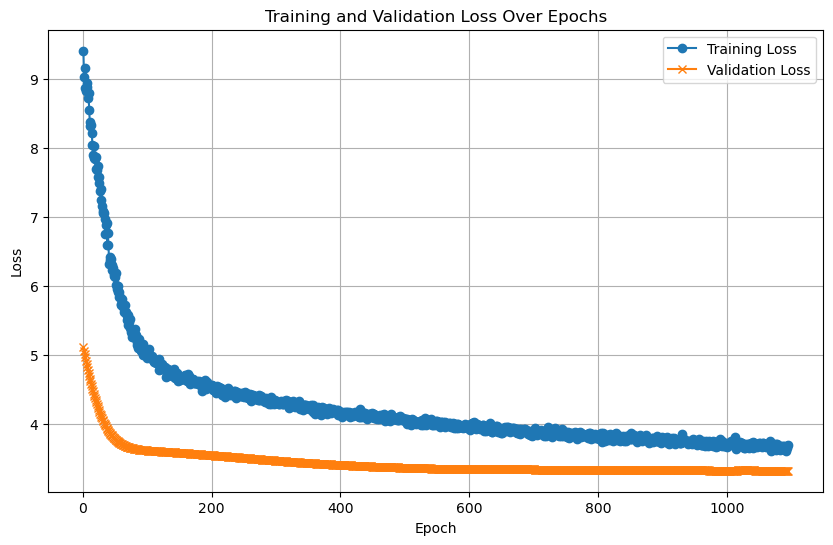

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 4.7741
Test Batch [20/40], Loss: 4.9910
Test Batch [30/40], Loss: 4.8153
Test Batch [40/40], Loss: 4.7555

Test Loss: 4.9728


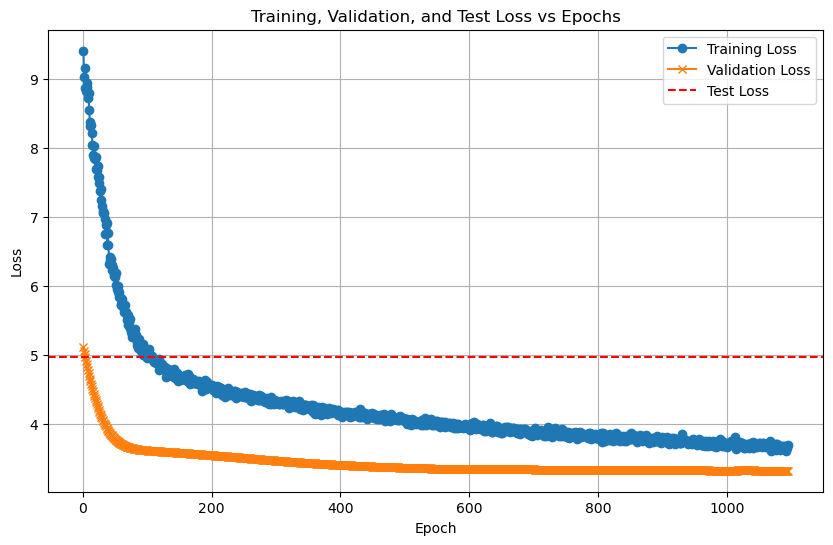

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 48.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.25      0.40      0.31         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.33      0.40      0.36         5
           5       0.80      0.80      0.80         5
           6       0.45      1.00      0.62         5
           7       0.43      0.60      0.50         5
           8       0.83      1.00      0.91         5
           9       0.43      0.60      0.50         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.83      1.00      0.91         5
          13       0.5

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7799  |  Val Loss: 2.7792
Validation loss improved from inf to 2.7792.
[Epoch 2/1000] Train Loss: 2.7600  |  Val Loss: 2.7656
Validation loss improved from 2.7792 to 2.7656.
[Epoch 3/1000] Train Loss: 2.7430  |  Val Loss: 2.7529
Validation loss improved from 2.7656 to 2.7529.
[Epoch 4/1000] Train Loss: 2.7264  |  Val Loss: 2.7409
Validation loss improved from 2.7529 to 2.7409.
[Epoch 5/1000] Train Loss: 2.7100  |  Val Loss: 2.7290
Validation loss improved from 2.7409 to 2.7290.
[Epoch 6/1000] Train Loss: 2.6954  |  Val Loss: 2.7176
Validation loss improved from 2.7290 to 2.7176.


[Epoch 7/1000] Train Loss: 2.6818  |  Val Loss: 2.7068
Validation loss improved from 2.7176 to 2.7068.
[Epoch 8/1000] Train Loss: 2.6682  |  Val Loss: 2.6968
Validation loss improved from 2.7068 to 2.6968.
[Epoch 9/1000] Train Loss: 2.6569  |  Val Loss: 2.6877
Validation loss improved from 2.6968 to 2.6877.
[Epoch 10/1000] Train Loss: 2.6454  |  Val Loss: 2.6793
Validation loss improved from 2.6877 to 2.6793.
[Epoch 11/1000] Train Loss: 2.6355  |  Val Loss: 2.6711
Validation loss improved from 2.6793 to 2.6711.
[Epoch 12/1000] Train Loss: 2.6242  |  Val Loss: 2.6633
Validation loss improved from 2.6711 to 2.6633.
[Epoch 13/1000] Train Loss: 2.6140  |  Val Loss: 2.6559
Validation loss improved from 2.6633 to 2.6559.
[Epoch 14/1000] Train Loss: 2.6036  |  Val Loss: 2.6485
Validation loss improved from 2.6559 to 2.6485.
[Epoch 15/1000] Train Loss: 2.5939  |  Val Loss: 2.6415
Validation loss improved from 2.6485 to 2.6415.
[Epoch 16/1000] Train Loss: 2.5847  |  Val Loss: 2.6348
Validation 

[Epoch 26/1000] Train Loss: 2.5016  |  Val Loss: 2.5704
Validation loss improved from 2.5777 to 2.5704.
[Epoch 27/1000] Train Loss: 2.4919  |  Val Loss: 2.5631
Validation loss improved from 2.5704 to 2.5631.
[Epoch 28/1000] Train Loss: 2.4821  |  Val Loss: 2.5553
Validation loss improved from 2.5631 to 2.5553.
[Epoch 29/1000] Train Loss: 2.4715  |  Val Loss: 2.5475
Validation loss improved from 2.5553 to 2.5475.
[Epoch 30/1000] Train Loss: 2.4608  |  Val Loss: 2.5396
Validation loss improved from 2.5475 to 2.5396.


[Epoch 31/1000] Train Loss: 2.4500  |  Val Loss: 2.5316
Validation loss improved from 2.5396 to 2.5316.
[Epoch 32/1000] Train Loss: 2.4391  |  Val Loss: 2.5235
Validation loss improved from 2.5316 to 2.5235.
[Epoch 33/1000] Train Loss: 2.4284  |  Val Loss: 2.5153
Validation loss improved from 2.5235 to 2.5153.
[Epoch 34/1000] Train Loss: 2.4176  |  Val Loss: 2.5068
Validation loss improved from 2.5153 to 2.5068.
[Epoch 35/1000] Train Loss: 2.4074  |  Val Loss: 2.4988
Validation loss improved from 2.5068 to 2.4988.
[Epoch 36/1000] Train Loss: 2.3971  |  Val Loss: 2.4911
Validation loss improved from 2.4988 to 2.4911.


[Epoch 37/1000] Train Loss: 2.3869  |  Val Loss: 2.4834
Validation loss improved from 2.4911 to 2.4834.
[Epoch 38/1000] Train Loss: 2.3769  |  Val Loss: 2.4758
Validation loss improved from 2.4834 to 2.4758.
[Epoch 39/1000] Train Loss: 2.3670  |  Val Loss: 2.4684
Validation loss improved from 2.4758 to 2.4684.
[Epoch 40/1000] Train Loss: 2.3575  |  Val Loss: 2.4611
Validation loss improved from 2.4684 to 2.4611.
[Epoch 41/1000] Train Loss: 2.3480  |  Val Loss: 2.4539
Validation loss improved from 2.4611 to 2.4539.
[Epoch 42/1000] Train Loss: 2.3386  |  Val Loss: 2.4467
Validation loss improved from 2.4539 to 2.4467.
[Epoch 43/1000] Train Loss: 2.3291  |  Val Loss: 2.4395
Validation loss improved from 2.4467 to 2.4395.
[Epoch 44/1000] Train Loss: 2.3201  |  Val Loss: 2.4322
Validation loss improved from 2.4395 to 2.4322.
[Epoch 45/1000] Train Loss: 2.3107  |  Val Loss: 2.4247
Validation loss improved from 2.4322 to 2.4247.
[Epoch 46/1000] Train Loss: 2.3013  |  Val Loss: 2.4173
Validati

[Epoch 57/1000] Train Loss: 2.2014  |  Val Loss: 2.3382
Validation loss improved from 2.3453 to 2.3382.


[Epoch 58/1000] Train Loss: 2.1925  |  Val Loss: 2.3310
Validation loss improved from 2.3382 to 2.3310.
[Epoch 59/1000] Train Loss: 2.1836  |  Val Loss: 2.3239
Validation loss improved from 2.3310 to 2.3239.
[Epoch 60/1000] Train Loss: 2.1747  |  Val Loss: 2.3168
Validation loss improved from 2.3239 to 2.3168.
[Epoch 61/1000] Train Loss: 2.1659  |  Val Loss: 2.3096
Validation loss improved from 2.3168 to 2.3096.
[Epoch 62/1000] Train Loss: 2.1572  |  Val Loss: 2.3024
Validation loss improved from 2.3096 to 2.3024.


[Epoch 63/1000] Train Loss: 2.1482  |  Val Loss: 2.2953
Validation loss improved from 2.3024 to 2.2953.
[Epoch 64/1000] Train Loss: 2.1394  |  Val Loss: 2.2885
Validation loss improved from 2.2953 to 2.2885.
[Epoch 65/1000] Train Loss: 2.1305  |  Val Loss: 2.2815
Validation loss improved from 2.2885 to 2.2815.
[Epoch 66/1000] Train Loss: 2.1214  |  Val Loss: 2.2746
Validation loss improved from 2.2815 to 2.2746.
[Epoch 67/1000] Train Loss: 2.1126  |  Val Loss: 2.2676
Validation loss improved from 2.2746 to 2.2676.
[Epoch 68/1000] Train Loss: 2.1036  |  Val Loss: 2.2608
Validation loss improved from 2.2676 to 2.2608.
[Epoch 69/1000] Train Loss: 2.0950  |  Val Loss: 2.2538
Validation loss improved from 2.2608 to 2.2538.
[Epoch 70/1000] Train Loss: 2.0857  |  Val Loss: 2.2468
Validation loss improved from 2.2538 to 2.2468.
[Epoch 71/1000] Train Loss: 2.0772  |  Val Loss: 2.2399
Validation loss improved from 2.2468 to 2.2399.
[Epoch 72/1000] Train Loss: 2.0680  |  Val Loss: 2.2327
Validati

[Epoch 85/1000] Train Loss: 1.9523  |  Val Loss: 2.1459
Validation loss improved from 2.1527 to 2.1459.
[Epoch 86/1000] Train Loss: 1.9433  |  Val Loss: 2.1393
Validation loss improved from 2.1459 to 2.1393.
[Epoch 87/1000] Train Loss: 1.9347  |  Val Loss: 2.1326
Validation loss improved from 2.1393 to 2.1326.
[Epoch 88/1000] Train Loss: 1.9256  |  Val Loss: 2.1254
Validation loss improved from 2.1326 to 2.1254.
[Epoch 89/1000] Train Loss: 1.9171  |  Val Loss: 2.1182
Validation loss improved from 2.1254 to 2.1182.
[Epoch 90/1000] Train Loss: 1.9080  |  Val Loss: 2.1113
Validation loss improved from 2.1182 to 2.1113.
[Epoch 91/1000] Train Loss: 1.8994  |  Val Loss: 2.1045
Validation loss improved from 2.1113 to 2.1045.
[Epoch 92/1000] Train Loss: 1.8904  |  Val Loss: 2.0979
Validation loss improved from 2.1045 to 2.0979.
[Epoch 93/1000] Train Loss: 1.8822  |  Val Loss: 2.0914
Validation loss improved from 2.0979 to 2.0914.


[Epoch 94/1000] Train Loss: 1.8733  |  Val Loss: 2.0849
Validation loss improved from 2.0914 to 2.0849.
[Epoch 95/1000] Train Loss: 1.8645  |  Val Loss: 2.0785
Validation loss improved from 2.0849 to 2.0785.
[Epoch 96/1000] Train Loss: 1.8557  |  Val Loss: 2.0718
Validation loss improved from 2.0785 to 2.0718.
[Epoch 97/1000] Train Loss: 1.8473  |  Val Loss: 2.0652
Validation loss improved from 2.0718 to 2.0652.
[Epoch 98/1000] Train Loss: 1.8384  |  Val Loss: 2.0589
Validation loss improved from 2.0652 to 2.0589.
[Epoch 99/1000] Train Loss: 1.8300  |  Val Loss: 2.0524
Validation loss improved from 2.0589 to 2.0524.
[Epoch 100/1000] Train Loss: 1.8214  |  Val Loss: 2.0464
Validation loss improved from 2.0524 to 2.0464.
[Epoch 101/1000] Train Loss: 1.8129  |  Val Loss: 2.0402
Validation loss improved from 2.0464 to 2.0402.
[Epoch 102/1000] Train Loss: 1.8042  |  Val Loss: 2.0345
Validation loss improved from 2.0402 to 2.0345.
[Epoch 103/1000] Train Loss: 1.7957  |  Val Loss: 2.0288
Vali

[Epoch 116/1000] Train Loss: 1.6858  |  Val Loss: 1.9533
Validation loss improved from 1.9589 to 1.9533.


[Epoch 117/1000] Train Loss: 1.6775  |  Val Loss: 1.9475
Validation loss improved from 1.9533 to 1.9475.
[Epoch 118/1000] Train Loss: 1.6687  |  Val Loss: 1.9413
Validation loss improved from 1.9475 to 1.9413.
[Epoch 119/1000] Train Loss: 1.6603  |  Val Loss: 1.9352
Validation loss improved from 1.9413 to 1.9352.
[Epoch 120/1000] Train Loss: 1.6518  |  Val Loss: 1.9292
Validation loss improved from 1.9352 to 1.9292.
[Epoch 121/1000] Train Loss: 1.6432  |  Val Loss: 1.9232
Validation loss improved from 1.9292 to 1.9232.
[Epoch 122/1000] Train Loss: 1.6347  |  Val Loss: 1.9175
Validation loss improved from 1.9232 to 1.9175.
[Epoch 123/1000] Train Loss: 1.6266  |  Val Loss: 1.9117
Validation loss improved from 1.9175 to 1.9117.
[Epoch 124/1000] Train Loss: 1.6179  |  Val Loss: 1.9061
Validation loss improved from 1.9117 to 1.9061.
[Epoch 125/1000] Train Loss: 1.6098  |  Val Loss: 1.9005
Validation loss improved from 1.9061 to 1.9005.
[Epoch 126/1000] Train Loss: 1.6013  |  Val Loss: 1.894

[Epoch 144/1000] Train Loss: 1.4555  |  Val Loss: 1.7989
Validation loss improved from 1.8040 to 1.7989.
[Epoch 145/1000] Train Loss: 1.4479  |  Val Loss: 1.7937
Validation loss improved from 1.7989 to 1.7937.
[Epoch 146/1000] Train Loss: 1.4398  |  Val Loss: 1.7888
Validation loss improved from 1.7937 to 1.7888.
[Epoch 147/1000] Train Loss: 1.4325  |  Val Loss: 1.7836
Validation loss improved from 1.7888 to 1.7836.
[Epoch 148/1000] Train Loss: 1.4245  |  Val Loss: 1.7789
Validation loss improved from 1.7836 to 1.7789.
[Epoch 149/1000] Train Loss: 1.4170  |  Val Loss: 1.7737
Validation loss improved from 1.7789 to 1.7737.
[Epoch 150/1000] Train Loss: 1.4094  |  Val Loss: 1.7685
Validation loss improved from 1.7737 to 1.7685.
[Epoch 151/1000] Train Loss: 1.4019  |  Val Loss: 1.7637
Validation loss improved from 1.7685 to 1.7637.
[Epoch 152/1000] Train Loss: 1.3946  |  Val Loss: 1.7592
Validation loss improved from 1.7637 to 1.7592.
[Epoch 153/1000] Train Loss: 1.3869  |  Val Loss: 1.755

[Epoch 173/1000] Train Loss: 1.2499  |  Val Loss: 1.6745
Validation loss improved from 1.6783 to 1.6745.
[Epoch 174/1000] Train Loss: 1.2438  |  Val Loss: 1.6709
Validation loss improved from 1.6745 to 1.6709.
[Epoch 175/1000] Train Loss: 1.2371  |  Val Loss: 1.6679
Validation loss improved from 1.6709 to 1.6679.
[Epoch 176/1000] Train Loss: 1.2312  |  Val Loss: 1.6652
Validation loss improved from 1.6679 to 1.6652.
[Epoch 177/1000] Train Loss: 1.2251  |  Val Loss: 1.6619
Validation loss improved from 1.6652 to 1.6619.
[Epoch 178/1000] Train Loss: 1.2191  |  Val Loss: 1.6587
Validation loss improved from 1.6619 to 1.6587.
[Epoch 179/1000] Train Loss: 1.2126  |  Val Loss: 1.6555
Validation loss improved from 1.6587 to 1.6555.
[Epoch 180/1000] Train Loss: 1.2068  |  Val Loss: 1.6522
Validation loss improved from 1.6555 to 1.6522.
[Epoch 181/1000] Train Loss: 1.2009  |  Val Loss: 1.6485
Validation loss improved from 1.6522 to 1.6485.
[Epoch 182/1000] Train Loss: 1.1955  |  Val Loss: 1.645

[Epoch 199/1000] Train Loss: 1.1051  |  Val Loss: 1.5971
Validation loss improved from 1.6002 to 1.5971.
[Epoch 200/1000] Train Loss: 1.0999  |  Val Loss: 1.5942
Validation loss improved from 1.5971 to 1.5942.
[Epoch 201/1000] Train Loss: 1.0955  |  Val Loss: 1.5919
Validation loss improved from 1.5942 to 1.5919.
[Epoch 202/1000] Train Loss: 1.0907  |  Val Loss: 1.5898
Validation loss improved from 1.5919 to 1.5898.
[Epoch 203/1000] Train Loss: 1.0858  |  Val Loss: 1.5871
Validation loss improved from 1.5898 to 1.5871.
[Epoch 204/1000] Train Loss: 1.0813  |  Val Loss: 1.5842
Validation loss improved from 1.5871 to 1.5842.
[Epoch 205/1000] Train Loss: 1.0766  |  Val Loss: 1.5823
Validation loss improved from 1.5842 to 1.5823.
[Epoch 206/1000] Train Loss: 1.0719  |  Val Loss: 1.5806
Validation loss improved from 1.5823 to 1.5806.
[Epoch 207/1000] Train Loss: 1.0670  |  Val Loss: 1.5790
Validation loss improved from 1.5806 to 1.5790.
[Epoch 208/1000] Train Loss: 1.0625  |  Val Loss: 1.577

[Epoch 228/1000] Train Loss: 0.9812  |  Val Loss: 1.5440
Validation loss improved from 1.5452 to 1.5440.
[Epoch 229/1000] Train Loss: 0.9777  |  Val Loss: 1.5425
Validation loss improved from 1.5440 to 1.5425.
[Epoch 230/1000] Train Loss: 0.9736  |  Val Loss: 1.5413
Validation loss improved from 1.5425 to 1.5413.
[Epoch 231/1000] Train Loss: 0.9698  |  Val Loss: 1.5394
Validation loss improved from 1.5413 to 1.5394.
[Epoch 232/1000] Train Loss: 0.9664  |  Val Loss: 1.5375
Validation loss improved from 1.5394 to 1.5375.
[Epoch 233/1000] Train Loss: 0.9626  |  Val Loss: 1.5367
Validation loss improved from 1.5375 to 1.5367.
[Epoch 234/1000] Train Loss: 0.9585  |  Val Loss: 1.5348
Validation loss improved from 1.5367 to 1.5348.
[Epoch 235/1000] Train Loss: 0.9550  |  Val Loss: 1.5330
Validation loss improved from 1.5348 to 1.5330.
[Epoch 236/1000] Train Loss: 0.9515  |  Val Loss: 1.5312
Validation loss improved from 1.5330 to 1.5312.
[Epoch 237/1000] Train Loss: 0.9480  |  Val Loss: 1.529

[Epoch 256/1000] Train Loss: 0.8803  |  Val Loss: 1.5039
Validation loss improved from 1.5050 to 1.5039.
[Epoch 257/1000] Train Loss: 0.8772  |  Val Loss: 1.5033
Validation loss improved from 1.5039 to 1.5033.
[Epoch 258/1000] Train Loss: 0.8738  |  Val Loss: 1.5017
Validation loss improved from 1.5033 to 1.5017.
[Epoch 259/1000] Train Loss: 0.8703  |  Val Loss: 1.5003
Validation loss improved from 1.5017 to 1.5003.
[Epoch 260/1000] Train Loss: 0.8674  |  Val Loss: 1.4987
Validation loss improved from 1.5003 to 1.4987.
[Epoch 261/1000] Train Loss: 0.8645  |  Val Loss: 1.4968
Validation loss improved from 1.4987 to 1.4968.
[Epoch 262/1000] Train Loss: 0.8612  |  Val Loss: 1.4963
Validation loss improved from 1.4968 to 1.4963.
[Epoch 263/1000] Train Loss: 0.8581  |  Val Loss: 1.4955
Validation loss improved from 1.4963 to 1.4955.
[Epoch 264/1000] Train Loss: 0.8550  |  Val Loss: 1.4949
Validation loss improved from 1.4955 to 1.4949.
[Epoch 265/1000] Train Loss: 0.8524  |  Val Loss: 1.494

[Epoch 286/1000] Train Loss: 0.7966  |  Val Loss: 1.4826
Validation loss improved from 1.4835 to 1.4826.
[Epoch 287/1000] Train Loss: 0.7940  |  Val Loss: 1.4825
Validation loss improved from 1.4826 to 1.4825.
[Epoch 288/1000] Train Loss: 0.7919  |  Val Loss: 1.4834
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 289/1000] Train Loss: 0.7900  |  Val Loss: 1.4839
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 290/1000] Train Loss: 0.7873  |  Val Loss: 1.4838
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 291/1000] Train Loss: 0.7848  |  Val Loss: 1.4834
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 292/1000] Train Loss: 0.7823  |  Val Loss: 1.4828
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 293/1000] Train Loss: 0.7803  |  Val Loss: 1.4820
Validation loss improved from 1.4825 to 1.4820.
[Epoch 294/1000] Train Loss: 0.7775  |  Val Loss: 1.4823
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 295/1000] Tr

[Epoch 314/1000] Train Loss: 0.7365  |  Val Loss: 1.4844
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 315/1000] Train Loss: 0.7343  |  Val Loss: 1.4836
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 316/1000] Train Loss: 0.7323  |  Val Loss: 1.4838
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 317/1000] Train Loss: 0.7309  |  Val Loss: 1.4849
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 318/1000] Train Loss: 0.7287  |  Val Loss: 1.4853
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 319/1000] Train Loss: 0.7271  |  Val Loss: 1.4849
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 320/1000] Train Loss: 0.7254  |  Val Loss: 1.4843
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 321/1000] Train Loss: 0.7231  |  Val Loss: 1.4838
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 322/1000] Train Loss: 0.7216  |  Val Loss: 1.4835
!! Validation loss did NOT improve !! Patience: 

[Epoch 340/1000] Train Loss: 0.6906  |  Val Loss: 1.4826
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 341/1000] Train Loss: 0.6888  |  Val Loss: 1.4829
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 342/1000] Train Loss: 0.6879  |  Val Loss: 1.4842
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 343/1000] Train Loss: 0.6862  |  Val Loss: 1.4836
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 344/1000] Train Loss: 0.6850  |  Val Loss: 1.4821
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 345/1000] Train Loss: 0.6825  |  Val Loss: 1.4811
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 346/1000] Train Loss: 0.6810  |  Val Loss: 1.4796
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 347/1000] Train Loss: 0.6798  |  Val Loss: 1.4795
Validation loss improved from 1.4795 to 1.4795.
[Epoch 348/1000] Train Loss: 0.6785  |  Val Loss: 1.4805
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 369/1000] Train Loss: 0.6478  |  Val Loss: 1.4874
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 370/1000] Train Loss: 0.6464  |  Val Loss: 1.4872
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 371/1000] Train Loss: 0.6454  |  Val Loss: 1.4869
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 372/1000] Train Loss: 0.6438  |  Val Loss: 1.4875
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 373/1000] Train Loss: 0.6432  |  Val Loss: 1.4885
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 374/1000] Train Loss: 0.6410  |  Val Loss: 1.4897
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 375/1000] Train Loss: 0.6399  |  Val Loss: 1.4912
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 376/1000] Train Loss: 0.6387  |  Val Loss: 1.4929
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 377/1000] Train Loss: 0.6369  |  Val Loss: 1.4942
!! Validation loss did NOT improve !! Patience:

[Epoch 397/1000] Train Loss: 0.6129  |  Val Loss: 1.5015
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 398/1000] Train Loss: 0.6113  |  Val Loss: 1.5025
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 399/1000] Train Loss: 0.6108  |  Val Loss: 1.5035
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 400/1000] Train Loss: 0.6092  |  Val Loss: 1.5042
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 401/1000] Train Loss: 0.6080  |  Val Loss: 1.5035
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 402/1000] Train Loss: 0.6073  |  Val Loss: 1.5032
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 403/1000] Train Loss: 0.6060  |  Val Loss: 1.5043
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 404/1000] Train Loss: 0.6044  |  Val Loss: 1.5050
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 405/1000] Train Loss: 0.6043  |  Val Loss: 1.5059
!! Validation loss did NOT improve !! Patience:

[Epoch 426/1000] Train Loss: 0.5816  |  Val Loss: 1.5241
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 427/1000] Train Loss: 0.5804  |  Val Loss: 1.5215
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 428/1000] Train Loss: 0.5801  |  Val Loss: 1.5194
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 429/1000] Train Loss: 0.5784  |  Val Loss: 1.5191
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 430/1000] Train Loss: 0.5773  |  Val Loss: 1.5202
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 431/1000] Train Loss: 0.5764  |  Val Loss: 1.5222
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 432/1000] Train Loss: 0.5755  |  Val Loss: 1.5238
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 433/1000] Train Loss: 0.5746  |  Val Loss: 1.5247
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 434/1000] Train Loss: 0.5738  |  Val Loss: 1.5246
!! Validation loss did NOT improve !! Patience:

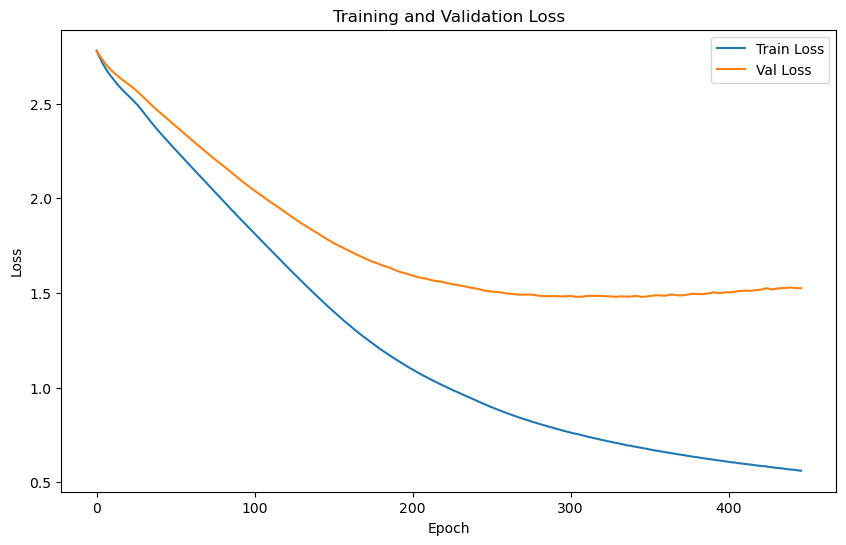

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.9896 | Test Accuracy: 45.38%


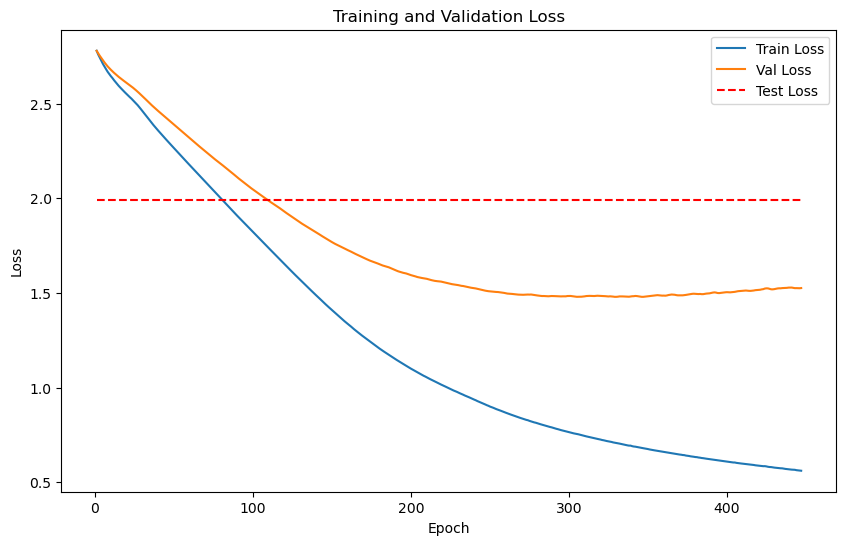

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10009 samples with 64 features each
LOG: Labels shape: (10009,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10009, 64), 
Test labels shape: (10009,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.3660
Epoch [1/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.4457

Validation loss improved from inf to 0.4457. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5244
    Batch [2/2], Val Loss: 0.3665
Epoch [2/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.4455

Validation loss improved from 0.4457 to 0.4455. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5229
    Batch [2/2], Val Loss: 0.3664
Epoch [3/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.4446

Validation loss improved from 0.4455 to 0.4446. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.3660
Epoch [4/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.4435

Validation loss improved from 0.4446 to 0.4435. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.3652
Epoch [5/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4422

Validation loss improved from 0.4435 to 0.4422. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.3646
Epoch [6/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.4409

Validation loss improved from 0.4422 to 0.4409. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.3643
Epoch [7/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.4397

Validation loss improved from 0.4409 to 0.4397. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5128
    Batch [2/2], Val Loss: 0.3641
Epoch [8/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.4384

Validation loss improved from 0.4397 to 0.4384. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.3638
Epoch [9/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.4374

Validation loss improved from 0.4384 to 0.4374. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.3638
Epoch [10/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4368

Validation loss improved from 0.4374 to 0.4368. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.3635
Epoch [11/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4361

Validation loss improved from 0.4368 to 0.4361. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.3629
Epoch [12/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4353

Validation loss improved from 0.4361 to 0.4353. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.3620
Epoch [13/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4342

Validation loss improved from 0.4353 to 0.4342. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.3610
Epoch [14/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4333

Validation loss improved from 0.4342 to 0.4333. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.3597
Epoch [15/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4321

Validation loss improved from 0.4333 to 0.4321. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.3582
Epoch [16/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4311

Validation loss improved from 0.4321 to 0.4311. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.3568
Epoch [17/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4301

Validation loss improved from 0.4311 to 0.4301. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.3554
Epoch [18/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4292

Validation loss improved from 0.4301 to 0.4292. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.3540
Epoch [19/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4282

Validation loss improved from 0.4292 to 0.4282. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.3528
Epoch [20/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4273

Validation loss improved from 0.4282 to 0.4273. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3517
Epoch [21/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4265

Validation loss improved from 0.4273 to 0.4265. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3507
Epoch [22/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4259

Validation loss improved from 0.4265 to 0.4259. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3498
Epoch [23/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4253

Validation loss improved from 0.4259 to 0.4253. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3488
Epoch [24/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4246

Validation loss improved from 0.4253 to 0.4246. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.3476
Epoch [25/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4240

Validation loss improved from 0.4246 to 0.4240. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5002
    Batch [2/2], Val Loss: 0.3463
Epoch [26/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4233

Validation loss improved from 0.4240 to 0.4233. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.3451
Epoch [27/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4226

Validation loss improved from 0.4233 to 0.4226. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5000
    Batch [2/2], Val Loss: 0.3439
Epoch [28/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4219

Validation loss improved from 0.4226 to 0.4219. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.3428
Epoch [29/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4213

Validation loss improved from 0.4219 to 0.4213. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.3419
Epoch [30/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4208

Validation loss improved from 0.4213 to 0.4208. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.3410
Epoch [31/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4203

Validation loss improved from 0.4208 to 0.4203. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.3402
Epoch [32/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4199

Validation loss improved from 0.4203 to 0.4199. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.3395
Epoch [33/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4194

Validation loss improved from 0.4199 to 0.4194. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.3388
Epoch [34/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4190

Validation loss improved from 0.4194 to 0.4190. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.3382
Epoch [35/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4186

Validation loss improved from 0.4190 to 0.4186. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.3376
Epoch [36/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4182

Validation loss improved from 0.4186 to 0.4182. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.3369
Epoch [37/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4178

Validation loss improved from 0.4182 to 0.4178. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.3363
Epoch [38/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4174

Validation loss improved from 0.4178 to 0.4174. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.3356
Epoch [39/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4170

Validation loss improved from 0.4174 to 0.4170. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4983
    Batch [2/2], Val Loss: 0.3349
Epoch [40/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4166

Validation loss improved from 0.4170 to 0.4166. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.3343
Epoch [41/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4162

Validation loss improved from 0.4166 to 0.4162. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4981
    Batch [2/2], Val Loss: 0.3336
Epoch [42/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.4158

Validation loss improved from 0.4162 to 0.4158. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.3330
Epoch [43/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4155

Validation loss improved from 0.4158 to 0.4155. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4979
    Batch [2/2], Val Loss: 0.3324
Epoch [44/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4151

Validation loss improved from 0.4155 to 0.4151. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.3318
Epoch [45/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4148

Validation loss improved from 0.4151 to 0.4148. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.3313
Epoch [46/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4145

Validation loss improved from 0.4148 to 0.4145. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.3308
Epoch [47/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4142

Validation loss improved from 0.4145 to 0.4142. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.3303
Epoch [48/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.4139

Validation loss improved from 0.4142 to 0.4139. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.3299
Epoch [49/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.4136

Validation loss improved from 0.4139 to 0.4136. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.3294
Epoch [50/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4133

Validation loss improved from 0.4136 to 0.4133. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.3290
Epoch [51/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4131

Validation loss improved from 0.4133 to 0.4131. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.3286
Epoch [52/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.4128

Validation loss improved from 0.4131 to 0.4128. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.3282
Epoch [53/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4126

Validation loss improved from 0.4128 to 0.4126. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.3278
Epoch [54/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.4123

Validation loss improved from 0.4126 to 0.4123. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.3275
Epoch [55/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4121

Validation loss improved from 0.4123 to 0.4121. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.3272
Epoch [56/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.4119

Validation loss improved from 0.4121 to 0.4119. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.3268
Epoch [57/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.4117

Validation loss improved from 0.4119 to 0.4117. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.3265
Epoch [58/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4115

Validation loss improved from 0.4117 to 0.4115. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.3262
Epoch [59/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.4113

Validation loss improved from 0.4115 to 0.4113. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.3259
Epoch [60/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4111

Validation loss improved from 0.4113 to 0.4111. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.3256
Epoch [61/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4110

Validation loss improved from 0.4111 to 0.4110. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.3253
Epoch [62/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.4107

Validation loss improved from 0.4110 to 0.4107. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.3250
Epoch [63/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4105

Validation loss improved from 0.4107 to 0.4105. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.3247
Epoch [64/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4103

Validation loss improved from 0.4105 to 0.4103. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4959
    Batch [2/2], Val Loss: 0.3244
Epoch [65/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.4101

Validation loss improved from 0.4103 to 0.4101. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.3241
Epoch [66/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.4100

Validation loss improved from 0.4101 to 0.4100. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.3238
Epoch [67/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4098

Validation loss improved from 0.4100 to 0.4098. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.3235
Epoch [68/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4096

Validation loss improved from 0.4098 to 0.4096. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.3232
Epoch [69/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4094

Validation loss improved from 0.4096 to 0.4094. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.3229
Epoch [70/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4092

Validation loss improved from 0.4094 to 0.4092. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.3225
Epoch [71/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4090

Validation loss improved from 0.4092 to 0.4090. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.3222
Epoch [72/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4088

Validation loss improved from 0.4090 to 0.4088. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.3219
Epoch [73/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.4086

Validation loss improved from 0.4088 to 0.4086. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.3215
Epoch [74/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4084

Validation loss improved from 0.4086 to 0.4084. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.3212
Epoch [75/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4082

Validation loss improved from 0.4084 to 0.4082. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.3209
Epoch [76/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4080

Validation loss improved from 0.4082 to 0.4080. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.3206
Epoch [77/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4078

Validation loss improved from 0.4080 to 0.4078. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.3203
Epoch [78/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4076

Validation loss improved from 0.4078 to 0.4076. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.3200
Epoch [79/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4075

Validation loss improved from 0.4076 to 0.4075. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.3198
Epoch [80/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4074

Validation loss improved from 0.4075 to 0.4074. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.3196
Epoch [81/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4073

Validation loss improved from 0.4074 to 0.4073. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4949
    Batch [2/2], Val Loss: 0.3194
Epoch [82/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4072

Validation loss improved from 0.4073 to 0.4072. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.3193
Epoch [83/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4071

Validation loss improved from 0.4072 to 0.4071. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.3192
Epoch [84/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4070

Validation loss improved from 0.4071 to 0.4070. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.3191
Epoch [85/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4068

Validation loss improved from 0.4070 to 0.4068. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.3190
Epoch [86/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4067

Validation loss improved from 0.4068 to 0.4067. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.3188
Epoch [87/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4066

Validation loss improved from 0.4067 to 0.4066. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.3186
Epoch [88/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4065

Validation loss improved from 0.4066 to 0.4065. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.3185
Epoch [89/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.4063

Validation loss improved from 0.4065 to 0.4063. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4942
    Batch [2/2], Val Loss: 0.3183
Epoch [90/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4063

Validation loss improved from 0.4063 to 0.4063. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.3182
Epoch [91/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4061

Validation loss improved from 0.4063 to 0.4061. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.3181
Epoch [92/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4061

Validation loss improved from 0.4061 to 0.4061. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.3180
Epoch [93/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4060

Validation loss improved from 0.4061 to 0.4060. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.3179
Epoch [94/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4059

Validation loss improved from 0.4060 to 0.4059. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.3178
Epoch [95/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4058

Validation loss improved from 0.4059 to 0.4058. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.3177
Epoch [96/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4056

Validation loss improved from 0.4058 to 0.4056. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.3175
Epoch [97/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4055

Validation loss improved from 0.4056 to 0.4055. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.3172
Epoch [98/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4053

Validation loss improved from 0.4055 to 0.4053. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.3170
Epoch [99/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4051

Validation loss improved from 0.4053 to 0.4051. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.3168
Epoch [100/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4050

Validation loss improved from 0.4051 to 0.4050. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.3166
Epoch [101/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4049

Validation loss improved from 0.4050 to 0.4049. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.3164
Epoch [102/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4047

Validation loss improved from 0.4049 to 0.4047. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.3161
Epoch [103/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4045

Validation loss improved from 0.4047 to 0.4045. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.3158
Epoch [104/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4043

Validation loss improved from 0.4045 to 0.4043. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.3155
Epoch [105/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4041

Validation loss improved from 0.4043 to 0.4041. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4926
    Batch [2/2], Val Loss: 0.3152
Epoch [106/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4039

Validation loss improved from 0.4041 to 0.4039. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.3149
Epoch [107/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4037

Validation loss improved from 0.4039 to 0.4037. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.3146
Epoch [108/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4035

Validation loss improved from 0.4037 to 0.4035. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.3143
Epoch [109/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4033

Validation loss improved from 0.4035 to 0.4033. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.3141
Epoch [110/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4031

Validation loss improved from 0.4033 to 0.4031. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.3138
Epoch [111/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4029

Validation loss improved from 0.4031 to 0.4029. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.3136
Epoch [112/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4027

Validation loss improved from 0.4029 to 0.4027. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4918
    Batch [2/2], Val Loss: 0.3133
Epoch [113/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4025

Validation loss improved from 0.4027 to 0.4025. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.3131
Epoch [114/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4024

Validation loss improved from 0.4025 to 0.4024. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.3129
Epoch [115/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4022

Validation loss improved from 0.4024 to 0.4022. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.3127
Epoch [116/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4021

Validation loss improved from 0.4022 to 0.4021. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.3125
Epoch [117/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4019

Validation loss improved from 0.4021 to 0.4019. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.3122
Epoch [118/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4017

Validation loss improved from 0.4019 to 0.4017. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.3120
Epoch [119/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4016

Validation loss improved from 0.4017 to 0.4016. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.3118
Epoch [120/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4014

Validation loss improved from 0.4016 to 0.4014. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.3116
Epoch [121/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4013

Validation loss improved from 0.4014 to 0.4013. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.3115
Epoch [122/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4012

Validation loss improved from 0.4013 to 0.4012. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.3113
Epoch [123/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4010

Validation loss improved from 0.4012 to 0.4010. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.3112
Epoch [124/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4009

Validation loss improved from 0.4010 to 0.4009. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.3110
Epoch [125/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.4008

Validation loss improved from 0.4009 to 0.4008. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.3109
Epoch [126/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4007

Validation loss improved from 0.4008 to 0.4007. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.3107
Epoch [127/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4006

Validation loss improved from 0.4007 to 0.4006. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.3106
Epoch [128/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4005

Validation loss improved from 0.4006 to 0.4005. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.3105
Epoch [129/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4003

Validation loss improved from 0.4005 to 0.4003. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.3103
Epoch [130/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4002

Validation loss improved from 0.4003 to 0.4002. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.3102
Epoch [131/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4001

Validation loss improved from 0.4002 to 0.4001. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.3102
Epoch [132/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4000

Validation loss improved from 0.4001 to 0.4000. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.3101
Epoch [133/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4000

Validation loss improved from 0.4000 to 0.4000. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.3100
Epoch [134/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.3998

Validation loss improved from 0.4000 to 0.3998. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.3099
Epoch [135/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.3997

Validation loss improved from 0.3998 to 0.3997. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4894
    Batch [2/2], Val Loss: 0.3098
Epoch [136/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.3996

Validation loss improved from 0.3997 to 0.3996. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.3097
Epoch [137/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3995

Validation loss improved from 0.3996 to 0.3995. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.3096
Epoch [138/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.3993

Validation loss improved from 0.3995 to 0.3993. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.3095
Epoch [139/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3992

Validation loss improved from 0.3993 to 0.3992. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.3093
Epoch [140/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3990

Validation loss improved from 0.3992 to 0.3990. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.3092
Epoch [141/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.3988

Validation loss improved from 0.3990 to 0.3988. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.3089
Epoch [142/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3986

Validation loss improved from 0.3988 to 0.3986. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.3087
Epoch [143/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.3984

Validation loss improved from 0.3986 to 0.3984. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.3085
Epoch [144/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3982

Validation loss improved from 0.3984 to 0.3982. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.3083
Epoch [145/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3980

Validation loss improved from 0.3982 to 0.3980. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.3081
Epoch [146/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3978

Validation loss improved from 0.3980 to 0.3978. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.3079
Epoch [147/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.3976

Validation loss improved from 0.3978 to 0.3976. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.3077
Epoch [148/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3974

Validation loss improved from 0.3976 to 0.3974. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.3075
Epoch [149/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3972

Validation loss improved from 0.3974 to 0.3972. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.3074
Epoch [150/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3971

Validation loss improved from 0.3972 to 0.3971. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.3073
Epoch [151/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3970

Validation loss improved from 0.3971 to 0.3970. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4866
    Batch [2/2], Val Loss: 0.3072
Epoch [152/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.3969

Validation loss improved from 0.3970 to 0.3969. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.3071
Epoch [153/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3967

Validation loss improved from 0.3969 to 0.3967. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.3070
Epoch [154/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.3966

Validation loss improved from 0.3967 to 0.3966. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.3069
Epoch [155/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3965

Validation loss improved from 0.3966 to 0.3965. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.3067
Epoch [156/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3963

Validation loss improved from 0.3965 to 0.3963. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.3066
Epoch [157/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3962

Validation loss improved from 0.3963 to 0.3962. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.3065
Epoch [158/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3960

Validation loss improved from 0.3962 to 0.3960. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.3064
Epoch [159/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3958

Validation loss improved from 0.3960 to 0.3958. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4851
    Batch [2/2], Val Loss: 0.3062
Epoch [160/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.3957

Validation loss improved from 0.3958 to 0.3957. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.3060
Epoch [161/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3955

Validation loss improved from 0.3957 to 0.3955. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.3059
Epoch [162/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3954

Validation loss improved from 0.3955 to 0.3954. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.3058
Epoch [163/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3953

Validation loss improved from 0.3954 to 0.3953. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.3057
Epoch [164/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3952

Validation loss improved from 0.3953 to 0.3952. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.3056
Epoch [165/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3951

Validation loss improved from 0.3952 to 0.3951. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.3056
Epoch [166/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3951

Validation loss improved from 0.3951 to 0.3951. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.3056
Epoch [167/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3951

Validation loss improved from 0.3951 to 0.3951. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.3056
Epoch [168/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.3950

Validation loss improved from 0.3951 to 0.3950. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.3055
Epoch [169/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3950

Validation loss improved from 0.3950 to 0.3950. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.3054
Epoch [170/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3949

Validation loss improved from 0.3950 to 0.3949. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.3054
Epoch [171/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3948

Validation loss improved from 0.3949 to 0.3948. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.3053
Epoch [172/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3947

Validation loss improved from 0.3948 to 0.3947. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.3052
Epoch [173/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3947

Validation loss improved from 0.3947 to 0.3947. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.3051
Epoch [174/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3946

Validation loss improved from 0.3947 to 0.3946. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.3050
Epoch [175/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3945

Validation loss improved from 0.3946 to 0.3945. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.3048
Epoch [176/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3944

Validation loss improved from 0.3945 to 0.3944. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.3047
Epoch [177/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3943

Validation loss improved from 0.3944 to 0.3943. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3047
Epoch [178/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3943

Validation loss improved from 0.3943 to 0.3943. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3046
Epoch [179/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3942

Validation loss improved from 0.3943 to 0.3942. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.3045
Epoch [180/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3941

Validation loss improved from 0.3942 to 0.3941. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.3043
Epoch [181/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3940

Validation loss improved from 0.3941 to 0.3940. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.3042
Epoch [182/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3939

Validation loss improved from 0.3940 to 0.3939. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.3040
Epoch [183/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3937

Validation loss improved from 0.3939 to 0.3937. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.3038
Epoch [184/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3936

Validation loss improved from 0.3937 to 0.3936. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.3037
Epoch [185/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3935

Validation loss improved from 0.3936 to 0.3935. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.3037
Epoch [186/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3935

Validation loss improved from 0.3935 to 0.3935. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.3036
Epoch [187/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3934

Validation loss improved from 0.3935 to 0.3934. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.3036
Epoch [188/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3933

Validation loss improved from 0.3934 to 0.3933. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.3035
Epoch [189/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3932

Validation loss improved from 0.3933 to 0.3932. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.3036
Epoch [190/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.3932

Validation loss improved from 0.3932 to 0.3932. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.3036
Epoch [191/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3931

Validation loss improved from 0.3932 to 0.3931. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.3036
Epoch [192/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3931

Validation loss improved from 0.3931 to 0.3931. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.3037
Epoch [193/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3931

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.3038
Epoch [194/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3931

Validation loss improved from 0.3931 to 0.3931. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.3038
Epoch [195/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3930

Validation loss improved from 0.3931 to 0.3930. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.3039
Epoch [196/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3930

Validation loss improved from 0.3930 to 0.3930. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.3039
Epoch [197/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.3929

Validation loss improved from 0.3930 to 0.3929. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.3038
Epoch [198/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3928

Validation loss improved from 0.3929 to 0.3928. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.3037
Epoch [199/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3927

Validation loss improved from 0.3928 to 0.3927. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.3036
Epoch [200/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.3925

Validation loss improved from 0.3927 to 0.3925. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.3034
Epoch [201/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.3924

Validation loss improved from 0.3925 to 0.3924. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.3033
Epoch [202/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3923

Validation loss improved from 0.3924 to 0.3923. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.3031
Epoch [203/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3921

Validation loss improved from 0.3923 to 0.3921. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.3029
Epoch [204/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.3919

Validation loss improved from 0.3921 to 0.3919. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.3028
Epoch [205/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.3917

Validation loss improved from 0.3919 to 0.3917. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.3026
Epoch [206/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3916

Validation loss improved from 0.3917 to 0.3916. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.3023
Epoch [207/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.3914

Validation loss improved from 0.3916 to 0.3914. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.3021
Epoch [208/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3912

Validation loss improved from 0.3914 to 0.3912. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.3018
Epoch [209/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3910

Validation loss improved from 0.3912 to 0.3910. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.3016
Epoch [210/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3907

Validation loss improved from 0.3910 to 0.3907. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.3015
Epoch [211/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.3906

Validation loss improved from 0.3907 to 0.3906. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.3014
Epoch [212/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.3906

Validation loss improved from 0.3906 to 0.3906. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.3013
Epoch [213/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.3905

Validation loss improved from 0.3906 to 0.3905. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.3012
Epoch [214/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.3904

Validation loss improved from 0.3905 to 0.3904. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.3010
Epoch [215/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3902

Validation loss improved from 0.3904 to 0.3902. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.3008
Epoch [216/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.3902

Validation loss improved from 0.3902 to 0.3902. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.3007
Epoch [217/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.3901

Validation loss improved from 0.3902 to 0.3901. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.3006
Epoch [218/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3900

Validation loss improved from 0.3901 to 0.3900. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.3006
Epoch [219/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.3900

Validation loss improved from 0.3900 to 0.3900. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.3006
Epoch [220/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.3900

Validation loss improved from 0.3900 to 0.3900. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.3007
Epoch [221/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3900

Validation loss improved from 0.3900 to 0.3900. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.3007
Epoch [222/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3900

Validation loss improved from 0.3900 to 0.3900. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.3007
Epoch [223/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.3899

Validation loss improved from 0.3900 to 0.3899. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.3007
Epoch [224/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.3899

Validation loss improved from 0.3899 to 0.3899. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.3006
Epoch [225/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3898

Validation loss improved from 0.3899 to 0.3898. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.3004
Epoch [226/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.3897

Validation loss improved from 0.3898 to 0.3897. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.3003
Epoch [227/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3896

Validation loss improved from 0.3897 to 0.3896. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.3003
Epoch [228/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.3895

Validation loss improved from 0.3896 to 0.3895. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.3002
Epoch [229/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3894

Validation loss improved from 0.3895 to 0.3894. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.3002
Epoch [230/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.3894

Validation loss improved from 0.3894 to 0.3894. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3003
Epoch [231/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3004
Epoch [232/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3005
Epoch [233/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.3007
Epoch [234/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.3008
Epoch [235/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.3010
Epoch [236/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.3011
Epoch [237/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.3013
Epoch [238/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3897

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.3015
Epoch [239/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.3897

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.3016
Epoch [240/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.3017
Epoch [241/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.3018
Epoch [242/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.3019
Epoch [243/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.3020
Epoch [244/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.3021
Epoch [245/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.3898

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.3022
Epoch [246/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3897

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.3022
Epoch [247/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.3896

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.3022
Epoch [248/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3895

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.3022
Epoch [249/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.3894

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.3021
Epoch [250/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3893

Validation loss improved from 0.3894 to 0.3893. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.3021
Epoch [251/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3892

Validation loss improved from 0.3893 to 0.3892. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.3021
Epoch [252/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.3891

Validation loss improved from 0.3892 to 0.3891. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.3020
Epoch [253/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3890

Validation loss improved from 0.3891 to 0.3890. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.3019
Epoch [254/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3889

Validation loss improved from 0.3890 to 0.3889. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.3018
Epoch [255/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.3888

Validation loss improved from 0.3889 to 0.3888. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.3017
Epoch [256/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3887

Validation loss improved from 0.3888 to 0.3887. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.3017
Epoch [257/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.3886

Validation loss improved from 0.3887 to 0.3886. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.3017
Epoch [258/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.3886

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.3018
Epoch [259/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.3886

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.3018
Epoch [260/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3886

Validation loss improved from 0.3886 to 0.3886. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.3018
Epoch [261/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.3885

Validation loss improved from 0.3886 to 0.3885. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.3018
Epoch [262/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.3884

Validation loss improved from 0.3885 to 0.3884. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.3018
Epoch [263/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.3884

Validation loss improved from 0.3884 to 0.3884. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.3018
Epoch [264/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.3883

Validation loss improved from 0.3884 to 0.3883. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.3017
Epoch [265/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3883

Validation loss improved from 0.3883 to 0.3883. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.3016
Epoch [266/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3882

Validation loss improved from 0.3883 to 0.3882. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.3014
Epoch [267/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3881

Validation loss improved from 0.3882 to 0.3881. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.3013
Epoch [268/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.3880

Validation loss improved from 0.3881 to 0.3880. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.3011
Epoch [269/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.3879

Validation loss improved from 0.3880 to 0.3879. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.3010
Epoch [270/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.3878

Validation loss improved from 0.3879 to 0.3878. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.3009
Epoch [271/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.3878

Validation loss improved from 0.3878 to 0.3878. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.3009
Epoch [272/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.3877

Validation loss improved from 0.3878 to 0.3877. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.3008
Epoch [273/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3877

Validation loss improved from 0.3877 to 0.3877. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.3008
Epoch [274/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3876

Validation loss improved from 0.3877 to 0.3876. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.3007
Epoch [275/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.3875

Validation loss improved from 0.3876 to 0.3875. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.3006
Epoch [276/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.3874

Validation loss improved from 0.3875 to 0.3874. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.3005
Epoch [277/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.3873

Validation loss improved from 0.3874 to 0.3873. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.3004
Epoch [278/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3872

Validation loss improved from 0.3873 to 0.3872. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.3003
Epoch [279/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3872

Validation loss improved from 0.3872 to 0.3872. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.3001
Epoch [280/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3871

Validation loss improved from 0.3872 to 0.3871. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.3000
Epoch [281/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3870

Validation loss improved from 0.3871 to 0.3870. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.3000
Epoch [282/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3870

Validation loss improved from 0.3870 to 0.3870. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2999
Epoch [283/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3869

Validation loss improved from 0.3870 to 0.3869. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2998
Epoch [284/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3869

Validation loss improved from 0.3869 to 0.3869. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2997
Epoch [285/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.3868

Validation loss improved from 0.3869 to 0.3868. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2996
Epoch [286/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3868

Validation loss improved from 0.3868 to 0.3868. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2995
Epoch [287/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.3867

Validation loss improved from 0.3868 to 0.3867. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2995
Epoch [288/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3867

Validation loss improved from 0.3867 to 0.3867. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2995
Epoch [289/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3867

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2994
Epoch [290/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3867

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2993
Epoch [291/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3866

Validation loss improved from 0.3867 to 0.3866. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2993
Epoch [292/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3866

Validation loss improved from 0.3866 to 0.3866. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.2993
Epoch [293/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.3866

Validation loss improved from 0.3866 to 0.3866. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.2994
Epoch [294/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3865

Validation loss improved from 0.3866 to 0.3865. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.2995
Epoch [295/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3865

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.2996
Epoch [296/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3865

Validation loss improved from 0.3865 to 0.3865. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.2997
Epoch [297/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3865

Validation loss improved from 0.3865 to 0.3865. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2998
Epoch [298/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3865

Validation loss improved from 0.3865 to 0.3865. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2999
Epoch [299/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3864

Validation loss improved from 0.3865 to 0.3864. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2999
Epoch [300/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3864

Validation loss improved from 0.3864 to 0.3864. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2998
Epoch [301/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3863

Validation loss improved from 0.3864 to 0.3863. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2997
Epoch [302/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3862

Validation loss improved from 0.3863 to 0.3862. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.2996
Epoch [303/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3860

Validation loss improved from 0.3862 to 0.3860. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.2996
Epoch [304/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3860

Validation loss improved from 0.3860 to 0.3860. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.2995
Epoch [305/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3858

Validation loss improved from 0.3860 to 0.3858. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.2994
Epoch [306/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3857

Validation loss improved from 0.3858 to 0.3857. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.2992
Epoch [307/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3855

Validation loss improved from 0.3857 to 0.3855. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.2990
Epoch [308/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3853

Validation loss improved from 0.3855 to 0.3853. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.2988
Epoch [309/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3852

Validation loss improved from 0.3853 to 0.3852. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.2986
Epoch [310/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3850

Validation loss improved from 0.3852 to 0.3850. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.2985
Epoch [311/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.3849

Validation loss improved from 0.3850 to 0.3849. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.2984
Epoch [312/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3849

Validation loss improved from 0.3849 to 0.3849. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.2984
Epoch [313/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3848

Validation loss improved from 0.3849 to 0.3848. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.2984
Epoch [314/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3848

Validation loss improved from 0.3848 to 0.3848. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.2984
Epoch [315/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3848

Validation loss improved from 0.3848 to 0.3848. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.2984
Epoch [316/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3848

Validation loss improved from 0.3848 to 0.3848. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.2983
Epoch [317/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3848

Validation loss improved from 0.3848 to 0.3848. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.2983
Epoch [318/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.2983
Epoch [319/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.2983
Epoch [320/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.2984
Epoch [321/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.2983
Epoch [322/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.2985
Epoch [323/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.2985
Epoch [324/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.2986
Epoch [325/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.2987
Epoch [326/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3852

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.2988
Epoch [327/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3852

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.2988
Epoch [328/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3853

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.2988
Epoch [329/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3853

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.2988
Epoch [330/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3853

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.2988
Epoch [331/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3854

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.2988
Epoch [332/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.3854

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.2988
Epoch [333/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3855

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.2988
Epoch [334/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3856

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.2988
Epoch [335/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3856

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2989
Epoch [336/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2988
Epoch [337/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2988
Epoch [338/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2989
Epoch [339/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2991
Epoch [340/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2991
Epoch [341/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2991
Epoch [342/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2991
Epoch [343/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2991
Epoch [344/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [345/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [346/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [347/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [348/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [349/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [350/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [351/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [352/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2990
Epoch [353/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2989
Epoch [354/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2989
Epoch [355/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3859

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2989
Epoch [356/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2989
Epoch [357/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2989
Epoch [358/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2988
Epoch [359/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2988
Epoch [360/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2988
Epoch [361/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2988
Epoch [362/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2988
Epoch [363/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2988
Epoch [364/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [365/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [366/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [367/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [368/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [369/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [370/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [371/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [372/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [373/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [374/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [375/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [376/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [377/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [378/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [379/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [380/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [381/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [382/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [383/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [384/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [385/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [386/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [387/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [388/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [389/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [390/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [391/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [392/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [393/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [394/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [395/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [396/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [397/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [398/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [399/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [400/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [401/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [402/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [403/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [404/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [405/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [406/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [407/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [408/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [409/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [410/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [411/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [412/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [413/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [414/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [415/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [416/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2987
Epoch [417/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 417!!
No improvement for 100 epochs


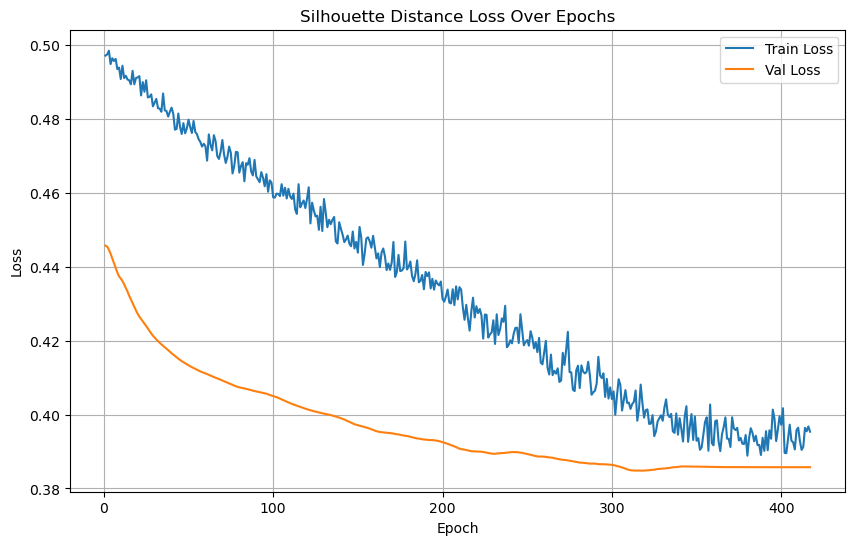

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/157], Loss: 0.3791


Test Batch [20/157], Loss: 0.3933
Test Batch [30/157], Loss: 0.3435


Test Batch [40/157], Loss: 0.3325


Test Batch [50/157], Loss: 0.4375
Test Batch [60/157], Loss: 0.4413


Test Batch [70/157], Loss: 0.2159
Test Batch [80/157], Loss: 0.2818
Test Batch [90/157], Loss: 0.2696
Test Batch [100/157], Loss: 0.2394
Test Batch [110/157], Loss: 0.1611


Test Batch [120/157], Loss: 0.1772
Test Batch [130/157], Loss: 0.1058
Test Batch [140/157], Loss: 0.3977
Test Batch [150/157], Loss: 0.2957



Test Loss: 0.3154


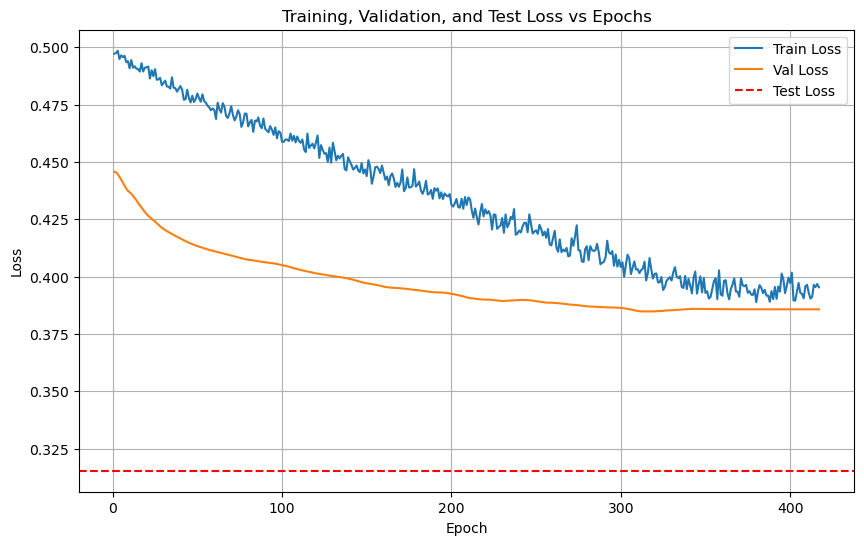

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/157 for test dataset.


  Processed batch 20/157 for test dataset.
  Processed batch 30/157 for test dataset.
  Processed batch 40/157 for test dataset.


  Processed batch 50/157 for test dataset.
  Processed batch 60/157 for test dataset.
  Processed batch 70/157 for test dataset.
  Processed batch 80/157 for test dataset.


  Processed batch 90/157 for test dataset.
  Processed batch 100/157 for test dataset.
  Processed batch 110/157 for test dataset.
  Processed batch 120/157 for test dataset.


  Processed batch 130/157 for test dataset.
  Processed batch 140/157 for test dataset.
  Processed batch 150/157 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 47.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.38      0.60      0.46         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.50      0.20      0.29         5
           5       0.40      0.40      0.40         5
           6       0.40      0.80      0.53         5
           7       0.38      0.60      0.46         5
           8       0.71      1.00      0.83         5
           9       0.50      0.40      0.44         5
          10       0.25      0.20      0.22         5
          11       0.50      0.20      0.29         5
          12       0.83      1.00      0.91         5
          13       0.5

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10009, 128)
Test labels shape: (10009,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9135  |  Val Loss: 2.8819
Validation loss improved from inf to 2.8819.
[Epoch 2/1000] Train Loss: 2.8920  |  Val Loss: 2.8662
Validation loss improved from 2.8819 to 2.8662.
[Epoch 3/1000] Train Loss: 2.8708  |  Val Loss: 2.8515
Validation loss improved from 2.8662 to 2.8515.
[Epoch 4/1000] Train Loss: 2.8503  |  Val Loss: 2.8377
Validation loss improved from 2.8515 to 2.8377.
[Epoch 5/1000] Train Loss: 2.8318  |  Val Loss: 2.8249
Validation loss improved from 2.8377 to 2.8249.
[Epoch 6/1000] Train Loss: 2.8138  |  Val Loss: 2.8129
Validation loss improved from 2.8249 to 2.8129.
[Epoch 7/1000] Train Loss: 2.7995  |  Val Loss: 2.8012
Validation loss improved from 2.8129 to 2.8012.
[Epoch 8/1000] Train Loss: 2.7818  |  Val Loss: 2.7899
Validation loss improved from 2.8012 to 2.7899.
[Epoch 9/1000] Train Loss: 2.7666  |  Val Loss: 2.7789
Validation loss improved from 2.7899 to 2.7789.
[Epoch 10/1000] Train Loss: 2.7506  |  Val Loss: 2.7684
Validation loss impr

[Epoch 11/1000] Train Loss: 2.7351  |  Val Loss: 2.7582
Validation loss improved from 2.7684 to 2.7582.
[Epoch 12/1000] Train Loss: 2.7218  |  Val Loss: 2.7479
Validation loss improved from 2.7582 to 2.7479.
[Epoch 13/1000] Train Loss: 2.7079  |  Val Loss: 2.7380
Validation loss improved from 2.7479 to 2.7380.
[Epoch 14/1000] Train Loss: 2.6938  |  Val Loss: 2.7287
Validation loss improved from 2.7380 to 2.7287.
[Epoch 15/1000] Train Loss: 2.6807  |  Val Loss: 2.7197
Validation loss improved from 2.7287 to 2.7197.
[Epoch 16/1000] Train Loss: 2.6681  |  Val Loss: 2.7105
Validation loss improved from 2.7197 to 2.7105.
[Epoch 17/1000] Train Loss: 2.6544  |  Val Loss: 2.7017
Validation loss improved from 2.7105 to 2.7017.
[Epoch 18/1000] Train Loss: 2.6425  |  Val Loss: 2.6929
Validation loss improved from 2.7017 to 2.6929.
[Epoch 19/1000] Train Loss: 2.6312  |  Val Loss: 2.6840
Validation loss improved from 2.6929 to 2.6840.
[Epoch 20/1000] Train Loss: 2.6193  |  Val Loss: 2.6755
Validati

[Epoch 25/1000] Train Loss: 2.5650  |  Val Loss: 2.6363
Validation loss improved from 2.6440 to 2.6363.


[Epoch 26/1000] Train Loss: 2.5552  |  Val Loss: 2.6284
Validation loss improved from 2.6363 to 2.6284.
[Epoch 27/1000] Train Loss: 2.5441  |  Val Loss: 2.6210
Validation loss improved from 2.6284 to 2.6210.
[Epoch 28/1000] Train Loss: 2.5340  |  Val Loss: 2.6135
Validation loss improved from 2.6210 to 2.6135.
[Epoch 29/1000] Train Loss: 2.5233  |  Val Loss: 2.6059
Validation loss improved from 2.6135 to 2.6059.
[Epoch 30/1000] Train Loss: 2.5130  |  Val Loss: 2.5981
Validation loss improved from 2.6059 to 2.5981.
[Epoch 31/1000] Train Loss: 2.5028  |  Val Loss: 2.5902
Validation loss improved from 2.5981 to 2.5902.
[Epoch 32/1000] Train Loss: 2.4925  |  Val Loss: 2.5823
Validation loss improved from 2.5902 to 2.5823.
[Epoch 33/1000] Train Loss: 2.4817  |  Val Loss: 2.5747
Validation loss improved from 2.5823 to 2.5747.
[Epoch 34/1000] Train Loss: 2.4716  |  Val Loss: 2.5671
Validation loss improved from 2.5747 to 2.5671.
[Epoch 35/1000] Train Loss: 2.4613  |  Val Loss: 2.5595
Validati

[Epoch 40/1000] Train Loss: 2.4103  |  Val Loss: 2.5242
Validation loss improved from 2.5312 to 2.5242.
[Epoch 41/1000] Train Loss: 2.4002  |  Val Loss: 2.5171
Validation loss improved from 2.5242 to 2.5171.
[Epoch 42/1000] Train Loss: 2.3899  |  Val Loss: 2.5102
Validation loss improved from 2.5171 to 2.5102.
[Epoch 43/1000] Train Loss: 2.3798  |  Val Loss: 2.5032
Validation loss improved from 2.5102 to 2.5032.
[Epoch 44/1000] Train Loss: 2.3699  |  Val Loss: 2.4963
Validation loss improved from 2.5032 to 2.4963.
[Epoch 45/1000] Train Loss: 2.3592  |  Val Loss: 2.4896
Validation loss improved from 2.4963 to 2.4896.
[Epoch 46/1000] Train Loss: 2.3491  |  Val Loss: 2.4828
Validation loss improved from 2.4896 to 2.4828.
[Epoch 47/1000] Train Loss: 2.3385  |  Val Loss: 2.4762
Validation loss improved from 2.4828 to 2.4762.
[Epoch 48/1000] Train Loss: 2.3286  |  Val Loss: 2.4692
Validation loss improved from 2.4762 to 2.4692.
[Epoch 49/1000] Train Loss: 2.3185  |  Val Loss: 2.4623
Validati

[Epoch 55/1000] Train Loss: 2.2566  |  Val Loss: 2.4215
Validation loss improved from 2.4283 to 2.4215.
[Epoch 56/1000] Train Loss: 2.2463  |  Val Loss: 2.4149
Validation loss improved from 2.4215 to 2.4149.
[Epoch 57/1000] Train Loss: 2.2361  |  Val Loss: 2.4084
Validation loss improved from 2.4149 to 2.4084.
[Epoch 58/1000] Train Loss: 2.2261  |  Val Loss: 2.4019
Validation loss improved from 2.4084 to 2.4019.
[Epoch 59/1000] Train Loss: 2.2158  |  Val Loss: 2.3955
Validation loss improved from 2.4019 to 2.3955.
[Epoch 60/1000] Train Loss: 2.2059  |  Val Loss: 2.3889
Validation loss improved from 2.3955 to 2.3889.
[Epoch 61/1000] Train Loss: 2.1955  |  Val Loss: 2.3825
Validation loss improved from 2.3889 to 2.3825.
[Epoch 62/1000] Train Loss: 2.1855  |  Val Loss: 2.3760
Validation loss improved from 2.3825 to 2.3760.
[Epoch 63/1000] Train Loss: 2.1752  |  Val Loss: 2.3696
Validation loss improved from 2.3760 to 2.3696.
[Epoch 64/1000] Train Loss: 2.1650  |  Val Loss: 2.3632
Validati

[Epoch 71/1000] Train Loss: 2.0913  |  Val Loss: 2.3178
Validation loss improved from 2.3243 to 2.3178.
[Epoch 72/1000] Train Loss: 2.0811  |  Val Loss: 2.3113
Validation loss improved from 2.3178 to 2.3113.
[Epoch 73/1000] Train Loss: 2.0703  |  Val Loss: 2.3047
Validation loss improved from 2.3113 to 2.3047.
[Epoch 74/1000] Train Loss: 2.0593  |  Val Loss: 2.2981
Validation loss improved from 2.3047 to 2.2981.
[Epoch 75/1000] Train Loss: 2.0485  |  Val Loss: 2.2914
Validation loss improved from 2.2981 to 2.2914.
[Epoch 76/1000] Train Loss: 2.0376  |  Val Loss: 2.2848
Validation loss improved from 2.2914 to 2.2848.
[Epoch 77/1000] Train Loss: 2.0270  |  Val Loss: 2.2781
Validation loss improved from 2.2848 to 2.2781.
[Epoch 78/1000] Train Loss: 2.0160  |  Val Loss: 2.2714
Validation loss improved from 2.2781 to 2.2714.
[Epoch 79/1000] Train Loss: 2.0050  |  Val Loss: 2.2648
Validation loss improved from 2.2714 to 2.2648.
[Epoch 80/1000] Train Loss: 1.9939  |  Val Loss: 2.2580
Validati

[Epoch 82/1000] Train Loss: 1.9718  |  Val Loss: 2.2444
Validation loss improved from 2.2512 to 2.2444.
[Epoch 83/1000] Train Loss: 1.9603  |  Val Loss: 2.2375
Validation loss improved from 2.2444 to 2.2375.
[Epoch 84/1000] Train Loss: 1.9496  |  Val Loss: 2.2307
Validation loss improved from 2.2375 to 2.2307.
[Epoch 85/1000] Train Loss: 1.9382  |  Val Loss: 2.2237
Validation loss improved from 2.2307 to 2.2237.
[Epoch 86/1000] Train Loss: 1.9269  |  Val Loss: 2.2167
Validation loss improved from 2.2237 to 2.2167.
[Epoch 87/1000] Train Loss: 1.9157  |  Val Loss: 2.2096
Validation loss improved from 2.2167 to 2.2096.
[Epoch 88/1000] Train Loss: 1.9046  |  Val Loss: 2.2026
Validation loss improved from 2.2096 to 2.2026.
[Epoch 89/1000] Train Loss: 1.8934  |  Val Loss: 2.1955
Validation loss improved from 2.2026 to 2.1955.
[Epoch 90/1000] Train Loss: 1.8819  |  Val Loss: 2.1885
Validation loss improved from 2.1955 to 2.1885.
[Epoch 91/1000] Train Loss: 1.8706  |  Val Loss: 2.1816
Validati

[Epoch 100/1000] Train Loss: 1.7681  |  Val Loss: 2.1166
Validation loss improved from 2.1237 to 2.1166.
[Epoch 101/1000] Train Loss: 1.7566  |  Val Loss: 2.1096
Validation loss improved from 2.1166 to 2.1096.
[Epoch 102/1000] Train Loss: 1.7454  |  Val Loss: 2.1026
Validation loss improved from 2.1096 to 2.1026.
[Epoch 103/1000] Train Loss: 1.7338  |  Val Loss: 2.0957
Validation loss improved from 2.1026 to 2.0957.
[Epoch 104/1000] Train Loss: 1.7225  |  Val Loss: 2.0885
Validation loss improved from 2.0957 to 2.0885.
[Epoch 105/1000] Train Loss: 1.7111  |  Val Loss: 2.0815
Validation loss improved from 2.0885 to 2.0815.
[Epoch 106/1000] Train Loss: 1.6997  |  Val Loss: 2.0745
Validation loss improved from 2.0815 to 2.0745.
[Epoch 107/1000] Train Loss: 1.6882  |  Val Loss: 2.0678
Validation loss improved from 2.0745 to 2.0678.
[Epoch 108/1000] Train Loss: 1.6770  |  Val Loss: 2.0610
Validation loss improved from 2.0678 to 2.0610.
[Epoch 109/1000] Train Loss: 1.6656  |  Val Loss: 2.053

[Epoch 110/1000] Train Loss: 1.6542  |  Val Loss: 2.0466
Validation loss improved from 2.0536 to 2.0466.
[Epoch 111/1000] Train Loss: 1.6427  |  Val Loss: 2.0397
Validation loss improved from 2.0466 to 2.0397.
[Epoch 112/1000] Train Loss: 1.6316  |  Val Loss: 2.0329
Validation loss improved from 2.0397 to 2.0329.
[Epoch 113/1000] Train Loss: 1.6202  |  Val Loss: 2.0261
Validation loss improved from 2.0329 to 2.0261.
[Epoch 114/1000] Train Loss: 1.6092  |  Val Loss: 2.0194
Validation loss improved from 2.0261 to 2.0194.
[Epoch 115/1000] Train Loss: 1.5980  |  Val Loss: 2.0128
Validation loss improved from 2.0194 to 2.0128.
[Epoch 116/1000] Train Loss: 1.5869  |  Val Loss: 2.0060
Validation loss improved from 2.0128 to 2.0060.
[Epoch 117/1000] Train Loss: 1.5759  |  Val Loss: 1.9991
Validation loss improved from 2.0060 to 1.9991.
[Epoch 118/1000] Train Loss: 1.5644  |  Val Loss: 1.9923
Validation loss improved from 1.9991 to 1.9923.
[Epoch 119/1000] Train Loss: 1.5537  |  Val Loss: 1.985

[Epoch 129/1000] Train Loss: 1.4437  |  Val Loss: 1.9170
Validation loss improved from 1.9236 to 1.9170.
[Epoch 130/1000] Train Loss: 1.4332  |  Val Loss: 1.9110
Validation loss improved from 1.9170 to 1.9110.
[Epoch 131/1000] Train Loss: 1.4223  |  Val Loss: 1.9048
Validation loss improved from 1.9110 to 1.9048.
[Epoch 132/1000] Train Loss: 1.4117  |  Val Loss: 1.8987
Validation loss improved from 1.9048 to 1.8987.
[Epoch 133/1000] Train Loss: 1.4012  |  Val Loss: 1.8925
Validation loss improved from 1.8987 to 1.8925.
[Epoch 134/1000] Train Loss: 1.3907  |  Val Loss: 1.8859
Validation loss improved from 1.8925 to 1.8859.
[Epoch 135/1000] Train Loss: 1.3802  |  Val Loss: 1.8795
Validation loss improved from 1.8859 to 1.8795.
[Epoch 136/1000] Train Loss: 1.3701  |  Val Loss: 1.8729
Validation loss improved from 1.8795 to 1.8729.


[Epoch 137/1000] Train Loss: 1.3596  |  Val Loss: 1.8666
Validation loss improved from 1.8729 to 1.8666.
[Epoch 138/1000] Train Loss: 1.3491  |  Val Loss: 1.8604
Validation loss improved from 1.8666 to 1.8604.
[Epoch 139/1000] Train Loss: 1.3393  |  Val Loss: 1.8543
Validation loss improved from 1.8604 to 1.8543.
[Epoch 140/1000] Train Loss: 1.3291  |  Val Loss: 1.8482
Validation loss improved from 1.8543 to 1.8482.
[Epoch 141/1000] Train Loss: 1.3190  |  Val Loss: 1.8425
Validation loss improved from 1.8482 to 1.8425.
[Epoch 142/1000] Train Loss: 1.3084  |  Val Loss: 1.8371
Validation loss improved from 1.8425 to 1.8371.
[Epoch 143/1000] Train Loss: 1.2983  |  Val Loss: 1.8313
Validation loss improved from 1.8371 to 1.8313.
[Epoch 144/1000] Train Loss: 1.2884  |  Val Loss: 1.8262
Validation loss improved from 1.8313 to 1.8262.
[Epoch 145/1000] Train Loss: 1.2782  |  Val Loss: 1.8211
Validation loss improved from 1.8262 to 1.8211.
[Epoch 146/1000] Train Loss: 1.2680  |  Val Loss: 1.815

[Epoch 160/1000] Train Loss: 1.1301  |  Val Loss: 1.7438
Validation loss improved from 1.7494 to 1.7438.
[Epoch 161/1000] Train Loss: 1.1205  |  Val Loss: 1.7386
Validation loss improved from 1.7438 to 1.7386.
[Epoch 162/1000] Train Loss: 1.1117  |  Val Loss: 1.7336
Validation loss improved from 1.7386 to 1.7336.
[Epoch 163/1000] Train Loss: 1.1022  |  Val Loss: 1.7284
Validation loss improved from 1.7336 to 1.7284.
[Epoch 164/1000] Train Loss: 1.0932  |  Val Loss: 1.7232
Validation loss improved from 1.7284 to 1.7232.
[Epoch 165/1000] Train Loss: 1.0842  |  Val Loss: 1.7185
Validation loss improved from 1.7232 to 1.7185.
[Epoch 166/1000] Train Loss: 1.0757  |  Val Loss: 1.7139
Validation loss improved from 1.7185 to 1.7139.


[Epoch 167/1000] Train Loss: 1.0665  |  Val Loss: 1.7100
Validation loss improved from 1.7139 to 1.7100.
[Epoch 168/1000] Train Loss: 1.0573  |  Val Loss: 1.7063
Validation loss improved from 1.7100 to 1.7063.
[Epoch 169/1000] Train Loss: 1.0489  |  Val Loss: 1.7033
Validation loss improved from 1.7063 to 1.7033.
[Epoch 170/1000] Train Loss: 1.0402  |  Val Loss: 1.7000
Validation loss improved from 1.7033 to 1.7000.
[Epoch 171/1000] Train Loss: 1.0314  |  Val Loss: 1.6966
Validation loss improved from 1.7000 to 1.6966.
[Epoch 172/1000] Train Loss: 1.0227  |  Val Loss: 1.6929
Validation loss improved from 1.6966 to 1.6929.
[Epoch 173/1000] Train Loss: 1.0142  |  Val Loss: 1.6895
Validation loss improved from 1.6929 to 1.6895.
[Epoch 174/1000] Train Loss: 1.0059  |  Val Loss: 1.6863
Validation loss improved from 1.6895 to 1.6863.
[Epoch 175/1000] Train Loss: 0.9975  |  Val Loss: 1.6825
Validation loss improved from 1.6863 to 1.6825.
[Epoch 176/1000] Train Loss: 0.9891  |  Val Loss: 1.678

[Epoch 191/1000] Train Loss: 0.8720  |  Val Loss: 1.6287
Validation loss improved from 1.6303 to 1.6287.
[Epoch 192/1000] Train Loss: 0.8649  |  Val Loss: 1.6269
Validation loss improved from 1.6287 to 1.6269.
[Epoch 193/1000] Train Loss: 0.8581  |  Val Loss: 1.6243
Validation loss improved from 1.6269 to 1.6243.
[Epoch 194/1000] Train Loss: 0.8507  |  Val Loss: 1.6215
Validation loss improved from 1.6243 to 1.6215.
[Epoch 195/1000] Train Loss: 0.8437  |  Val Loss: 1.6178
Validation loss improved from 1.6215 to 1.6178.
[Epoch 196/1000] Train Loss: 0.8365  |  Val Loss: 1.6138
Validation loss improved from 1.6178 to 1.6138.


[Epoch 197/1000] Train Loss: 0.8295  |  Val Loss: 1.6104
Validation loss improved from 1.6138 to 1.6104.
[Epoch 198/1000] Train Loss: 0.8227  |  Val Loss: 1.6077
Validation loss improved from 1.6104 to 1.6077.
[Epoch 199/1000] Train Loss: 0.8161  |  Val Loss: 1.6055
Validation loss improved from 1.6077 to 1.6055.
[Epoch 200/1000] Train Loss: 0.8095  |  Val Loss: 1.6029
Validation loss improved from 1.6055 to 1.6029.
[Epoch 201/1000] Train Loss: 0.8025  |  Val Loss: 1.6000
Validation loss improved from 1.6029 to 1.6000.
[Epoch 202/1000] Train Loss: 0.7961  |  Val Loss: 1.5972
Validation loss improved from 1.6000 to 1.5972.
[Epoch 203/1000] Train Loss: 0.7894  |  Val Loss: 1.5939
Validation loss improved from 1.5972 to 1.5939.
[Epoch 204/1000] Train Loss: 0.7832  |  Val Loss: 1.5906
Validation loss improved from 1.5939 to 1.5906.
[Epoch 205/1000] Train Loss: 0.7770  |  Val Loss: 1.5878
Validation loss improved from 1.5906 to 1.5878.
[Epoch 206/1000] Train Loss: 0.7708  |  Val Loss: 1.585

[Epoch 219/1000] Train Loss: 0.6951  |  Val Loss: 1.5658
Validation loss improved from 1.5673 to 1.5658.
[Epoch 220/1000] Train Loss: 0.6898  |  Val Loss: 1.5642
Validation loss improved from 1.5658 to 1.5642.
[Epoch 221/1000] Train Loss: 0.6844  |  Val Loss: 1.5618
Validation loss improved from 1.5642 to 1.5618.
[Epoch 222/1000] Train Loss: 0.6788  |  Val Loss: 1.5594
Validation loss improved from 1.5618 to 1.5594.
[Epoch 223/1000] Train Loss: 0.6735  |  Val Loss: 1.5580
Validation loss improved from 1.5594 to 1.5580.
[Epoch 224/1000] Train Loss: 0.6681  |  Val Loss: 1.5556
Validation loss improved from 1.5580 to 1.5556.


[Epoch 225/1000] Train Loss: 0.6630  |  Val Loss: 1.5546
Validation loss improved from 1.5556 to 1.5546.
[Epoch 226/1000] Train Loss: 0.6583  |  Val Loss: 1.5539
Validation loss improved from 1.5546 to 1.5539.
[Epoch 227/1000] Train Loss: 0.6531  |  Val Loss: 1.5518
Validation loss improved from 1.5539 to 1.5518.
[Epoch 228/1000] Train Loss: 0.6481  |  Val Loss: 1.5497
Validation loss improved from 1.5518 to 1.5497.
[Epoch 229/1000] Train Loss: 0.6431  |  Val Loss: 1.5494
Validation loss improved from 1.5497 to 1.5494.
[Epoch 230/1000] Train Loss: 0.6386  |  Val Loss: 1.5500
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 231/1000] Train Loss: 0.6341  |  Val Loss: 1.5506
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 232/1000] Train Loss: 0.6292  |  Val Loss: 1.5498
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 233/1000] Train Loss: 0.6246  |  Val Loss: 1.5483
Validation loss improved from 1.5494 to 1.5483.
[Epoch 234/1000] Train Loss: 0.6201  

[Epoch 247/1000] Train Loss: 0.5658  |  Val Loss: 1.5452
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 248/1000] Train Loss: 0.5616  |  Val Loss: 1.5443
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 249/1000] Train Loss: 0.5578  |  Val Loss: 1.5447
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 250/1000] Train Loss: 0.5539  |  Val Loss: 1.5462
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 251/1000] Train Loss: 0.5501  |  Val Loss: 1.5487
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 252/1000] Train Loss: 0.5464  |  Val Loss: 1.5502
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 253/1000] Train Loss: 0.5428  |  Val Loss: 1.5525
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 254/1000] Train Loss: 0.5393  |  Val Loss: 1.5554
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 255/1000] Train Loss: 0.5364  |  Val Loss: 1.5573
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 256/1000] Train Loss: 0.5331  |  Val Loss: 1.5567
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 257/1000] Train Loss: 0.5295  |  Val Loss: 1.5553
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 258/1000] Train Loss: 0.5258  |  Val Loss: 1.5523
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 259/1000] Train Loss: 0.5222  |  Val Loss: 1.5499
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 260/1000] Train Loss: 0.5188  |  Val Loss: 1.5472
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 261/1000] Train Loss: 0.5150  |  Val Loss: 1.5461
!! Validation loss did NOT improve !! Patience:

[Epoch 273/1000] Train Loss: 0.4770  |  Val Loss: 1.5537
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 274/1000] Train Loss: 0.4741  |  Val Loss: 1.5533
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 275/1000] Train Loss: 0.4714  |  Val Loss: 1.5529
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 276/1000] Train Loss: 0.4685  |  Val Loss: 1.5540
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 277/1000] Train Loss: 0.4656  |  Val Loss: 1.5550
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 278/1000] Train Loss: 0.4627  |  Val Loss: 1.5565
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 279/1000] Train Loss: 0.4597  |  Val Loss: 1.5588
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 280/1000] Train Loss: 0.4572  |  Val Loss: 1.5609
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 281/1000] Train Loss: 0.4542  |  Val Loss: 1.5617
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 282/1000] Train Loss: 0.4518  |  Val Loss: 1.5619
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 283/1000] Train Loss: 0.4490  |  Val Loss: 1.5641
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 284/1000] Train Loss: 0.4464  |  Val Loss: 1.5658
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 285/1000] Train Loss: 0.4436  |  Val Loss: 1.5678
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 286/1000] Train Loss: 0.4408  |  Val Loss: 1.5677
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 287/1000] Train Loss: 0.4383  |  Val Loss: 1.5676
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 288/1000] Train Loss: 0.4356  |  Val Loss: 1.5673
!! Validation loss did NOT improve !! Patience:

[Epoch 302/1000] Train Loss: 0.4023  |  Val Loss: 1.5791
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 303/1000] Train Loss: 0.4001  |  Val Loss: 1.5814
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 304/1000] Train Loss: 0.3980  |  Val Loss: 1.5822
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 305/1000] Train Loss: 0.3957  |  Val Loss: 1.5835
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 306/1000] Train Loss: 0.3941  |  Val Loss: 1.5869
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 307/1000] Train Loss: 0.3916  |  Val Loss: 1.5886
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 308/1000] Train Loss: 0.3894  |  Val Loss: 1.5898
!! Validation loss did NOT improve !! Patience: 68/100


[Epoch 309/1000] Train Loss: 0.3875  |  Val Loss: 1.5908
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 310/1000] Train Loss: 0.3853  |  Val Loss: 1.5913
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 311/1000] Train Loss: 0.3834  |  Val Loss: 1.5907
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 312/1000] Train Loss: 0.3814  |  Val Loss: 1.5905
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 313/1000] Train Loss: 0.3794  |  Val Loss: 1.5917
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 314/1000] Train Loss: 0.3772  |  Val Loss: 1.5938
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 315/1000] Train Loss: 0.3755  |  Val Loss: 1.5959
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 316/1000] Train Loss: 0.3734  |  Val Loss: 1.5972
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 317/1000] Train Loss: 0.3716  |  Val Loss: 1.5973
!! Validation loss did NOT improve !! Patience:

[Epoch 332/1000] Train Loss: 0.3442  |  Val Loss: 1.6194
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 333/1000] Train Loss: 0.3424  |  Val Loss: 1.6225
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 334/1000] Train Loss: 0.3406  |  Val Loss: 1.6268
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 335/1000] Train Loss: 0.3388  |  Val Loss: 1.6302
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 336/1000] Train Loss: 0.3374  |  Val Loss: 1.6328
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 337/1000] Train Loss: 0.3358  |  Val Loss: 1.6314
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 338/1000] Train Loss: 0.3340  |  Val Loss: 1.6325
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 339/1000] Train Loss: 0.3321  |  Val Loss: 1.6349
!! Validation loss did NOT improve !! Patience: 99/100


[Epoch 340/1000] Train Loss: 0.3304  |  Val Loss: 1.6375
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 340 !!
No improvement for 100 epochs.


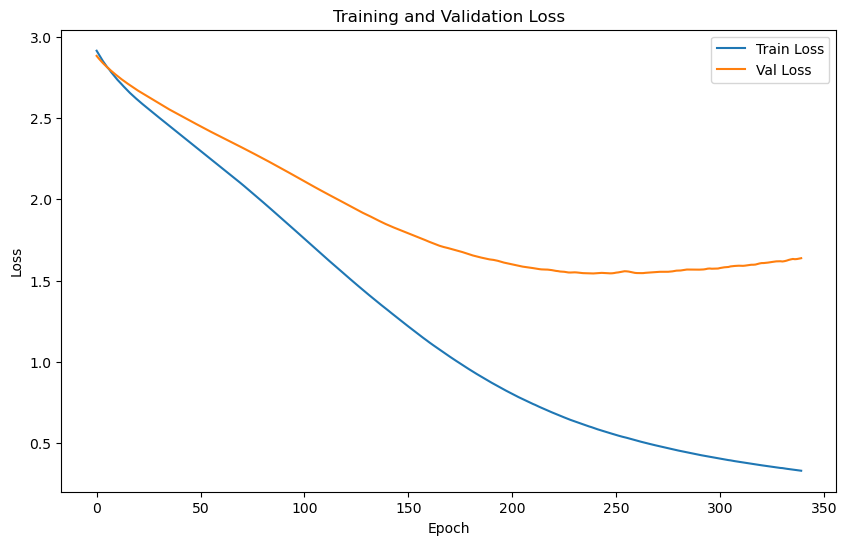

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.8559 | Test Accuracy: 47.61%


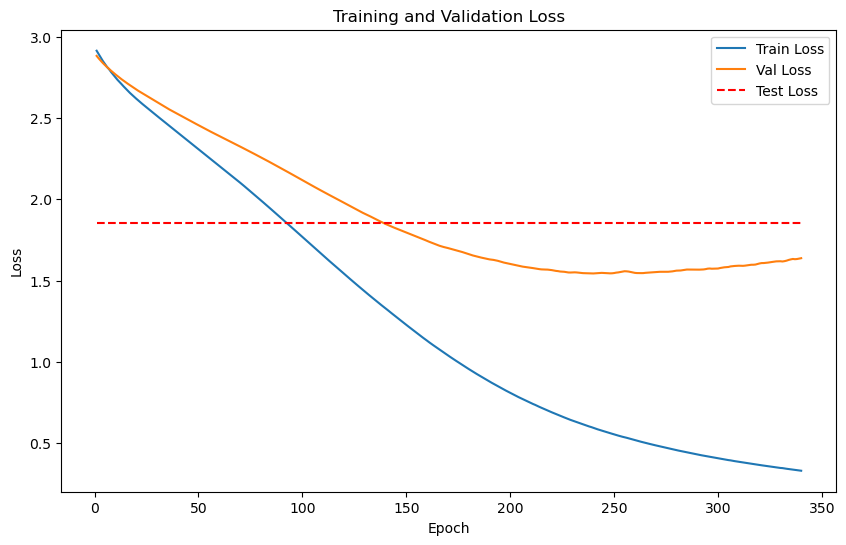

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


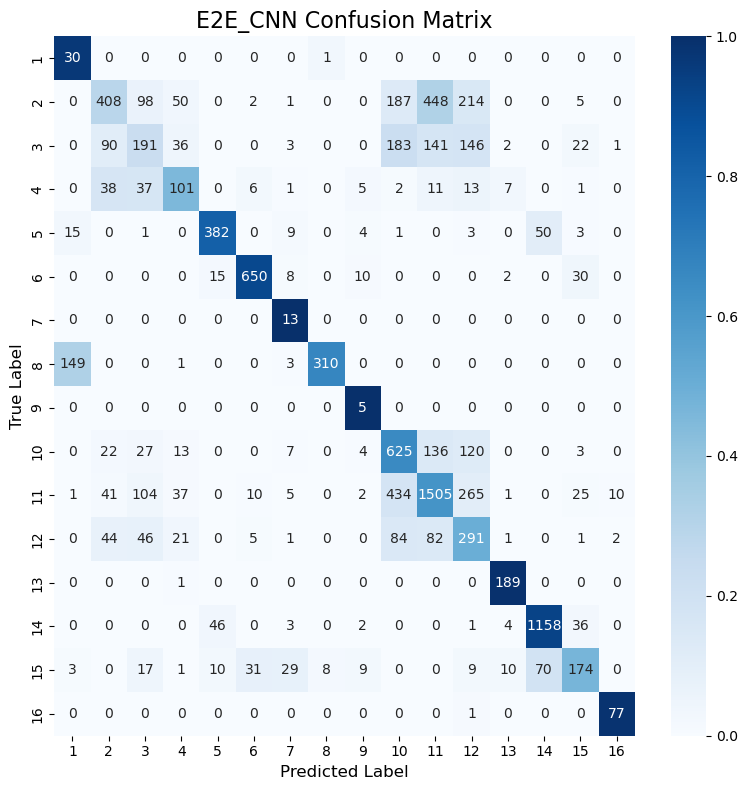

Classification Accuracy: 61.04%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


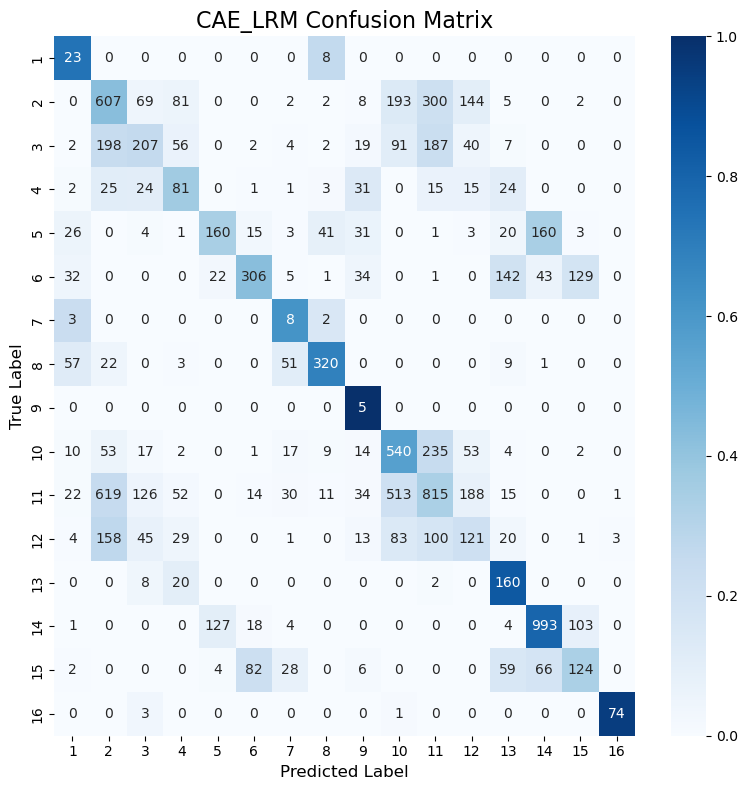

Classification Accuracy: 45.40%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


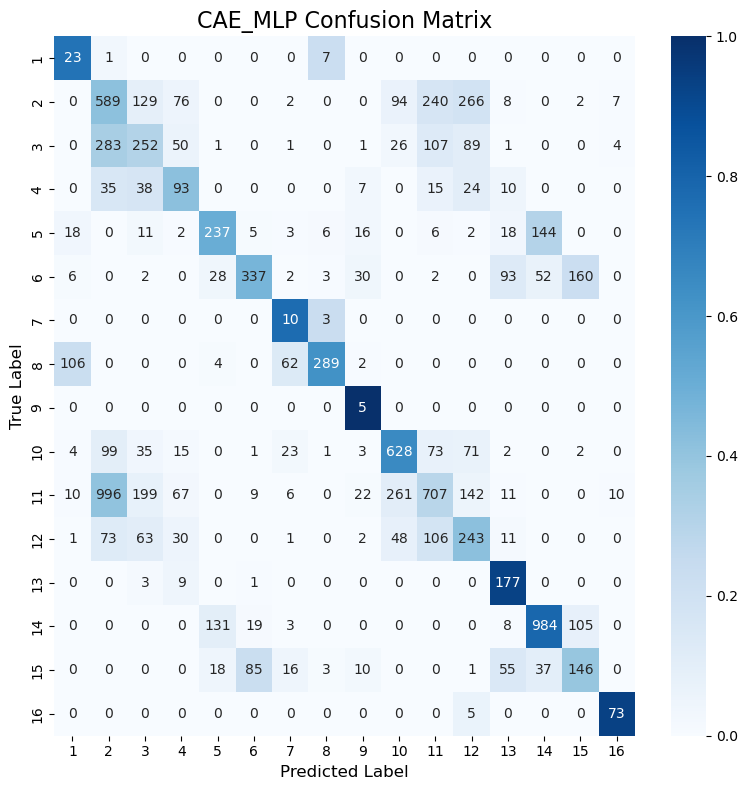

Classification Accuracy: 47.89%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


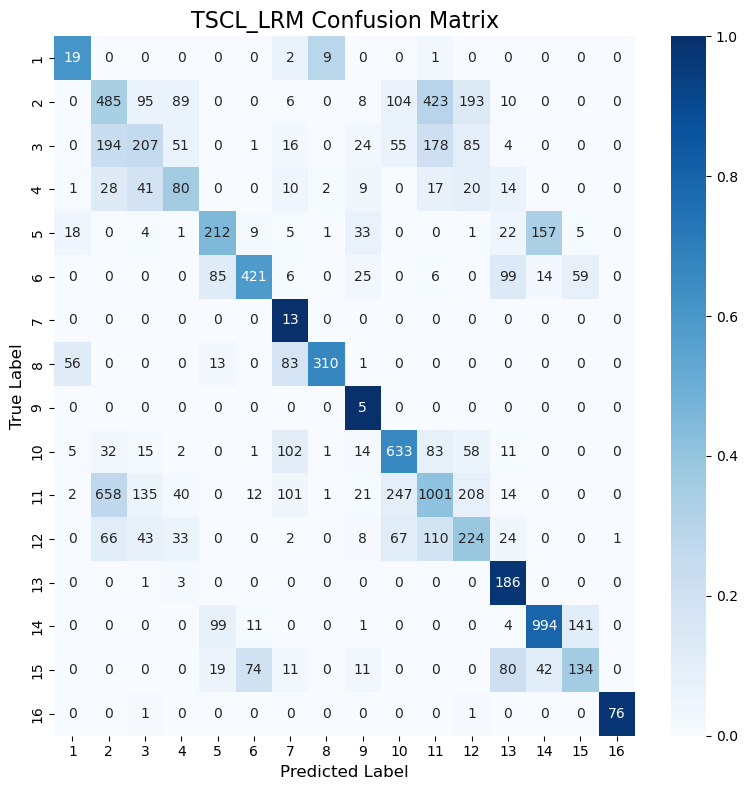

Classification Accuracy: 49.96%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


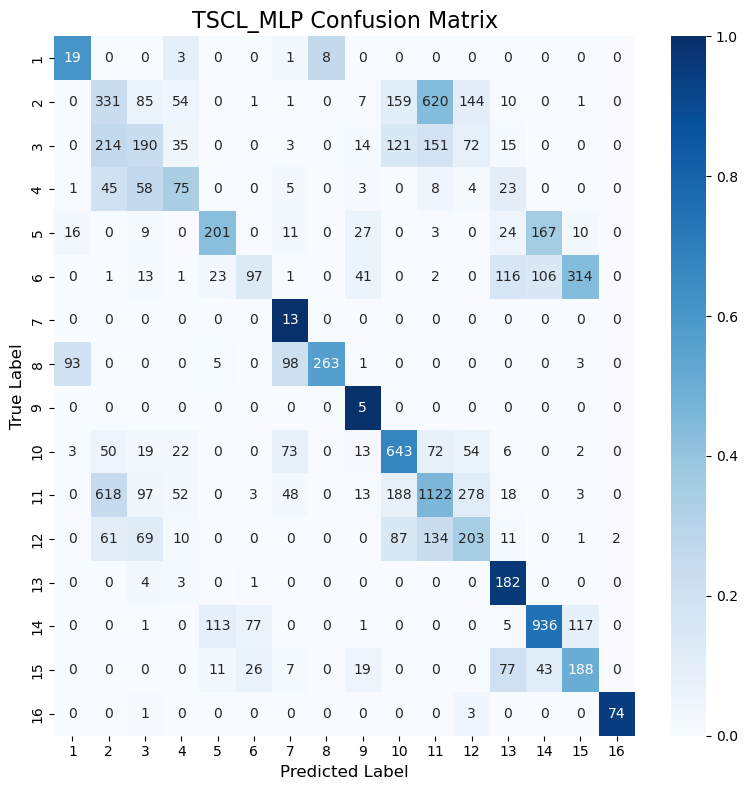

Classification Accuracy: 45.38%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


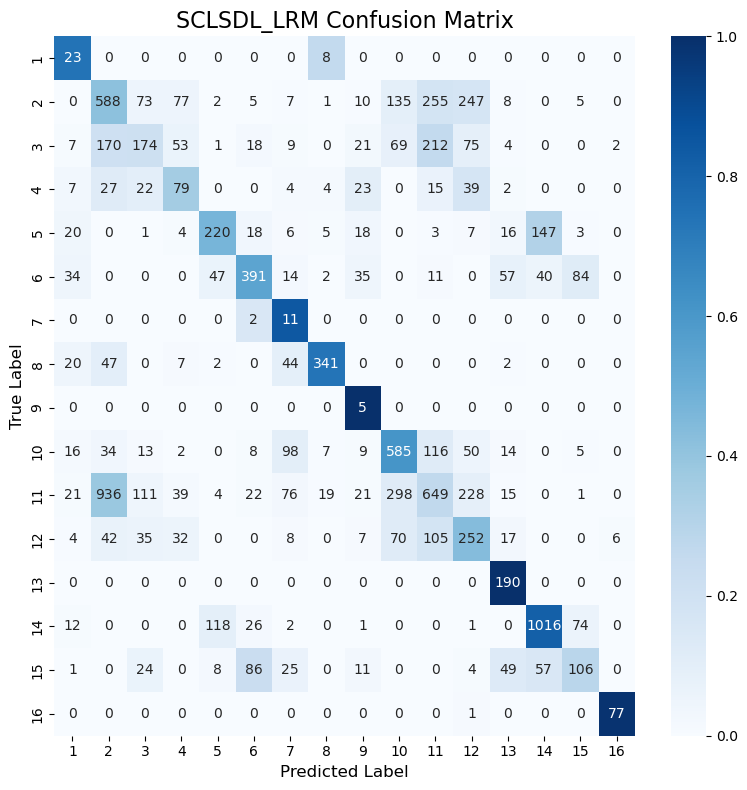

Classification Accuracy: 47.03%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


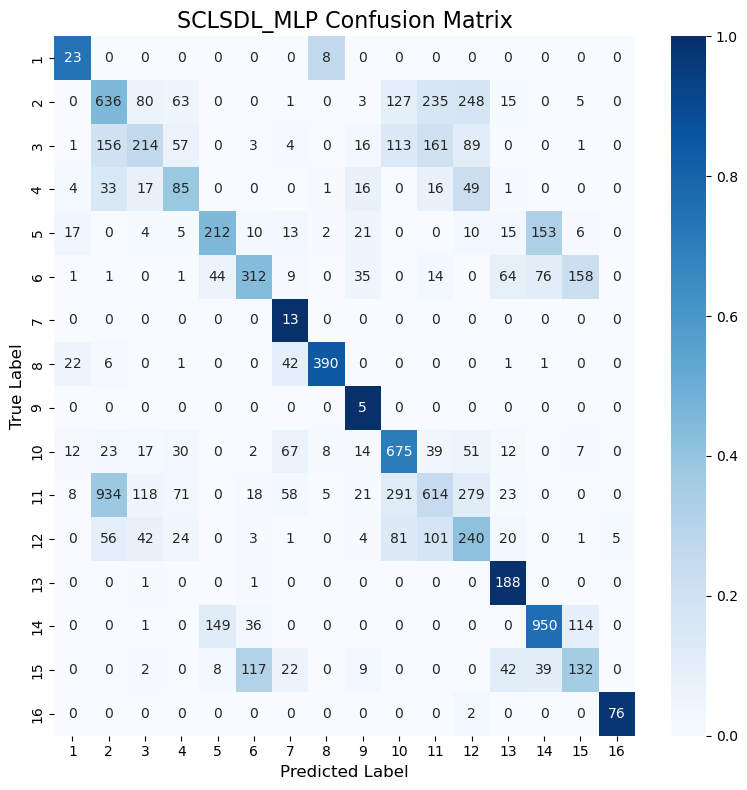

Classification Accuracy: 47.61%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          61.04
1    LRM (CAE)          45.40
2    MLP (CAE)          47.89
3     TSCL LRM          49.96
4     TSCL MLP          45.38
5  SCL_SDL LRM          47.03
6  SCL_SDL MLP          47.61

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          61.04
3     TSCL LRM          49.96
2    MLP (CAE)          47.89
6  SCL_SDL MLP          47.61
5  SCL_SDL LRM          47.03
1    LRM (CAE)          45.40
4     TSCL MLP          45.38
